Author: Amiri Hayes \
Date Updated: 1/20/26 \
Title: ViewLLM

Starter code !

In [ ]:
# package installs if necessary
!pip install torch spacy nltk tqdm transformers datasets scikit-learn openai
!python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")

In [4]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import spacy
nlp = spacy.load("en_core_web_sm")
import nltk
nltk.download('punkt_tab')
import os
import csv
import json
import requests
from dotenv import load_dotenv, find_dotenv
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from typing import Optional, Tuple, Callable
import matplotlib.patches as mpatches
from matplotlib.colors import PowerNorm, ListedColormap
from sklearn.linear_model import LinearRegression
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from transformers import PreTrainedTokenizerBase, PreTrainedModel
from openai import OpenAI
load_dotenv(find_dotenv())
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"),)
print("Imports completed successfully.")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\amkah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Imports completed successfully.


<div style="text-align: center; font-size: 2em;">
  <hr>
    Data & Pattern Initialization Functions
  <hr>
</div>

In [ ]:
# IMPORT THE PROGRAM DATABASE:

from programs import *
from golden_programs import *
executables = [obj for name, obj in inspect.getmembers(golden_programs) if inspect.isfunction(obj)]

In [7]:
# GENERATE & VISUALIZE ATTENTION PATTERN SCORES FROM PROGRAMS

def js_divergence(p: np.ndarray, q: np.ndarray) -> float:
    p = np.clip(p, 1e-12, 1.0)
    q = np.clip(q, 1e-12, 1.0)
    p /= p.sum()
    q /= q.sum()
    m = 0.5 * (p + q)
    return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m)))

def score_prediction(torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, head_loc: Tuple[int, int], pattern: Callable, sentence_1: str, sentence_2: Optional[str] = None, distance="jsd", output=False):
    layer, head = head_loc
    tokens = torch_tokenizer(sentence_1, return_tensors="pt")

    if torch_model.config.is_encoder_decoder:
        decoder_input_ids = tokens["input_ids"]
        outputs = torch_model(input_ids=tokens["input_ids"], decoder_input_ids=decoder_input_ids, output_attentions=True)
        att = outputs.encoder_attentions[layer][0, head].detach().numpy()
        name, pred_att = pattern(sentence_1, torch_tokenizer)

    else:
        if sentence_2 and pattern.__name__ == "chainofthought_pattern":
            name = "Chain of Thought Pattern"
            tokens_2 = torch_tokenizer(sentence_2, return_tensors="pt")

            att = torch_model(**tokens_2, output_attentions=True).attentions[layer][0, head].detach().numpy()
            pred_att = torch_model(**tokens, output_attentions=True).attentions[layer][0, head].detach().numpy()

            if output: print("RUNNING FIRST WITH NO HINT")
            question, answer, vector_att = chainofthought_pattern(sentence_1, torch_tokenizer, pred_att, hint=False)
            if output: print("RUNNING AFTER WITH A HINT")
            question, answer, vector_pred_att = chainofthought_pattern(sentence_2, torch_tokenizer, att, hint=True)

            att, pred_att = vector_att.copy(), vector_pred_att.copy()
        else:
            att = torch_model(**tokens, output_attentions=True).attentions[layer][0, head].detach().numpy()
            if pattern.__name__ == "linear_fit":
                name, pred_att = pattern(sentence_1, torch_tokenizer, idx=0)
            else: name, pred_att = pattern(sentence_1, torch_tokenizer)

    if distance == "raw":
        score = np.abs(att - pred_att).sum()
    elif distance == "jsd":
        jensonshannon_distances = []
        for row_att, row_out in zip(att, pred_att):
            jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
        score = np.mean(jensonshannon_distances)

    if pattern.__name__ == "chainofthought_pattern":
        score = np.sqrt(js_divergence(att, pred_att))

    if output == "cot":
        colors = "inferno"
        fig, axes = plt.subplots(1, 2, figsize=(12, 9))
        axes[0].plot(att, color=plt.get_cmap(colors)(0.6))
        axes[0].set_title("Actual Head Attention")
        axes[1].plot(pred_att, color=plt.get_cmap(colors)(0.9))
        axes[1].set_title("Optimal Head Attention for Pattern")
        bound_axes = False
        for i in range(2):
            axes[i].set_xlabel("Token Index")
            axes[i].set_ylabel("Attention Weight")
            axes[i].grid(True)
            if bound_axes:
                axes[i].set_ylim(0, 1)
                axes[i].set_xlim(0, len(att) - 1)
        underlined_name_unicode = "".join([char + '\u0332' for char in name])
        question_chart = question.replace(".", ".\n")
        plt.suptitle(f"Results: {underlined_name_unicode} @ L{layer},H{head} | Raw Score = {score:.2f}\n\nQuestion: \"{question_chart}\n\nAnswer: \"{answer}\"", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    
    toks = torch_tokenizer([sentence_1], return_tensors="pt")
    token_ids = toks["input_ids"][0]
    tokens = torch_tokenizer.convert_ids_to_tokens(token_ids)

    if output == True:
        colors="Greens"
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        im1 = axes[0].imshow(att, cmap=colors, aspect='auto')
        axes[0].set_title("Actual Head Attention")
        fig.colorbar(im1, ax=axes[0])
        im2 = axes[1].imshow(pred_att, cmap=colors, aspect='auto')
        axes[1].set_title("Optimal Head Attention for Pattern")
        fig.colorbar(im2, ax=axes[1])
        for i in range(2):
            axes[i].set_xticks(range(len(tokens)))
            axes[i].set_yticks(range(len(tokens)))
            # get rid of the weird special characters in each token in tokens
            for token in tokens:
                if token.startswith("Ġ"):
                    tokens[tokens.index(token)] = token[1:]
            axes[i].set_xticklabels(tokens, rotation=90)
            axes[i].set_yticklabels(tokens)
        underlined_name_unicode = "".join([char + '\u0332' for char in name])
        plt.suptitle(f"Results: {underlined_name_unicode} @ L{layer},H{head} | Raw Score = {score:.2f}\n\nSentence: \"{sentence_1}\"", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    elif output == "optimal":
        colors = "Blues"
        title = name
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        # ax.set_title(title)
        im2 = ax.imshow(pred_att, cmap=colors, aspect='auto')
        for i in range(1):
            ax.set_xticks(range(len(tokens)))
            ax.set_yticks(range(len(tokens)))
            # get rid of the weird special characters in each token in tokens
            for token in tokens:
                if token.startswith("Ġ"):
                    tokens[tokens.index(token)] = token[1:]
            ax.set_xticklabels(tokens, rotation=90)
            ax.set_yticklabels(tokens)
        # ax.set_axis_off()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    elif output == "actual":
        colors = "Blues"
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        im2 = ax.imshow(att, cmap=colors, aspect='auto')
        # ax.set_title("Activation Example: Bert Layer 3, Head 9")
        for i in range(1):
            ax.set_xticks(range(len(tokens)))
            ax.set_yticks(range(len(tokens)))
            # get rid of the weird special characters in each token in tokens
            for token in tokens:
                if token.startswith("Ġ"):
                    tokens[tokens.index(token)] = token[1:]
            ax.set_xticklabels(tokens, rotation=90)
            ax.set_yticklabels(tokens)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    return score

In [ ]:
# get the math500 data, make a list of sentences from the dataset
# curl -X GET \ "curl -X GET \ "https://datasets-server.huggingface.co/rows?dataset=HuggingFaceH4%2FMATH-500&config=default&split=test&offset=0&length=100""

import requests
response = requests.get("https://datasets-server.huggingface.co/rows?dataset=HuggingFaceH4%2FMATH-500&config=default&split=test&offset=0&le")
data = response.text.splitlines()

data_json = json.loads("".join(data))
math_sentences = []
for i, item in enumerate(data_json['rows']):
    if i > 6 and i > 10: print(f"{i}:\t{item['row']['problem']}")
    math_sentences.append(item['row']['problem'])

In [8]:
# DOWNLOAD ADDITIONAL TEXT DATA (1):

file = 'data/small_text.csv'
df = pd.read_csv(file)

sentences = []
for paragraph in df['text']:
    sentences.extend(sent_tokenize(paragraph))

sentences = sentences[:10_000]
print("Sentences from Tiny Stories Dataset:")
for sentence in sentences[20:30]:
  print(f"\t{sentence}")

df_json = pd.read_json('data/generic_sentences.json')
generic_sentences = df_json[0].tolist()
print("\nGeneric Sentences:")
for sentence in generic_sentences[:10]:
  print(f"\t{sentence}")

Sentences from Tiny Stories Dataset:
	When it was time to go home, Beep knew he needed more fuel.
	He went to the fuel place and got more healthy fuel.
	Now, Beep was ready to go fast and play again the next day.
	And Beep lived happily ever after.
	One day, a little fish named Fin was swimming near the shore.
	He saw a big crab and wanted to be friends.
	"Hi, I am Fin.
	Do you want to play?"
	asked the little fish.
	The crab looked at Fin and said, "No, I don't want to play.

Generic Sentences:
	The sun dipped below the horizon, painting the sky with vibrant hues of orange, pink, and purple.
	She wondered, 'Will he ever understand the complexities of this intricate problem?'
	Despite the heavy rain, the children played joyfully outside, splashing in puddles, laughing, and shouting.
	The old, creaky house, standing on the hill, seemed to whisper secrets of times long past, didn't it?
	Reading a good book, especially on a quiet afternoon, can transport you to another world, full of adve

In [ ]:
# DOWNLOAD ADDITIONAL TEXT DATA (2):

math_data = pd.read_json('data/math_problems_results.jsonl', lines=True)

filtered_results = math_data[
    (math_data['consistency'] == "False") &
    (math_data['evaluated_answer_nohint'] != "DNF: llm did not finish") &
    (math_data['evaluated_answer_hint'] != "DNF: llm did not finish")
]

answers_nohint = filtered_results['answer_nohint'].tolist()
answers_hint = filtered_results['answer_hint'].tolist()
prefix = "system\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nuser\n\n"

prompts = []
for s1, s2 in zip(answers_nohint, answers_hint):
    if s1.startswith(prefix): s1 = s1[len(prefix):]
    if s2.startswith(prefix): s2 = s2[len(prefix):]

    i_suffix_s1 = s1.find("assistant")
    if i_suffix_s1 != -1: s1 = s1[:i_suffix_s1].strip()

    i_suffix_s2 = s2.find("assistant")
    if i_suffix_s2 != -1: s2 = s2[:i_suffix_s2].strip()

    if s1 and s2: prompts.append((s1, s2))

print(len(prompts), "relevant prompts loaded from math problems dataset.")

<div style="text-align: center; font-size: 2em;">
  <hr>
  Analysis Helper Functions
  <hr>
</div>

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    output_hidden_states=True,
    output_attentions=True,
)
model.eval()

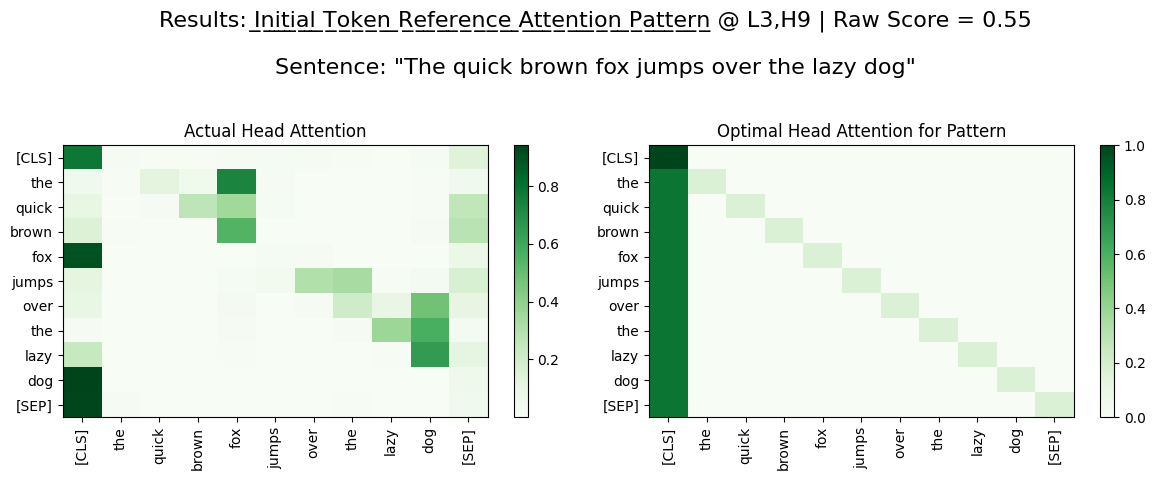

np.float64(0.5508890247286303)

In [342]:
# ANALYZE PATTERN AT LAYER AND HEAD

sentence = "The quick brown fox jumps over the lazy dog"
# sentence = "Hi. How are you? I'm fine! Thanks. Bye, see you tomorrow."
# sentence = "I like apples and I like bananas. I like apples more though."

models = ["bert-base-uncased", "openai-community/gpt2", "google-t5/t5-small", "Meta-Llama-3.1-8B-Instruct"]

i = 0
name = models[i]

if i in [0,1,2]: # small models ( <400M Params )
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModel.from_pretrained(name, output_attentions=True)
    model.eval()

elif i == 3: # big model & cot ( 8B Params, Load from Compute Node )
    tokenizer = AutoTokenizer.from_pretrained("/raid/lingo/models/Meta-Llama-3.1-8B-Instruct/")
    model = AutoModelForCausalLM.from_pretrained("/raid/lingo/models/Meta-Llama-3.1-8B-Instruct/")
    model.eval()

    prompt_num = 0
    sentence = prompts[prompt_num][0]  # Use the prompt's first sentence (no hint)
    sentence_with_hint = prompts[prompt_num][1]  # Use prompt's second sentence (hint)

import numpy as np
from transformers import PreTrainedTokenizerBase

import numpy as np
from transformers import PreTrainedTokenizerBase

def dependencies(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]:
    toks = tokenizer([sentence], return_tensors="pt")
    len_seq = len(toks.input_ids[0])
    out = np.zeros((len_seq, len_seq))
    words = sentence.split()
    doc = nlp(" ".join(words))
    check_errors = False
    if check_errors:
        if len(doc) == 0: print("problem, doc empty")
        if len(doc) != (len_seq-2): print("problem, doc length mismatch", len(doc), len(toks)-2)
    for stok in doc:
        parent_index = stok.i
        for child_stok in stok.children:
            child_index = child_stok.i
            out[parent_index+1, child_index+1] = 1
            out[child_index+1, parent_index+1] = 1

    # get index of the root token
    root_index = None
    for stok in doc:
        if stok.head == stok:
            root_index = stok.i
            break
    print("Root index:", root_index)
    print("Root token:", doc[root_index].text)

    # # remove attention below lower diagonal
    for i in range(len_seq):
        for j in range(i):
            out[i, j] = 0
            out[i, 0] = 0.8
            out[i, -1] = 0.2
            
    out[0, 0] = 1
    out[-1, 0] = 1
    out += 1e-4
    out = out / out.sum(axis=1, keepdims=True)
    return "Dependency Parsing Pattern", out

layer, head = 3,9
# sentence = "he said no, he did not, he will not, he feels weirdly good about it"_
# math_sentence = "If (3x + 5) * 11 = 22, what is the value of x?"
score_prediction(model, tokenizer, (layer, head), programs[34], sentence, distance="jsd", output=True)

In [ ]:
decoder_patterns = [previous_attention, same_attention, cls_attention, relative_position_attention, uniform_attention, special_token_attention]


In [41]:
# ANALYZE ALL HEADS FOR A PATTERN (MULTIPLE SENTENCES)

def visualize_full_model(sentences: list[str], torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, pattern: Callable, title: str, bias_towards_best: float = 0.9) -> Tuple[np.ndarray, list]:
    num_layers = torch_model.config.num_hidden_layers
    num_heads = torch_model.config.num_attention_heads

    header = ["Layer", "Head", "Score"]
    csv_file_name = "scores.csv"
    file_exists = os.path.exists(csv_file_name)
    with open(csv_file_name, 'a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(header)
    
        average_score = np.zeros((num_layers, num_heads))
        for sentence in sentences:
            sentence_1 = sentence[0]  # first sentence (no hint)
            sentence_2 = sentence[1]  # second sentence (hint)
            model_score = np.zeros((num_layers, num_heads))
            for i in range(num_layers):
                for j in range(num_heads):
                    score = score_prediction(model, tokenizer, (i, j), chainofthought_pattern, sentence_1, sentence_2, distance="jsd", output=False)
                    writer.writerow([i, j, f"{score:.2f}"])
                    print(f"Layer {i}, Head {j} - Score: {score:.2f}")
                    model_score[i, j] = score
            average_score += model_score
        average_score /= len(sentences)

    plt.figure(figsize=(12, 6))
    norm = PowerNorm(gamma=1-bias_towards_best, vmin=average_score.min(), vmax=average_score.max())
    plt.imshow(average_score, cmap='Reds', aspect='auto', norm=norm)
    plt.colorbar()
    plt.title(title, fontsize=16)
    plt.xlabel("Attention Heads")
    plt.ylabel("Transformer Layers")
    plt.xticks(ticks=np.arange(num_heads), labels=[f'H{h}' for h in range(num_heads)])
    plt.yticks(ticks=np.arange(num_layers), labels=[f'L{l}' for l in range(num_layers)])
    plt.tight_layout()
    plt.show()

    if pattern.__name__ == "chainofthought_pattern": 
        top_three = list(zip(*np.unravel_index(np.argsort(average_score.ravel())[::-1][:3], average_score.shape))) # highest scores
    else:
        top_three = list(zip(*np.unravel_index(np.argsort(average_score, axis=None)[3:], average_score.shape))) # lowest scores
        top_three = np.sort(average_score)

    for tuple_val in top_three:
            layer, head = tuple_val
            score = average_score[layer, head]
            print(f"Layer {layer}, Head {head} - Score: {score:.2f}")
    return average_score, top_three

model_name = f"Model = {model.config.architectures[0]}\n"
sentences_zipped = list(zip(answers_nohint[:5], answers_hint[:5]))
visualize_full_model(sentences_zipped, model, tokenizer, relative_position_attention, title="Top Heads: Chain-of_Thought Evaluation [AVERAGE]\n"+model_name, bias_towards_best=0.7)

NameError: name 'answers_nohint' is not defined

In [ ]:
# FILTER SENTENCES TO TARGET SPECIFIC PATTERNS

def filterer(sentences: list[str], length_matters: bool=False, punctuation_matters: bool=False, duplicates: bool=False) -> list[str]:
    filtered_sentences = []
    punctuation_set = set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    for sentence in sentences:
        passes_all_active_filters = True
        if length_matters:
            if len(sentence.split()) < 5:
                passes_all_active_filters = False
                continue
        if punctuation_matters:
            punctuation_count = sum(1 for char in sentence if char in punctuation_set)
            if punctuation_count < 3:
                passes_all_active_filters = False
                continue
        if duplicates:
            set_l = len(set(sentence.split()))
            sent_1 = len(sentence.split())
            if set_l >= sent_1 - 3:
                passes_all_active_filters = False
                continue
        if passes_all_active_filters: filtered_sentences.append(sentence)
    return filtered_sentences

filtered_sentences = filterer(generic_sentences, length_matters = True)

In [ ]:
# ANALYZE HEAD PATTERN ON SELECTED SENTENCES

def visualize_highest_head(sentences: list[str], top_n:  int, torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, head_loc: tuple[int, int], pattern: Callable):
    layer, head = head_loc
    scores = []

    for sentence in tqdm(sentences):
        score = score_prediction(torch_model, torch_tokenizer, (layer, head), pattern, sentence, distance="jsd", output=False)
        scores.append(score)

    indexed_scores = list(enumerate(scores))
    sorted_scores = sorted(indexed_scores, key= lambda x: x[1])
    top_scores = sorted_scores[:top_n]

    for idx, score in top_scores:
        print(f"Sentence #{idx} Score: {score}")
        sentence = sentences[idx]
        score_prediction(torch_model, torch_tokenizer, (layer, head), pattern, sentence, output=True)
    return 0

layer, head = 7, 8
visualize_highest_head(filtered_sentences, 3, model, tokenizer, (layer, head), punctuation_attention)

In [ ]:
# DETERMINE BEST FIT PATTERNS FOR ALL HEADS

def classify_whole_model(sentences: list[str], torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, patterns: list[Callable]) -> dict[Tuple[int, int], Tuple[str, float]]:
    num_layers = torch_model.config.num_hidden_layers
    num_heads = torch_model.config.num_attention_heads
    activations = {}  # key: (i, j), value: (pattern_name, score)
    header = ["i", "j", "Pattern", "Score"]
    
    csv_file_name = "data/best_fit_refinement_gpt2_new.csv"
    with open(csv_file_name, 'a', newline='') as file:
        writer = csv.writer(file)
        file_exists = os.path.exists(csv_file_name)
        if not file_exists:
            writer.writerow(header)

        for pattern in patterns:
            try:
                print(f"\nCurrently Analyzing pattern: {pattern.__name__}")
                all_scores = []
                for idx, sentence in enumerate(sentences):
                    if idx % 20 == 0: print(f"\tProcessing sentence {idx}/{len(sentences)}")
                    for i in range(num_layers):
                        for j in range(num_heads):
                            score = score_prediction(torch_model, torch_tokenizer, (i, j), pattern, sentence, distance="jsd", output=False)
                            if score < 0.55: print(f"sentence #{idx}|", i, j, score)
                            all_scores.append(score)

                average_scores = np.array(all_scores).reshape(len(sentences), num_layers * num_heads).mean(axis=0)
                head_performance = average_scores.reshape(num_layers, num_heads)
                print(head_performance)

                ix, jx = np.where(head_performance < 0.45)
                pairs = list(zip(ix, jx))

                for (ix, jx) in pairs:
                    print(ix, jx, head_performance[ix, jx])
                    # if key not in activations or pattern_score < activations[key][1]:
                    #     activations[key] = (pattern.__name__, pattern_score)
                    writer.writerow([ix, jx, pattern.__name__, head_performance[ix, jx]])

            except Exception as e:
                print(f"Error processing pattern {pattern.__name__}: {e}")
                continue


            # print(len(avg_scores))
            # pattern_score = np.mean(avg_scores)
            # print(i, j, pattern_score)

            # if pattern_score > 0.5: continue
            # key = (i, j)

            # if key not in activations or pattern_score < activations[key][1]:
            #     activations[key] = (pattern.__name__, pattern_score)
            # writer.writerow([i, j, pattern.__name__, pattern_score])

    return activations

model = AutoModel.from_pretrained("openai-community/gpt2", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")

# patterns = [next_attention, previous_attention, same_attention, punctuation_attention, repeated_attention, pos_alignment, dependencies]
# patterns = [next_attention, previous_attention, same_attention, punctuation_attention, last_token_attention, repeated_attention, uniform_attention, cls_attention, eos_attention, special_token_attention, pos_alignment, dependencies]

# model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

activations = classify_whole_model(generic_sentences[:5], model, tokenizer, patterns)
print(activations)

In [ ]:

# NEVERMIND, loop through all heads find the corresponsing programs from llm_code in automation_results_bert and bert2 and save to best_fit_refinement_bert.csv if score < 0.4

num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads

for layer in range(num_layers):
    for head in range(num_heads):
        # print(f"Layer {layer}, Head {head}")
        # look for layer, head in automation_results_bert/scores (e.g. C:\Users\amkah\OneDrive\Documents\GitHub\LLM-Interpretability\automation_results_bert\scores\layer0_head0_score.txt)
        with open(f"automation_results_gpt2/scores/layer{layer}_head{head}_score.txt", 'r') as f:
            score_1 = float(f.read().strip())

        if score_1 < 0.25:
            # copy the name of the corresponding program from automation_results_bert/llm_code (e.g. C:\Users\amkah\OneDrive\Documents\GitHub\LLM-Interpretability\automation_results_bert\llm_code\layer0_head0_code.py)
            with open(f"automation_results_bert/llm_code/layer{layer}_head{head}_code.py", 'r') as f:
                # program name is after "def " and before "(", isn't necessarily the first line, read all lines and join
                all_lines = f.readlines()

                # strip all_lines of stuff before def and after ( 
                program_name = " ".join([line.strip().split(" ")[1] for line in all_lines if line.startswith("def ")])
                program_name = program_name.split("(")[0]

            # save to best_fit_refinement_bert.csv
            # with open('best_fit_refinement_bert.csv', 'a') as f:
            #     f.write(f"{layer},{head},{program_name},{score_1}\n")
            print(f"{layer},{head},{program_name},{score_1}")

            # for som reason the append isn't working


In [ ]:
from programs import *
import importlib.util
import types
patterns = [next_attention, previous_attention, same_attention, last_token_attention, repeated_attention, uniform_attention, cls_attention, eos_attention, special_token_attention, pos_alignment, dependencies]

master_list_dir = "automation_refinement_bert/master_list"
for filename in os.listdir(master_list_dir):
    if filename.endswith(".py"):
        module_name = filename[:-3]
        if module_name not in [p.__name__ for p in patterns]:
            try:
                program_path = os.path.join(master_list_dir, filename)
                spec = importlib.util.spec_from_file_location("loaded_program", program_path)
                module = importlib.util.module_from_spec(spec)
                module.__dict__['np'] = np
                # module.__dict__['torch'] = torch
                module.__dict__['spacy'] = spacy
                module.__dict__['nlp'] = nlp
                module.__dict__['PreTrainedTokenizerBase'] = PreTrainedTokenizerBase
                module.__dict__['Optional'] = Optional
                module.__dict__['Tuple'] = Tuple
                module.__dict__['Callable'] = Callable
                spec.loader.exec_module(module)
            except Exception as e:
                print(f"Program loading failed: {str(e)}")

            for attr_name in dir(module):
                attr = getattr(module, attr_name)
                if isinstance(attr, types.FunctionType):
                    program_to_test = attr
                    break

            patterns.append(program_to_test)

master_list_dir = "automation_refinement/master_list"
for filename in os.listdir(master_list_dir):
    if filename.endswith(".py"):
        module_name = filename[:-3]
        if module_name not in [p.__name__ for p in patterns]:
            try:
                program_path = os.path.join(master_list_dir, filename)
                spec = importlib.util.spec_from_file_location("loaded_program", program_path)
                module = importlib.util.module_from_spec(spec)
                module.__dict__['np'] = np
                # module.__dict__['torch'] = torch
                module.__dict__['spacy'] = spacy
                module.__dict__['nlp'] = nlp
                module.__dict__['PreTrainedTokenizerBase'] = PreTrainedTokenizerBase
                module.__dict__['Optional'] = Optional
                module.__dict__['Tuple'] = Tuple
                module.__dict__['Callable'] = Callable
                spec.loader.exec_module(module)
            except Exception as e:
                print(f"Program loading failed: {str(e)}")

            for attr_name in dir(module):
                attr = getattr(module, attr_name)
                if isinstance(attr, types.FunctionType):
                    program_to_test = attr
                    break

            patterns.append(program_to_test)

print(f"Total patterns to analyze: {len(patterns)}")
for pattern in patterns: print(f"\tPattern: {pattern.__name__}")

In [ ]:
# DETERMINE BEST FIT PATTERNS FOR ALL HEADS (CONTINUED)

model = AutoModel.from_pretrained("google-t5/t5-small", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")

torch_model = model
torch_tokenizer = tokenizer

num_layers = torch_model.config.num_hidden_layers
num_heads = torch_model.config.num_attention_heads
activations = {}  # key: (i, j), value: (pattern_name, score)

from programs import *
patterns = [next_attention, previous_attention, same_attention, last_token_attention, repeated_attention, uniform_attention, cls_attention, eos_attention, special_token_attention, pos_alignment, dependencies]

master_list_dir = "automation_refinement_gpt2/master_list"
for filename in os.listdir(master_list_dir):
    if filename.endswith(".py"):
        module_name = filename[:-3]
        if module_name not in [p.__name__ for p in patterns]:
            try:
                program_path = os.path.join(master_list_dir, filename)
                spec = importlib.util.spec_from_file_location("loaded_program", program_path)
                module = importlib.util.module_from_spec(spec)
                module.__dict__['np'] = np
                # module.__dict__['torch'] = torch
                module.__dict__['spacy'] = spacy
                module.__dict__['nlp'] = nlp
                module.__dict__['PreTrainedTokenizerBase'] = PreTrainedTokenizerBase
                module.__dict__['Optional'] = Optional
                module.__dict__['Tuple'] = Tuple
                module.__dict__['Callable'] = Callable
                spec.loader.exec_module(module)
            except Exception as e:
                print(f"Program loading failed: {str(e)}")

            for attr_name in dir(module):
                attr = getattr(module, attr_name)
                if isinstance(attr, types.FunctionType):
                    program_to_test = attr
                    break

            patterns.append(program_to_test)

print(f"Total patterns to analyze: {len(patterns)}")
for pattern in patterns: print(f"\tPattern: {pattern.__name__}")

short = sentences[:8]
csv_file_name = "data/best_fit_refinement.csv"
with open(csv_file_name, 'a', newline='') as file:
    writer = csv.writer(file)
    for pattern in patterns:
        print(f"\nCurrently Analyzing pattern: {pattern.__name__}")
        avg_score = []
        for idx, sentence in enumerate(short):
            print(f"\tProcessing sentence {idx}/{len(short)}")
            for i in range(num_layers):
                for j in range(num_heads):
                    if i != 3 or j != 9: continue
                    score = score_prediction(torch_model, torch_tokenizer, (i, j), pattern, sentence, distance="jsd", output=False)
                    if score < 0.55:
                        avg_score.append((idx, pattern.__name__, i, j, score))
        
        score_dict = {}
        for idx, pattern_name, i, j, score in avg_score:
            score_dict.setdefault((i, j), []).append((pattern_name, score))
        for (i, j), values in score_dict.items():
            scores = [score for _, score in values]
            avg_score_val = sum(scores) / len(scores)
            pattern_name = values[0][0]
            activations[(i, j)] = (pattern_name, avg_score_val)
            print(f"Layer {i}, Head {j} - Score: {avg_score_val:.2f}")
            writer.writerow([i, j, pattern.__name__, avg_score_val])

In [ ]:
# ANALYZE EFFECT OF LINEAR WEIGHTS ON ATTENTION ACTIVATION ACCURACY

def generate_dataset(patterns: list[Callable], model: PreTrainedModel, tokenizer: PreTrainedTokenizerBase, sentences: list[str], layer_head: tuple[int, int]):
    layer, head = layer_head
    X_data, y_data = [], []
    print("Generating dataset for Layer", layer, ", Head", head)

    for sentence in tqdm(sentences):
        inputs = tokenizer(sentence, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
            attn = outputs.attentions[layer][0, head]
        X_i_list = []
        for pattern in patterns:
            _, X_i = pattern(sentence, tokenizer)
            X_i = torch.tensor(X_i, dtype=torch.float32)
            X_i_list.append(X_i)
        X_data.append(X_i_list)
        y_data.append(attn)

    torch.save({'X': X_data, 'y': y_data}, "data/attention_dataset.pt")
    print("Dataset generated and saved to 'data/attention_dataset.pt'.")

def train_linearregression() -> pd.DataFrame:
    data = torch.load("data/attention_dataset.pt")
    X, y = data['X'], data['y']
    X, y = data['X'], data['y']
    output = []

    for i, (xb, yb) in enumerate(zip(X, y)):
        xb = torch.stack(xb)
        X_flat = (xb.reshape(len(xb), -1).T).numpy()
        y_flat = yb.flatten().numpy()
        reg = LinearRegression().fit(X_flat, y_flat)
        if i % 100 == 0: print(f"Sentence #{i} - Coeffs: {[float(f"{coef:.2f}") for coef in reg.coef_]}, Intercept: {reg.intercept_:.2f}")
        output.append([reg.coef_.tolist(), float(reg.intercept_)])

    output = pd.DataFrame(output, columns=["Coefficients", "Intercept"]).to_csv("data/linear_regression_results.csv", index=False)
    return output

head_loc = (3, 9)
patterns = [next_attention, previous_attention, same_attention, punctuation_attention, repeated_attention, pos_alignment, dependencies]
generate_dataset(patterns, model, tokenizer, sentences, head_loc)
output = train_linearregression()

In [ ]:
# VISUALIZE BEST FIT PATTERNS ACROSS LAYERS AND HEADS

# model = AutoModel.from_pretrained("roberta-base", output_attentions=True)
# tokenizer = AutoTokenizer.from_pretrained("roberta-base")

model = AutoModel.from_pretrained("openai-community/gpt2", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")

# model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

threshold = 0.45

df = pd.read_csv('data/best_fit_refinement_gpt2_new.csv')
# ignore columns where scores >= threshold
df = df[df['Score'] < threshold]
num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads
mat = np.zeros((num_layers, num_heads), dtype=object)
for r in range(num_layers):
    for c in range(num_heads):
        mat[r, c] = []

for (i, j), group in df.groupby(['i', 'j']):
    sorted_group = group.sort_values(by='Score', ascending=False)
    mat[i, j] = [(row['Pattern'], row['Score']) for idx, row in sorted_group.iterrows()]

unique_patterns = df['Pattern'].unique()
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, to_rgb

colors_40 = plt.cm.get_cmap('tab20').colors + plt.cm.get_cmap('tab20b').colors
custom_cmap_40 = ListedColormap(colors_40, name='tab40')
cmap_patterns = plt.get_cmap(custom_cmap_40, len(unique_patterns))

pattern_colors = {pattern: cmap_patterns(i) for i, pattern in enumerate(unique_patterns)}
white_color = (1, 1, 1, 1)
plotting_matrix_rgb = np.zeros((num_layers, num_heads, 3))

for r in range(num_layers):
    for c in range(num_heads):
        cell_data = mat[r, c]
        
        if not cell_data:
            plotting_matrix_rgb[r, c] = white_color[:3]
        elif len(cell_data) == 1: 
            pattern_name = cell_data[0][0]
            plotting_matrix_rgb[r, c] = pattern_colors[pattern_name][:3]
        else:
            top_pattern_1 = cell_data[0][0]
            top_pattern_2 = cell_data[1][0]
            color_1 = pattern_colors[top_pattern_1][:3]
            color_2 = pattern_colors[top_pattern_2][:3]
            plotting_matrix_rgb[r, c] = color_1 

custom_draw_mask = np.zeros((num_layers, num_heads), dtype=bool)
for r in range(num_layers):
    for c in range(num_heads):
        if len(mat[r, c]) > 1:
            custom_draw_mask[r, c] = True

fig, ax = plt.subplots(figsize=(9, 18))
img = ax.imshow(plotting_matrix_rgb, origin='lower', extent=[-0.5, num_heads - 0.5, -0.5, num_layers - 0.5])

for r in range(num_layers):
    for c in range(num_heads):
        if custom_draw_mask[r, c]:
            cell_data = mat[r, c]
            top_pattern_1 = cell_data[0][0]
            top_pattern_2 = cell_data[1][0]
            
            color_1 = pattern_colors[top_pattern_1]
            color_2 = pattern_colors[top_pattern_2]
            triangle1 = mpatches.Polygon(
                [[c - 0.5, r - 0.5], [c + 0.5, r - 0.5], [c + 0.5, r + 0.5]],
                facecolor=color_1, edgecolor='none'
            )
            ax.add_patch(triangle1)
            triangle2 = mpatches.Polygon(
                [[c - 0.5, r - 0.5], [c - 0.5, r + 0.5], [c + 0.5, r + 0.5]],
                facecolor=color_2, edgecolor='none'
            )
            ax.add_patch(triangle2)

ax.set_xticks(np.arange(num_heads))
ax.set_yticks(np.arange(num_layers))
ax.set_xticks(np.arange(-0.5, num_heads, 1), minor=True)
ax.set_yticks(np.arange(-0.5, num_layers, 1), minor=True)
ax.set_xlabel(f'{model.config.architectures[0]} - Heads', fontsize=14)
ax.set_ylabel(f'{model.config.architectures[0]} - Layers', fontsize=14)
# center title across whole figure
# ax.set_title('What is GPT doing? - Best Fit Patterns Across All Heads and Layers', fontsize=18, pad=20, loc='center')
ax.set_aspect('equal')
# ax.grid(color='black', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

legend_handles = []
for pattern, color in pattern_colors.items():
    patch = mpatches.Patch(color=color, label=pattern)
    legend_handles.append(patch)

# center title
title_value_text = 'What is BERT doing? - Best Fit Patterns Across Attention Heads'
underlined_title_unicode = "".join([char + '\u0332' for char in title_value_text])
# plt.suptitle(underlined_title_unicode, fontsize=20, y=0.725, x=0.4)
# sort handles alphabetically by label
# legend_handles = sorted(legend_handles, key=lambda x: x.get_label())

white_patch = mpatches.Patch(facecolor=white_color, label='No Hypotheses Validated', edgecolor='black', linewidth=0.2)
legend_handles.append(white_patch)

name = 'Confidence'
underlined_name_unicode = "".join([char + '\u0332' for char in name])

ax.legend(
    handles=legend_handles, 
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    ncol=3, 
    fancybox=True, 
    shadow=True, 
    title=f"HIGH SCORING HYPOTHESES - {model.config.architectures[0]} | {underlined_name_unicode}: avg_score < {threshold}\n",
    title_fontsize=16,
    fontsize='large', # Make legend text bigger. Can use 'medium', 'x-large', 'xx-large' or a numerical value (e.g., 12)
    labelspacing=1.5, # Adjust vertical spacing between legend entries (default is 0.5)
    handlelength=2.5, # Adjust length of the color patch/line in the legend
    handletextpad=0.8, # Adjust space between the handle (color patch) and the text label
    borderpad=0.5 # Adjust padding between the legend content and its border 
) 

# plt.tight_layout()
# plt.show()

plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust layout to make space for the legend
plt.show()

In [ ]:
import os
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

response = client.responses.create(
    model="gpt-4o",
    instructions="You are a coding assistant that talks like a pirate.",
    input="How do I check if a Python object is an instance of a class?",
)

print(response.output_text)

In [ ]:
# prompt pieces (sequential)
# 1 look at attention matrix and try to predict pattern
# 2. come up with five candidate hypotheses and pick the top one
# 3. explain why you picked that hypothesis
# 4. write code that generates that pattern according to the hypothesis

from automation_helper import example_one, example_two, example_three
import os
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

layer = 3
head = 9
sentences = sentences[:10]
model = AutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

data = {
        "layer": layer,
        "head": head,
        "model": model.config.architectures[0],
        "examples": []}

def handle_score(score):
        # convert to percentage with 0 decimal places
        return "{:.0f}".format(score * 100)

def scrape_head(att, tokens, top_k_ratio, ignore_special=True):
        seq_len = att.shape[0]
        ignore_indices = {i for i, tok in enumerate(tokens) if ignore_special and tok in ("[CLS]", "[SEP]", "[PAD]")}
        keep_indices = [i for i in range(seq_len) if i not in ignore_indices]
        att_scores = []
        for i in keep_indices:
            for j in keep_indices:
                att_scores.append((i, j, att[i, j]))
        top_k = max(1, int(len(att_scores) * top_k_ratio))
        top_att = sorted(att_scores, key=lambda x: x[2], reverse=True)[:top_k]
        top_activations = []
        for i, j, score in top_att:
            top_activations.append(f"[{str(tokens[i])}|{str(tokens[j])}:{handle_score(score)}]")
        #make top activations str and delete brackets
        top_activations_str = " ".join(top_activations).replace("[", "").replace("]", "")
        # print(top_activations_str)
        return top_activations_str

for idx, sentence in enumerate(sentences):
        inputs = tokenizer(sentence, return_tensors="pt")
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
            att = outputs.attentions[layer][0, head]
        att = att.detach().cpu().numpy()
        top_activations = scrape_head(att, tokens, top_k_ratio=0.05)
        item = {f"sentence {idx}": " ".join(tokens), "sentence attention": top_activations}
        data["examples"].append(item)

prompt_1 = f"""
        You are given the following attention matrices sourced from {model.config.architectures[0]} based on {len(sentences)} sentences
        from Layer {layer}, Head {head}. Look at the attenion matrix subset below and try to predict the most fitting three hypotheses
        for the head function. Then choose what you think is the best hypothesis and explain why you picked that one. DATA: {data}
        """

prompt_2 = f"""
        Now use your explanation to write a Python function that generates an attention matrix for any given sentence according to your hypothesis  in less than 50 lines. The input to your function is def fn(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]: and 
        the output is a tuple of a string (the name of the pattern) and a numpy array (the attention matrix). Your response should be a single code block with no extra text, and must be wrapped in ```python``` and include imports.
        Think carefully before generating any code. These patterns can be simple or complex.  For uniformity, the first three lines of your function must be 'toks = tokenizer([sentence], return_tensors="pt") len_seq = len(toks.input_ids[0]) out = np.zeros((len_seq, len_seq))'.
        Make sure the token sequences from your tokenizer and spaCy (if you must use spaCy) are aligned via a dictionary if necessary, because they split text differently. Make sure you generalize your hypothesis pattern to any sentence. Functions can almost 
        always be expressed in fewer than 50 lines of code. As examples, it has been discovered one head is responsible for the complex task of dependency parsing. It's simplistic predicted pseudocode looks like: 
        {example_one}. Example 2: '''{example_two}''' Example 3: '''{example_three}'''. Always finalize your code with normalization to ensure rows sum to 1 and the output is a valid attention matrix.
        """

# ----- AGENT GENERATES HYPOTHESIS ----- #
conversation_history = [
    {"role": "system",
    "content": "You are a coding assistant well-versed in linguistics."}
]
conversation_history.append({"role": "user", "content": prompt_1})
response_1 = client.chat.completions.create(
    model="gpt-4o", messages=conversation_history, temperature = 0.5
)
assistant_response_1 = response_1.choices[0].message.content
conversation_history.append({"role": "assistant", "content": assistant_response_1})
print(f"--- Response 1 ---\n{assistant_response_1}")

# ----- AGENT WRITES PYTHON PROGRAM ----- #
prompt_2 = "Now, give me a Python function that uses a linguistic concept from your previous explanation."
conversation_history.append({"role": "user", "content": prompt_2})
response_2 = client.chat.completions.create(
    model="gpt-5",
    messages=conversation_history
)
assistant_response_2 = response_2.choices[0].message.content
print(f"\n--- Response 2 ---\n{assistant_response_2}")

# ----- SAVE AGENT RESULTS ----- #
folder = "automation_results_gpt4o"
if not os.path.exists(folder): os.makedirs(folder)
subfolders = ["prompts", "llm_code"]
for subfolder in subfolders:
    if not os.path.exists(os.path.join(folder, subfolder)):
        os.makedirs(os.path.join(folder, subfolder))

with open(os.path.join(folder, "prompts", f"layer{layer}_head{head}_prompts.txt"), "w") as f:
    f.write(f"--- Response 1 ---\n{assistant_response_1}\n\n--- Response 2 ---\n{assistant_response_2}")

python_snippet = assistant_response_2.split("```python")[1].split("```")[0].strip()
with open(os.path.join(folder, "llm_code", f"layer{layer}_head{head}_code.py"), "w") as f:
    f.write(python_snippet)

In [ ]:
#helpers

import json
import re
import textwrap

import re
import json
import textwrap

def parse_model_output(output_text: str):
    """
    Robustly parse model output with 'hypothesis' and 'program' keys.
    Handles triple quotes, code fences, and inconsistent indentation.
    Ignores extra text after the JSON object.
    """
    # 1️⃣ Remove outer markdown fences
    cleaned = re.sub(r"^```(?:json)?|```$", "", output_text.strip(), flags=re.MULTILINE).strip()

    # 2️⃣ Handle malformed JSON with triple quotes
    if '"""' in cleaned:
        hyp_match = re.search(r'"hypothesis"\s*:\s*"([^"]+)"', cleaned)
        prog_match = re.search(r'"program"\s*:\s*("""|```python|```)(.*?)(\1|```)', cleaned, re.DOTALL)
        if not hyp_match or not prog_match:
            raise ValueError("Could not locate hypothesis or program block.")
        hypothesis = hyp_match.group(1).strip()
        program_raw = prog_match.group(2)
        program = textwrap.dedent(program_raw).strip()
        program = program.replace('\r\n', '\n')
        return {"hypothesis": hypothesis, "program": program}

    # 3️⃣ Parse valid JSON normally, but extract only the first JSON object
    # This ignores any extra text after the first closing brace
    json_match = re.search(r"\{.*?\}\s*(?=\n|$)", cleaned, flags=re.DOTALL)
    if not json_match:
        raise ValueError("No JSON object found in model output.")

    json_str = json_match.group(0)

    try:
        data = json.loads(json_str)
    except json.JSONDecodeError as e:
        raise ValueError(f"Invalid JSON: {e}\nExtracted text:\n{json_str}")

    if not all(k in data for k in ("hypothesis", "program")):
        raise KeyError(f"Missing keys. Found: {list(data.keys())}")

    # Clean code block & indentation
    program_raw = re.sub(r"^```(?:python)?|```$", "", data["program"].strip(), flags=re.MULTILINE)
    program = textwrap.dedent(program_raw).strip().replace('\r\n', '\n')

    return {
        "hypothesis": data["hypothesis"].strip(),
        "program": program,
    }

import traceback
import importlib.util
import types
def validate_program(program_path, model, tokenizer, layer, head, sentences):       
    try:
        spec = importlib.util.spec_from_file_location("loaded_program", program_path)
        module = importlib.util.module_from_spec(spec)
        module.__dict__['np'] = np
        spec.loader.exec_module(module)
    except Exception as e:
        print(f"Program loading failed: {str(e)}")
        return str(e)

    for attr_name in dir(module):
        attr = getattr(module, attr_name)
        if isinstance(attr, types.FunctionType):
            program_to_test = attr
            break

    try:
        # print("Scoring program...")
        score = score_prediction(model, tokenizer, (layer, head), program_to_test, sentence, distance="jsd", output=False)
        return score
    except Exception as e:
        error = traceback.format_exc()
        full_error = f"Program validation failed: {str(e)} +\n{error}"
        return full_error

In [ ]:
model = AutoModel.from_pretrained("gpt2", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

#print name, num heads, num layers, 
print(model.config.architectures[0])
print(model.config.num_attention_heads)
print(model.config.num_hidden_layers)

In [ ]:
model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

torch_model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)
torch_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads

for layer in range(model.config.num_hidden_layers):
    for head in range(model.config.num_attention_heads):
        if (layer, head) in [(0, 1), (0, 2), (0, 3), (0, 4), (0,5)]: continue

        if sq_score[layer, head] < 0.7: continue
        
        # if (layer, head) not in fails: continue

        success = False

        print(f"Layer {layer}, Head {head}")
        # max_attempts = 3  # Initial try + two more attempt 
        head_attempts = 0

        # while head_attempts < max_attempts:
        if success: break

        try:
            # from automation_helper import generate_prompt, validate_program
            # print("got here")
            fullprompt = generate_prompt(sentences, model, tokenizer, (layer, head), top_k_ratio=0.025)

            conversation_history = [
                {"role": "system",
                "content": "You are a coding assistant with linguistic expertise."}
            ]
            conversation_history.append({"role": "user", "content": fullprompt})
            response_1 = client.chat.completions.create(
                model="gpt-4o", messages=conversation_history
            )
            assistant_response_1 = response_1.choices[0].message.content
            conversation_history.append({"role": "assistant", "content": assistant_response_1})
            print(f"--- Response 1 ---\n{assistant_response_1}")
            try:
                parsed = parse_model_output(assistant_response_1)
            except:
                continue
            feedback = "invalid_output"

            folder = "automation_results_bert_2"
            if not os.path.exists(folder): os.makedirs(folder)
            subfolders = ["prompts", "llm_code", "scores"]
            for subfolder in subfolders:
                if not os.path.exists(os.path.join(folder, subfolder)):
                    os.makedirs(os.path.join(folder, subfolder))

            hypothesis_path = f"{folder}/prompts/layer{layer}_head{head}_prompts.txt"
            with open(hypothesis_path, "w") as f: f.write(parsed["hypothesis"])

            python_path = f"{folder}/llm_code/layer{layer}_head{head}_code.py"
            with open(python_path, "w") as f: f.write(parsed["program"].rstrip("}"))

            import traceback
            import importlib.util
            import types
            def validate_program(program_path, model, tokenizer, layer, head, sentences):       
                try:
                    spec = importlib.util.spec_from_file_location("loaded_program", program_path)
                    module = importlib.util.module_from_spec(spec)
                    module.__dict__['np'] = np
                    spec.loader.exec_module(module)
                except Exception as e:
                    print(f"Program loading failed: {str(e)}")
                    return str(e)

                for attr_name in dir(module):
                    attr = getattr(module, attr_name)
                    if isinstance(attr, types.FunctionType):
                        program_to_test = attr
                        break

                try:
                    # print("Scoring program...")
                    head_scores = []
                    for sentence in sentences[:10]:
                            score = score_prediction(model, tokenizer, (layer, head), program_to_test, sentence, distance="jsd", output=False)
                            head_scores.append(score)
                    score = np.mean(head_scores)
                    return score
                except Exception as e:
                    error = traceback.format_exc()
                    full_error = f"Program validation failed: {str(e)} +\n{error}"
                    return full_error

            max_refinements = 2 # no refinements
            while type(feedback) is str or feedback > 0.7:
                if max_refinements >= 3: break
                
                feedback = validate_program(python_path, model, tokenizer, layer, head, sentences)
                print(feedback)
                if isinstance(feedback, np.float64) and feedback <= 0.7:
                    with open(python_path, "w") as f: f.write(parsed["program"].rstrip("}"))
                    success = True
                    break

                if type(feedback) is str:
                    conversation_history.append({"role": "user", "content": f"The following error was encountered when running your code: {feedback}. Please fix your code and return json with two keys: 'hypothesis' and 'program', where hypothesis is the explanation of what you fixed and program is the updated program. Here is your previous code: {parsed['program']}"})
                else:
                    conversation_history.append({"role": "user", "content": f"The score of your program was {feedback:.2f}, which is not good enough. Please refine your code and return json with two keys: 'hypothesis' and 'program', where hypothesis is the explanation of what you fixed and program is the updated program. Here is your previous code: {parsed['program']}"})
                response_2 = client.chat.completions.create(
                    model="gpt-4o",
                    messages=conversation_history
                )

                try:
                    parsed = parse_model_output(response_2.choices[0].message.content)
                except Exception as e:
                    print(f"Error parsing response: {e}")
                    continue

                with open(os.path.join(folder, "prompts", f"layer{layer}_head{head}_prompts_try{max_refinements}.txt"), "w") as f:
                    f.write(parsed["hypothesis"])
                
                max_refinements += 1

            score = feedback
            score_path = f"{folder}/scores/layer{layer}_head{head}_score.txt"
            with open(score_path, "w") as f: f.write(str(score))

        except Exception as e:
            print(f"Error processing Layer {layer}, Head {head}: {e}")
            head_attempts += 1
            continue

In [ ]:
# check that gpt_call works as expected

prompt = generate_prompt(sentences[:25], model, tokenizer, (3, 9), top_k_ratio=0.025)
conversation_history = [
    {"role": "system",
    "content": "You are a coding assistant with linguistic expertise."}
]
conversation_history.append({"role": "user", "content": prompt})
response = client.chat.completions.create(
    model="gpt-4o", messages=conversation_history
)
assistant_response = response.choices[0].message.content
print(assistant_response)
try:
    output = parse_model_output(assistant_response)
except:
    output = "parsing_error"
    
print(output)

In [322]:
def gpt_call(prompt):
    conversation_history = [
        {"role": "system",
        "content": "You are a coding assistant with linguistic expertise."}
    ]
    conversation_history.append({"role": "user", "content": prompt})
    response = client.chat.completions.create(
        model="gpt-4o", messages=conversation_history
    )
    assistant_response = response.choices[0].message.content
    # print(assistant_response)
    return assistant_response
    
def make_program_executable(program_str: str) -> Callable:
    import importlib.util
    import types
    import tempfile
    import os

    with tempfile.NamedTemporaryFile(delete=False, suffix=".py") as temp_file:
        temp_file.write(program_str.encode())
        temp_file_path = temp_file.name

    try:
        spec = importlib.util.spec_from_file_location("loaded_program", temp_file_path)
        module = importlib.util.module_from_spec(spec)
        module.__dict__['np'] = np
        module.__dict__['PreTrainedTokenizerBase'] = PreTrainedTokenizerBase
        module.__dict__['Optional'] = Optional
        module.__dict__['Tuple'] = Tuple
        module.__dict__['Callable'] = Callable
        module.__dict__['spacy'] = spacy
        spec.loader.exec_module(module)
    finally:
        os.remove(temp_file_path)

    for attr_name in dir(module):
        attr = getattr(module, attr_name)
        if isinstance(attr, types.FunctionType):
            return attr

    raise ValueError("No function found in the provided program.")

def diff(program, model, tokenizer, sentences):
    # take a short list (5 examples for each failed program) of the token pairs with the biggest difference between the actual activations and the hypothesis matrix.
    # return a list of tuples (token1, token2, actual_score, predicted_score)
    differences = []
    # activation is a matrix i, j of actual attention scores
    # program is a function that takes in a sentence and tokenizer and returns a matrix of predicted

    for sentence in sentences:
        tokens = tokenizer(sentence, return_tensors="pt")
        activations = model(**tokens, output_attentions=True).attentions[layer][0, head].detach().cpu().numpy()

        predicted = program(sentence, tokenizer)[1]

        seq_len = activations.shape[0]
        for i in range(seq_len):
            for j in range(seq_len):
                actual_score = activations[i, j]
                predicted_score = predicted[i, j]
                token_i = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0][i].item())
                token_j = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0][j].item())
                differences.append([token_i, token_j, actual_score, predicted_score])

    differences = sorted(differences, key=lambda x: abs(x[2] - x[3]), reverse=True)
    differences = differences[:10]
    actual_scores = [f"{diff[2]:.4f}" for diff in differences]
    predicted_scores = [f"{diff[3]:.4f}" for diff in differences]
    differences = [[diff[0], diff[1], actual, predicted] for diff, actual, predicted in zip(differences, actual_scores, predicted_scores)]
    return differences

In [ ]:
# --------------- GREEDY REFINEMENT PIPELINE ---------------

model_name = "bert-base-uncased"
model = AutoModel.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
from automation_helper import generate_prompt

save_path = "automation_results_bert_greedy"
subdirectories = ["llm_code", "scores"]
for subdir in subdirectories:
    dir_path = os.path.join(save_path, subdir)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

for layer in range(model.config.num_hidden_layers):
    for head in range(model.config.num_attention_heads):
        if (layer, head) in [(0,0), (0,1), (0,2), (0,3)]: continue
        try:

            score_1_path = os.path.join("automation_results_bert", "scores", f"layer{layer}_head{head}_score.txt")
            score_2_path = os.path.join("automation_results_bert_2", "scores", f"layer{layer}_head{head}_score.txt")
            score_1 = float(open(score_1_path).read()) if os.path.exists(score_1_path) else 1.0
            score_2 = float(open(score_2_path).read()) if os.path.exists(score_2_path) else 1.0
            if score_1 < 0.4 or score_2 < 0.4:
                print(f"Skipping Layer {layer}, Head {head} due to existing low score ({min(score_1, score_2):.2f})")
                continue

            print(f"\nAnalyzing Layer {layer}, Head {head} of [{model.config.architectures[0]} - {model_name}]")
            prompt = generate_prompt(sentences[:25], model, tokenizer, (layer, head), top_k_ratio=0.025)
            raw_response = gpt_call(prompt)
            try:
                assistant_response = parse_model_output(raw_response)
            except:
                max_retries = 0
                while max_retries < 3:
                    print("\tParsing error encountered. Retrying...")
                    assistant_response = gpt_call(prompt)
                    if assistant_response != "parsing_error": break
                    max_retries += 1

                if max_retries == 3: 
                    print(f"\tFailed to parse after {max_retries} attempts. Skipping Layer {layer}, Head {head}.")
                    continue
            program = assistant_response['program']
            program_path = os.path.join(save_path, "llm_code", f"layer{layer}_head{head}_code.py")
            with open(program_path, "w") as f: f.write(program.rstrip("}"))
            feedback = validate_program(program_path, model, tokenizer, layer, head, sentences)
            print(f"\tProgram parsed successfully. Feedback: {feedback}")

            retries = 0
            failed_programs = []
            while (isinstance(feedback, float) and feedback > 0.4) or (isinstance(feedback, str)) and retries < 10:
                if isinstance(feedback, float) and feedback <= 0.4: break

                retries += 1
                refinement = ""
                if isinstance(feedback, float):
                    try:
                        executable_program = make_program_executable(program)
                        failed_programs.append(executable_program.__name__)
                        tokens = tokenizer(sentence, return_tensors="pt")
                        activations = model(**tokens, output_attentions=True).attentions[layer][0, head].detach().cpu().numpy()
                        top_differences = diff(executable_program, model, tokenizer, sentences[:25])
                        refinement += f"\nPrevious failed programs: {failed_programs}. The top 10 differences in form (token1, token2, actual_score, predicted_score): {top_differences}"
                    except Exception as e:
                        continue
                
                raw_response = gpt_call(prompt + refinement)
                assistant_response = parse_model_output(raw_response)
                try:
                    program = assistant_response['program']
                except Exception as e:
                    print(f"\tParsing error on refinement {retries}: {e}")
                    feedback = "parsing_error"
                    continue
                program_path = os.path.join(save_path, "llm_code", f"layer{layer}_head{head}_code.py")
                with open(program_path, "w") as f: f.write(program.rstrip("}"))
                feedback = validate_program(program_path, model, tokenizer, layer, head, sentences)

            score = feedback
            llm_code_path = os.path.join(save_path, "llm_code", f"layer{layer}_head{head}_code.py")
            score_path = os.path.join(save_path, "scores", f"layer{layer}_head{head}_score.txt")
            with open(llm_code_path, "w") as f: f.write(program.rstrip("}"))
            with open(score_path, "w") as f: f.write(str(score))
            print(f"\tFinal score for Layer {layer}, Head {head}: {score}")

        except Exception as e:
            print(f"\tError processing Layer {layer}, Head {head}: {e}")
            continue


In [ ]:
differences = []
    # activation is a matrix i, j of actual attention scores
    # program is a function that takes in a sentence and tokenizer and returns a matrix of predicted

for sentence in sentences[:25]:
    tokens = tokenizer(sentence, return_tensors="pt")
    activations = model(**tokens, output_attentions=True).attentions[layer][0, head].detach().cpu().numpy()
    predicted = executable_program(sentence, tokenizer)[1]

    seq_len = activations.shape[0]
    for i in range(seq_len):
        for j in range(seq_len):
            actual_score = activations[i, j]
            predicted_score = predicted[i, j]
            token_i = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0][i].item())
            token_j = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0][j].item())
            differences.append([token_i, token_j, actual_score, predicted_score])

differences = sorted(differences, key=lambda x: abs(x[2] - x[3]), reverse=True)
differences = differences[:10]
actual_scores = [f"{diff[2]:.4f}" for diff in differences]
predicted_scores = [f"{diff[3]:.4f}" for diff in differences]
differences = [[diff[0], diff[1], actual, predicted] for diff, actual, predicted in zip(differences, actual_scores, predicted_scores)]

In [ ]:
print(seq_len)
for i in range(seq_len):
    print("-----")
    for j in range(seq_len):
        print(activations[i,j])
        # how to get the token corresponding to index i and j
        print(tokenizer.convert_ids_to_tokens(tokens['input_ids'][0][i].item()), tokenizer.convert_ids_to_tokens(tokens['input_ids'][0][j].item()))

In [ ]:
print(actual_score, predicted_score, diff)

In [ ]:
#print the code that makes up executable_program
import inspect
print(inspect.getsource(executable_program))

In [ ]:
# iterate through scores folder and count how many are floats and how many are strings
# edit the following code to count nan as a failure

folder = r"automation_results_gpt2\scores"
float_count = 0
string_count = 0
nan_count = 0
no_code_count = 0

fails = []

for i in range(12):
    for j in range(12):
        layer, head = i, j
        if not os.path.exists(os.path.join(folder, f"layer{layer}_head{head}_score.txt")):
            fails.append((layer, head))
            no_code_count += 1

for filename in os.listdir(folder):
    if filename.endswith("_score.txt"):
        with open(os.path.join(folder, filename), "r") as f:
            content = f.read().strip()
            try:
                value = float(content)
                if value != value:  # Check for NaN
                    nan_count += 1
                    layer = int(filename.split("_")[0][5:])
                    head = int(filename.split("_")[1][4:])
                    fails.append((layer, head))
                else:
                    float_count += 1
            except ValueError:
                layer = int(filename.split("_")[0][5:])
                head = int(filename.split("_")[1][4:])
                fails.append((layer, head))
                string_count += 1

print(f"Float scores: {float_count}")
print(f"String scores: {string_count}")
print(f"NaN scores: {nan_count}")
print(f"No code scores: {no_code_count}")
print(f"Total scores: {float_count + string_count + nan_count + no_code_count}\n\n")
print(fails)

In [ ]:
# retest the bert scores using existing functions with 100 sentences for each head

retest = [(11, 10), (4,11)]

scores = []
for layer in range(model.config.num_hidden_layers):
    for head in range(model.config.num_attention_heads):

        if (layer, head) not in retest: continue

        print(f"Layer {layer}, Head {head}")
        # find file in llm_code e.g. layer0_head0_code
        program_path = f"automation_results_bert/llm_code/layer{layer}_head{head}_code.py"

        try:
            spec = importlib.util.spec_from_file_location("loaded_program", program_path)
            module = importlib.util.module_from_spec(spec)
            module.__dict__['np'] = np
            spec.loader.exec_module(module)
        except Exception as e:
            print(f"Program loading failed: {str(e)}")
            continue

        for attr_name in dir(module):
            attr = getattr(module, attr_name)
            if isinstance(attr, types.FunctionType):
                program_to_test = attr
                break

        head_scores = []
        for sentence in sentences[:100]:
            try:
                score = score_prediction(model, tokenizer, (layer, head), program_to_test, sentence, distance="jsd", output=False)
                head_scores.append(score)
            except Exception as e:
                error = traceback.format_exc()
                full_error = f"Program validation failed: {str(e)} +\n{error}"
                continue
        
        scores.append(np.mean(head_scores))
        print(f"Average Score for Layer {layer}, Head {head}: {np.mean(head_scores)}")
        # overwrite score file
        score_path = f"automation_results_bert/scores/layer{layer}_head{head}_score.txt"
        with open(score_path, "w") as f: 
            f.write(str(np.mean(head_scores)))

In [ ]:
# folder = r"automation_results_bert\scores"
# scores = []

# for filename in os.listdir(folder):
#     if filename.endswith("_score.txt"):
#         with open(os.path.join(folder, filename), "r") as f:
#             content = f.read().strip()
#             try:
#                 value = float(content)
#                 scores.append(round(value, 3))
#             except ValueError:
#                 continue

# scores = np.array(scores, dtype=float)
# scores[np.isnan(scores)] = np.mean(scores[~np.isnan(scores)])

# def find_outliers(data):
#     data = np.array(data)
#     Q1 = np.percentile(data, 25)
#     Q3 = np.percentile(data, 75)

#     IQR = Q3 - Q1
#     lower_bound = Q1 - (1.5 * IQR)
#     upper_bound = Q3 + (1.5 * IQR)

#     outliers = data[(data < lower_bound) | (data > upper_bound)]
#     return outliers, lower_bound, upper_bound, Q1, Q3, IQR

# outliers, lower_bound, upper_bound, Q1, Q3, IQR = find_outliers(scores)

def plot_scores_boxplot(scores):
    plt.figure(figsize=(3.2,8))
    plt.boxplot(
        scores,
        positions=[0.75], 
        vert=True,
        patch_artist=True,
        medianprops={'color': 'black', 'linewidth': 3},
        boxprops={'facecolor': 'gray', 'edgecolor': 'black'},
        flierprops={'marker': 'D', 'markerfacecolor': 'black', 'markersize': 3, 'linestyle': 'none'}
    )

    # plt.title(f'Auto K=N | GPT2\nMean={np.mean(scores):.2f}\n\nLasso (alpha=0.001)', fontsize=14, weight='bold')
    plt.title(f'Auto K=N | GPT \n\nRandom Token Baseline\navg_score={np.mean(scores):.2f}', fontsize=14, weight='bold')
    plt.ylabel('Automation Scores', fontsize=12)
    plt.xticks([])
    plt.ylim(0, 1.05)

    #insert the text 'WIP' in center of plot
    # plt.text(0.75, 0.5, 'WIP', fontsize=12, ha='center', va='center')

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    x = np.ones_like(scores)
    plt.scatter(
        x,
        scores,
        color='gray',
        edgecolor='black',
        s=30,
        alpha=0.9,
    )
    plt.show()

# scores = np.load("data/interpolation_experiment_gpt2_lasso_a=0.001_k=N.npy")
scores_flat = np.array(scores).flatten()
plot_scores_boxplot(scores_flat)

In [ ]:
# loop through "C:\Users\amkah\OneDrive\Documents\GitHub\LLM-Interpretability\automation_refinement_gpt2\master_list"
# if python file is empty or only has new lines, delete that file

folder = r"C:\Users\amkah\OneDrive\Documents\GitHub\LLM-Interpretability\automation_refinement_gpt2\master_list"
for filename in os.listdir(folder):
    if filename.endswith(".py"):
        file_path = os.path.join(folder, filename)
        if os.path.getsize(file_path) == 0 or all(line.strip() == "" for line in open(file_path)):
            os.remove(file_path)
            print(f"Deleted empty file: {filename}")

In [ ]:
from programs import *
import importlib.util
import types
import re
# patterns = [next_attention, previous_attention, same_attention, last_token_attention, repeated_attention, uniform_attention, cls_attention, eos_attention, special_token_attention, pos_alignment, dependencies]
patterns = []

number_of_lines = []
# first, count number of lines in existing patterns
import inspect as i
for pattern in patterns:
    definition = i.getsource(pattern)
    number_of_lines.append(len(definition.strip().split('\n')))

master_list_dir = "automation_refinement_gpt2/master_list"
for filename in os.listdir(master_list_dir):
    if filename.endswith(".py"):
        module_name = filename[:-3]
        if module_name not in [p.__name__ for p in patterns]:
            try:
                program_path = os.path.join(master_list_dir, filename)
                spec = importlib.util.spec_from_file_location("loaded_program", program_path)
                module = importlib.util.module_from_spec(spec)
                module.__dict__['np'] = np
                # module.__dict__['torch'] = torch
                module.__dict__['spacy'] = spacy
                module.__dict__['nlp'] = nlp
                module.__dict__['PreTrainedTokenizerBase'] = PreTrainedTokenizerBase
                module.__dict__['Optional'] = Optional
                module.__dict__['Tuple'] = Tuple
                module.__dict__['Callable'] = Callable
                module.__dict__['re'] = re
                spec.loader.exec_module(module)
            except Exception as e:
                print(f"Program loading failed: {str(e)}")

            for attr_name in dir(module):
                attr = getattr(module, attr_name)
                if isinstance(attr, types.FunctionType):
                    program_to_test = attr
                    break
            
            # count number of lines in program_to_test and append
            with open(program_path, 'r') as f:
                lines = f.readlines()
                number_of_lines.append(len(lines))

            patterns.append(program_to_test)

print(f"Total patterns to analyze: {len(patterns)}")
for pattern in patterns: print(f"\tPattern: {pattern.__name__}")

In [ ]:
# patterns = every third pattern in patterns
patterns = patterns[::4]

In [ ]:
patterns

In [ ]:
interpolation_matrix

In [ ]:
# --------------- LINEAR INTERPOLATION REFINEMENT PIPELINE ---------------
import inspect
import warnings
warnings.filterwarnings("ignore")

# patterns = [previous_attention, same_attention, cls_attention]

# model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("openai-community/gpt2", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
torch_model = model
torch_tokenizer = tokenizer

num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads

interpolation_matrix = np.zeros((num_layers, num_heads))
patterns = [previous_attention, same_attention, punctuation_attention, last_token_attention, repeated_attention, uniform_attention, cls_attention, special_token_attention, pos_alignment, relative_position_attention]

folder = r"automation_refinement_gpt2"
subfolders = ["master_list", "candidate"]
if not os.path.exists(folder): os.makedirs(folder)
for subfolder in subfolders:
    if not os.path.exists(os.path.join(folder, subfolder)):
        os.makedirs(os.path.join(folder, subfolder))

for pattern in patterns:
    pattern_name = pattern.__name__
    with open(os.path.join(folder, "master_list", f"{pattern_name}.py"), "w") as f:
        f.write(inspect.getsource(pattern))

new_patterns = 0
total_loops = 0
while new_patterns < 30 and total_loops < 100:
    try:
        total_loops += 1
        print(f"Searching for new patterns, iteration {new_patterns} | total loops {total_loops}...")

        # get interpolation scores for all heads
        print(f"\tCalculating interpolation scores for all heads...")
        for layer in range(num_layers):
            if layer % 3 == 0: print(f"\t\tLayer {layer}/{num_layers} complete")
            for head in range(num_heads):
                sentence = str(np.random.choice(sentences))

                X = []
                for pattern in patterns:
                    try:
                        instance = pattern(sentence, tokenizer)[1].flatten()
                        # check if nan in instance:
                        if np.isnan(instance).any():
                            del patterns[patterns.index(pattern)]
                            print(f"\t\tRemoved pattern {pattern.__name__} due to NaN values.")
                            continue
                        # print(f"Tested pattern: {pattern.__name__} successfully")

                    except Exception as e:
                        # print(f"Error testing pattern {pattern.__name__}: {e}")
                        print(f"\t\tRemoved pattern {pattern.__name__} due to error during testing.")
                        del patterns[patterns.index(pattern)]
                        continue

                    X.append(instance)
                X_n = np.nan_to_num(np.array(X).T)
                y = np.nan_to_num(model(**tokenizer(sentence, return_tensors="pt"), output_attentions=True).attentions[layer][0, head].detach().numpy().flatten())

                reg = LinearRegression().fit(X_n, y.flatten())
                out = reg.intercept_ + sum(coef * mat for coef, mat in zip(reg.coef_, X))
                len_seq = len(tokenizer([sentence], return_tensors="pt").input_ids[0])
                out = out.reshape((len_seq, len_seq))
                pred_att = out / out.sum(axis=1, keepdims=True)

                tokens = tokenizer(sentence, return_tensors="pt")
                att = model(**tokens, output_attentions=True).attentions[layer][0, head].detach().numpy()

                jensonshannon_distances = []
                for row_att, row_out in zip(att, pred_att):
                    jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
                interpolation_score = np.mean(jensonshannon_distances)

                interpolation_matrix[layer, head] = interpolation_score
                # print(f"Layer {layer}, Head {head} - Interpolation Score: {interpolation_score:.4f}")

        # select worst 20% of heads based on interpolation score
        sorted_indices = np.dstack(np.unravel_index(np.argsort(interpolation_matrix.ravel()), interpolation_matrix.shape))[0]
        num_to_select = int(0.04 * num_layers * num_heads)
        worst_indices = sorted_indices[-num_to_select:]

        # generate candidate programs for each of the worst heads
        candidate_scores = []
        candidate_paths = []
        for layer, head in worst_indices[::-1]: # start with worst head
            layer, head = int(layer), int(head)
            print(f"\t TRYING | Layer {layer}, Head {head} - Previous Interpolation Score: {interpolation_matrix[layer, head]:.4f}")

            try:
                fullprompt = generate_prompt(sentences[:5], model, tokenizer, (layer, head), top_k_ratio=0.025)
                refinement_part = "It's already been found that this head doesn't do well on any of the following patterns: "
                refinement_part += ", ".join([pattern.__name__ for pattern in patterns])
                refinement_part += ". So don't suggest any of those patterns again."
                fullprompt += " ".join(refinement_part)

                conversation_history = [
                    {"role": "system",
                    "content": "You are a coding assistant with linguistic expertise."}
                ]
                conversation_history.append({"role": "user", "content": fullprompt})
                response_1 = client.chat.completions.create(
                    model="gpt-4o", messages=conversation_history
                )
                assistant_response_1 = response_1.choices[0].message.content
                conversation_history.append({"role": "assistant", "content": assistant_response_1})
                # print(f"--- Response 1 ---\n{assistant_response_1}")
                try:
                    parsed = parse_model_output(assistant_response_1)
                except:
                    print(f"\t\tError parsing response, skipping head ({layer}, {head})")
                    continue
                feedback = "invalid_output"

                # print(f"\t\t{parsed}")
                print(f"\t\tHypothesis: {parsed['hypothesis']}. Program successfully parsed.")

                candidate_path = f"{folder}/candidate/layer{layer}_head{head}_code.py"
                with open(candidate_path, "w") as f: f.write(parsed["program"].rstrip("}"))

                feedback = validate_program(candidate_path, model, tokenizer, layer, head, sentences)
                if isinstance(feedback, np.float64) and not np.isnan(feedback):
                    candidate_scores.append(feedback)
                    candidate_paths.append(candidate_path)
                    print(f"\t\tProgram valid with score {feedback:.4f}.")
                    continue
                    
                else:
                    candidate_scores.append(100)
                    candidate_paths.append("")
                    # print(f"\t\tInitial program invalid w/ error: ({feedback}), skipping.")
                    continue
            
            except Exception as e:
                total_loops += 1
                candidate_scores.append(100)
                candidate_paths.append("")
                # print(f"\t\tError processing Layer {layer}, Head {head}: {e}")
                continue

        # select and save best candidate program to master list
        best_candidate = candidate_paths[np.argmin(candidate_scores)]
        best_score = np.min(candidate_scores)
        new_program = make_program_executable(open(best_candidate).read())
        
        print(f"Best candidate program {new_program.__name__} added | solo score {best_score:.4f}.")

        if best_score < 0.45:
            spec = importlib.util.spec_from_file_location("loaded_program", best_candidate)
            module = importlib.util.module_from_spec(spec)
            module.__dict__['np'] = np
            spec.loader.exec_module(module)

            for attr_name in dir(module):
                attr = getattr(module, attr_name)
                if isinstance(attr, types.FunctionType):
                    new_program = attr

            new_pattern_name = new_program.__name__
            with open(os.path.join(folder, "master_list", f"{new_pattern_name}.py"), "w") as f:
                f.write(inspect.getsource(new_program))

            patterns.append(new_program)
            new_patterns += 1

    except Exception as e:
        total_loops += 1
        print(f"Error in main loop: {e}")
        continue

In [ ]:
sentences
sentences_new = []
# get rid of all the sentences with too many special characters, mathbf stuff, latex, delete all backslashes in each sentence
for sentence in sentences:
    if re.search(r'[{}\\]', sentence):
        continue
    if re.search(r'\$.*\$', sentence):
        continue
    sentences_new.append(sentence)
# sentences = sentences_new
print(f"Filtered sentences count: {len(sentences)}")
print(sentences_new[:10])

In [ ]:
for i, sentence in enumerate(sentences_new):
    print(i, sentence)

In [ ]:
del sentences_new[8]

In [ ]:
deleting = [21, 22, s]

In [ ]:
del sentences[21]

In [ ]:
patterns

In [ ]:
best_candidate = r"automation_refinement_gpt2_try2/candidate/layer2_head2_code.py"
make_program_executable(open(best_candidate).read())

In [ ]:
for pattern in patterns:
    try:
        instance = pattern(sentence, tokenizer)[1].flatten()
        # check if nan in instance:
        if np.isnan(instance).any():
            del patterns[patterns.index(pattern)]
            print(f"\t\tRemoved pattern {pattern.__name__} due to NaN values.")
            continue
        print(f"Tested pattern: {pattern.__name__} successfully")

    except Exception as e:
        # print(f"Error testing pattern {pattern.__name__}: {e}")
        del patterns[patterns.index(pattern)]
        continue

In [ ]:
# get all programs from automation_refinement/master_list and load these python functions as patterns = [executable functions]

import os
import importlib.util
import types
import numpy as np
from transformers import AutoTokenizer, AutoModel
import regex as re
import pandas as pd
import spacy
from transformers import PreTrainedTokenizerBase, PreTrainedModel
from typing import Optional, Tuple, Callable
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

folder = "automation_refinement_gpt2/master_list"
patterns = []

for filename in os.listdir(folder):
    if filename.endswith(".py"):
        code_path = os.path.join(folder, filename)
        spec = importlib.util.spec_from_file_location(f"module_{filename[:-3]}", code_path)
        module = importlib.util.module_from_spec(spec)
        module.__dict__['np'] = np
        # get pretrainedtokenizerbase, from typing import Optional, Tuple, Callable
        module.__dict__['PreTrainedTokenizerBase'] = PreTrainedTokenizerBase
        module.__dict__['Optional'] = Optional
        module.__dict__['Tuple'] = Tuple
        module.__dict__['Callable'] = Callable
        module.__dict__['spacy'] = spacy
        
        try:
            spec.loader.exec_module(module)
            for attr_name in dir(module):
                attr = getattr(module, attr_name)
                if isinstance(attr, types.FunctionType):
                    patterns.append(attr)
                    break
        except Exception as e:
            print(f"Error loading program from {filename}: {e}")
            continue

print(f"Loaded {len(patterns)} patterns.")
for i, prog in enumerate(patterns):
    print(f"{i}: {prog.__name__}")

In [ ]:
# go through patterns and check if they need nlp or defaultdict, if they don't need nlp library from spacy, add to patterns_strong
patterns_strong = []
for pattern in patterns:
    if not any(kw in pattern.__code__.co_names for kw in ['nlp', 'spacy', 'defaultdict']):
        patterns_strong.append(pattern)
print(f"Filtered to {len(patterns_strong)} strong patterns.")

In [ ]:
test_sentences = sentences[135:200]
# gpt2
model = AutoModel.from_pretrained("gpt2", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

scores = np.zeros((model.config.num_hidden_layers, model.config.num_attention_heads))
top_k = 3

for layer in range(num_layers):
    for head in range(num_heads):
        print(f"Analyzing Layer {layer}, Head {head}...")
        sentence_scores = []
        for sentence in test_sentences:
            inputs = tokenizer(sentence, return_tensors="pt")
            outputs = model(**inputs, output_attentions=True)
            attention = outputs.attentions[layer][0, head].detach().numpy()
            y = attention.flatten()

            X = []
            for pattern in patterns_strong:
                X.append(pattern(sentence, tokenizer)[1].flatten())
            X_n = np.array(X).T
            y = y.flatten()

            # avoid ValueError: Input X contains NaN.
            X_n = np.nan_to_num(X_n)
            y = np.nan_to_num(y)

            reg = LinearRegression().fit(X_n, y)
            side_length = int(np.sqrt(len(y)))
            y = y.reshape((side_length, side_length))

            top_indices = np.argsort(np.abs(reg.coef_))[-top_k:]
            pred_att = reg.intercept_ + sum(reg.coef_[i] * X[i] for i in top_indices)
            pred_att = pred_att.reshape((side_length, side_length))

            if top_k == 1:
                #pred_att is just the single pattern with highest coef, it isn't equal to a sum at all
                fn_highest_coeff = patterns_strong[np.argmax(np.abs(reg.coef_))]
                pred_att = fn_highest_coeff(sentence, tokenizer)[1]
                print(f"\tUsing pattern: {fn_highest_coeff.__name__}")

            jensonshannon_distances = []
            for row_att, row_out in zip(y, pred_att):
                jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
            score = np.mean(jensonshannon_distances)
            sentence_scores.append(score)
        
        scores[layer, head] = np.mean(sentence_scores)
        print(f"\tScore for Layer {layer}, Head {head}: {scores[layer, head]}")

np.save("gpt2_k1_automation_scores.npy", scores)

In [ ]:
# CONDUCT MODEL LEVEL ANALYSIS / GET SUMMARY SCORE FOR WHOLE MODEL

def classify_model(method, sentences, torch_model, torch_tokenizer):
    if method == "linear_fit":
        patterns = [next_attention, previous_attention, same_attention, punctuation_attention, repeated_attention, pos_alignment]
    elif method == "best_fit":
        saved_file = pd.read_csv('data/best_fit_t5.csv')
    elif method == "automation":
        from automation_helper import generate_prompt, parse_llm_idea, validate_program

    num_layers = torch_model.config.num_hidden_layers
    num_heads = torch_model.config.num_attention_heads

    all_scores = []
    final_scores = []
    
    if method != "automation":
        for idx, sentence in enumerate(sentences):
            scores = np.zeros((num_layers, num_heads))
            for i in range(num_layers):
                for j in range(num_heads):
                    layer, head = i, j
                    inputs = torch_tokenizer(sentence, return_tensors="pt")
                    len_seq = len(torch_tokenizer([sentence], return_tensors="pt").input_ids[0])

                    X = []
                    # y =  torch_model(**inputs, output_attentions=True).attentions[layer][0, head].detach().numpy()
                    decoder_input_ids = tokens["input_ids"]
                    outputs = torch_model(input_ids=inputs["input_ids"], decoder_input_ids=decoder_input_ids, output_attentions=True)
                    y = outputs.encoder_attentions[layer][0, head].detach().numpy()

                    if method == "random_baseline":
                        pred_att = np.zeros((len_seq, len_seq))
                        pred_att[:, -1] = 1.0

                    elif method == "best_fit":
                        matching_rows = saved_file[(saved_file['i'] == i) & (saved_file['j'] == j)]
                        if not matching_rows.empty:
                            best_pattern = matching_rows.loc[matching_rows['Score'].idxmax(), 'Pattern']
                            func = globals()[best_pattern]
                            _, pred_att = func(sentence, tokenizer)
                        else:
                            out = np.random.rand(len_seq, len_seq)
                            pred_att =  out / out.sum(axis=1, keepdims=True)

                    elif method == "linear_fit":
                        for pattern in patterns:
                            X.append(pattern(sentence, torch_tokenizer)[1].flatten())
                        X_n = np.array(X).T
                        y = y.flatten()

                        reg = LinearRegression().fit(X_n, y)
                        side_length = int(np.sqrt(len(y)))
                        y = y.reshape((side_length, side_length))

                        pred_att = reg.intercept_ + sum(coef * mat for coef, mat in zip(reg.coef_, X))
                        pred_att = pred_att.reshape((side_length, side_length))

                    jensonshannon_distances = []
                    for row_att, row_out in zip(y, pred_att):
                        jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
                    score = np.mean(jensonshannon_distances)
                    scores[layer, head] = score
                    
            all_scores.append(scores)
            final_scores.append(np.sum(scores))
            print(f"Processed sentence #{idx}/{len(sentences)}: Score: {np.sum(scores):.2f}\n\t->'{sentence}'")
        
    elif method == "automation":
        
        prompt = generate_prompt(sentences, model, tokenizer, (layer, head), top_k_ratio=0.025)
        hypothesis, program = parse_llm_idea(prompt, config=config, verbalize=False)
        python_path = f"{program_path}/{head}_output.py"
        feedback = validate_program(python_path, model, tokenizer, layer, head, sentences)
        scores[layer, head] = feedback
            

    print(f"Final Score: {sum(final_scores) / len(final_scores)}")
    return all_scores, final_scores

methods = ["random_baseline", "best_fit", "linear_fit"]
final_scores = {"random_baseline": 0, "best_fit": 0, "linear_fit": 0}

for method in methods:
    print(f"\nAnalyzing method: {method}")
    _, scores = classify_model(method, sentences[:10], model, tokenizer)
    final_scores[method] = np.mean(scores)

print("\n",final_scores)

In [ ]:
# PLOT DIFFERENT SUMMARY SCORES FOR THE MODEL

max_score = model.config.num_hidden_layers * model.config.num_attention_heads
raw_scores = [111, 92, 62, 65, 56]
labels = ['Random \nToken Baseline', 'Automatic\nPrograms', 'K=1Refined\nPrograms', 'Best Fit\nPrograms', 'Linear Weight\nPrograms']
colors = ['darkred', 'darkblue', '#6aa84f', '#800080']

# Normalize scores: lower scores become higher bars
scores = [(score / max_score) for score in raw_scores]
fig, ax = plt.subplots(figsize=(8, 5))
bars = plt.bar(labels, scores, color=colors, width=0.6)

# Add text labels on top of bars
for bar, raw, norm in zip(bars, raw_scores, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02,
             f'{norm:.2f}\n[ {int(raw)} / {max_score} ]', ha='center', va='bottom', fontsize=14)
ax.set_facecolor('#F5F5F5')

plt.ylim(0, 1.0)
# plt.title('Normalized Error (1 - Score / Max Score)')
plt.xticks(fontsize=14)
plt.text(plt.xlim()[0]-0.7, plt.ylim()[1]+0.05, '[bad hypotheses]', ha='left', va='bottom', fontsize=12, color='gray')
plt.text(plt.xlim()[0]-0.7, plt.ylim()[0]-0.13, '[well-fitting\nhypotheses]', ha='left', va='bottom', fontsize=12, color='gray')
plt.ylabel('Normalized Model Scores', fontsize=16, labelpad=20)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

<div style="text-align: center; font-size: 2em;">
  <hr>
    Program Automation Efforts
  <hr>
</div>

In [ ]:
# AUTOMATICALLY GENERATE PATTERNS FOR A HEAD & GENERATE LLM PROMPT

example_program_one = """
def dependencies(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]: /
    toks = tokenizer([sentence], return_tensors="pt") /
    len_seq = len(toks.input_ids[0]) /
    out = np.zeros((len_seq, len_seq)) /
    words = sentence.split() /
    doc = nlp(" ".join(words)) /
    for stok in doc: /
        parent_index = stok.i /
        for child_stok in stok.children: /
            child_index = child_stok.i /
            out[parent_index+1, child_index+1] = 1 /
            out[child_index+1, parent_index+1] = 1 /
    out[0, 0] = 1 /
    out[-1, 0] = 1 /
    out += 1e-4 /
    out = out / out.sum(axis=1, keepdims=True) /
    return "Dependency Parsing Pattern", out /
"""
example_program_two = """
def same_attention(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]: /
    toks = tokenizer([sentence], return_tensors="pt")
    len_seq = len(toks.input_ids[0])
    out = np.zeros((len_seq, len_seq))
    for i in range(1, len_seq-1):
        out[i, i] = 1
    out[0,0] = 1
    out[-1,0] = 1
    return "Same Token Pattern", out
"""
example_program_three = """
def pos_alignment(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]:
    toks = tokenizer([sentence], return_tensors="pt") /
    len_seq = len(toks.input_ids[0]) /
    out = np.zeros((len_seq, len_seq)) /
    # assign toks, input_ids, word_ids, len_seq, out, doc /
    # use spacey to get pos_tags for tokens in docs [token.pos_ for token in doc] /
    # for token in pos_tags: /
    # loop through pos_tags and increment out[i,j] when pos_tags match /
    # assign cls (out[0, 0] = 1) and eos (out[-1, 0] = 1) to have self_attention /
    # Normalize out matrix by row (results in uniform attention) and return out /
    # return 'Part of Speech Implementation 1', out /
"""

def generate_prompt(sentences, model, tokenizer, head_loc, top_k_ratio=0.1):
    layer, head = head_loc
    data = {
        "layer": layer,
        "head": head,
        "model": model.config.architectures[0],
        "examples": []
    }

    def handle_score(score):
        # convert to percentage with 0 decimal places
        return "{:.0f}".format(score * 100)
        
    def scrape_head(att, tokens, top_k_ratio, ignore_special=True):
        seq_len = att.shape[0]
        ignore_indices = {i for i, tok in enumerate(tokens) if ignore_special and tok in ("[CLS]", "[SEP]", "[PAD]")}
        keep_indices = [i for i in range(seq_len) if i not in ignore_indices]
        att_scores = []
        for i in keep_indices:
            for j in keep_indices:
                att_scores.append((i, j, att[i, j]))
        top_k = max(1, int(len(att_scores) * top_k_ratio))
        top_att = sorted(att_scores, key=lambda x: x[2], reverse=True)[:top_k]
        top_activations = []
        for i, j, score in top_att:
            top_activations.append(f"[{str(tokens[i])}|{str(tokens[j])}:{handle_score(score)}]")
        top_activations_str = " ".join(top_activations).replace("[", "").replace("]", "")
        return top_activations_str
    
    for idx, sentence in enumerate(sentences):
        inputs = tokenizer(sentence, return_tensors="pt")
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
            att = outputs.attentions[layer][0, head]
        att = att.detach().cpu().numpy()
        top_activations = scrape_head(att, tokens, top_k_ratio=top_k_ratio)
        item = {f"sentence {idx}": " ".join(tokens), "sentence attention": top_activations}
        data["examples"].append(item)

    data = json.dumps(data, indent=2)
    prompt = f"""
    Using the following pieces of data based on {len(sentences)} sentences, generate three hypothesises about the linguistic role the following head is responsible for based on patterns
    in the {model.config.architectures[0]} activations.  Then, choose the most fitting hypothesis for the head function using examples from the data. Finally, using the linguistic hypothesis you determine, 
    write a python function which takes in a sentence and tokenizer as parameters and outputs the name of the pattern you hypothesize along with a predicted_matrix (size: token_len * token_len), which is the 
    rule encoded matrix mirroring attention patterns you'd predict for any given sentence for Layer {layer}, Head {head}. Feel free to encode complex functions but write the simplest algorithm that captures your 
    observed pattern. You must respond to this prompt in JSON in the form "{{"hypothesis": "...", "program": "..."}} with your chosen hypothesis. Think carefully before generating any code.
    The first portion of your response has key "hypothesis" with the title of the hypothesis and the second portion of your response with key "program" should have valid python code starting with ```python and including imports. These patterns can be simple or 
    complex.  For uniformity, the first three lines of your function should be 'toks = tokenizer([sentence], return_tensors="pt") len_seq = len(toks.input_ids[0]) out = np.zeros((len_seq, len_seq))'.
    Make sure the token sequences from your tokenizer and spaCy (if you must use spaCy) are aligned via a dictionary if necessary, because they split text differently. Make sure you generalize your hypothesis pattern to any sentence. Functions can almost 
    always be expressed in fewer than 50 lines of code. As examples, it has been discovered one head is responsible for the complex task of dependency parsing. It's simplistic predicted pseudocode looks like: 
    {example_program_one}. Example 2: '''{example_program_two}''' Example 3: '''{example_program_three}'''. DATA: {data}"""
    return ' '.join(prompt.strip().split())

model_name = "bert-base-uncased"
model = AutoModel.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

layer, head = 5, 7
prompt = generate_prompt(sentences[:25], model, tokenizer, (layer, head), 0.025)
print(prompt)

In [ ]:
# Using Gemini, GPT-4o, Claude, Deepseek
# API needs long contexts and free access
# Source to get API keys is "usage" key

load_dotenv()
API_CONFIGS = {
    "gemini": {
        "model": "gemini",
        "url": "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent",
        "key": os.getenv("GEMINI"),
        "headers_fn": lambda key: {"Content-Type": "application/json", "X-goog-api-key": key},
        "payload_fn": lambda prompt: {
            "contents": [{"parts": [{"text": prompt}]}],
            "generationConfig": {"response_mime_type": "application/json"}
        },
        "usage": "https://aistudio.google.com/apikey"
    },
    "openai": {
        "model": "openai",
        "url": "https://api.openai.com/v1/responses",
        "key": os.getenv("OPENAI"),
        "headers_fn": lambda key: {"Authorization": f"Bearer {key}", "Content-Type": "application/json"},
        "payload_fn": lambda prompt: {"model": "gpt-4.1", "input": prompt},
        "usage": "https://platform.openai.com/account/api-keys"
    },
    "claude": {
        "model": "claude",
        "url": "https://api.anthropic.com/v1/messages",
        "key": os.getenv("CLAUDE"),
        "headers_fn": lambda key: {"x-api-key": key, "Content-Type": "application/json", "Anthropic-Version":"2023-06-01"},
        "payload_fn": lambda prompt: {"model":"claude-sonnet-4-20250514", "messages":[{"role":"user","content":prompt}]},
        "usage": "https://platform.claude.com/api_keys"
    },
    "deepseek": {
        "model": "deepseek",
        "url": "https://api.deepseek.com/chat/completions",
        "key": os.getenv("DEEPSEEK"),
        "headers_fn": lambda key: {"Authorization": f"Bearer {key}", "Content-Type": "application/json"},
        "payload_fn": lambda prompt: {"model": "deepseek-chat", "input": prompt, "max_tokens": 1000},
        "usage": "https://platform.deepseek.com/api_keys"
    }
}

In [ ]:
# SAVE AUTOMATED HYPOTHESIS + VALIDATE GENERATED PROGRAM SYNTHESIS CODE

def parse_llm_idea(prompt, config="YOUR_API_CONFIG", verbalize=True):
    def make_request():
        headers = config["headers_fn"](config["key"])
        payload = config["payload_fn"](prompt)
        response = requests.post(config["url"], headers=headers, data=json.dumps(payload))
        response.raise_for_status()

        if config["model"] == "gemini":
            data = response.json()
            output = data["candidates"][0]["content"]["parts"][0]["text"]
        if config["model"] == "openai":
            pass
        if config["model"] == "claude":
            data = response.json()
            output = data["content"]["text"]
        if config["model"] == "deepseek":
            pass

        return output
    
    output = make_request()

    try:
        result = json.loads(output)

        if type(result) is list: result = result[0]
        hypothesis = result.get("hypothesis", "")
        program = result.get("program", "")

        if program.startswith("```python"): program = program[9:]
        if program.endswith("```"): program = program[:-3]
        program = program.strip()

        if verbalize: print("Hypothesis, Explanation & Program successfully parsed")

    except Exception as e:
        print(f"Parsing API failed: {str(e)}")
        return str(e)

    return hypothesis, program

config = API_CONFIGS["gemini"] 
parse_llm_idea(prompt, config=config, verbalize=True)

In [ ]:
# SIMPLE AUTOMATION OF PIPELINE FOR ANALYZING ALL HEADS & WRITING/SAVING PROGRAMS

def automation_pipeline(model, tokenizer, sentences, API_KEY, save_data=True, evaluate=False):
    heads = model.config.num_attention_heads
    layers = model.config.num_hidden_layers
    prompts, programs = [], []

    for layer in range(layers):
        # if layer == 0: continue
        if save_data:
            # save prompts:
            prompt_path = f"automation_2/prompts/{layer}/"
            os.makedirs(prompt_path, exist_ok=True)

            # save programs:
            program_path = f"automation_2/llm_code/code_layer_{layer}/"
            os.makedirs(program_path, exist_ok=True)

            # save scores:
            if evaluate:
                score_path = f"automation_2/scores/{layer}/"
                os.makedirs(score_path, exist_ok=True)

        for head in range(heads):
            # if head < 9: continue
            if (layer, head) not in failed_programs:
                continue
            prompt = generate_prompt(sentences, model, tokenizer, (layer, head), top_k_ratio=0.1)
            hypothesis, explanation, program = parse_llm_idea(prompt, API_KEY, output=False)
            print(f"Analyzed Layer {layer}, Head {head} | Hypothesis ~ {hypothesis} ")

            prompts.append(prompt)
            programs.append(program)

            if save_data:
                with open(f"{prompt_path}/{layer}_{head}_prompt.txt", "w") as f: f.write(prompt)
                with open(f"{program_path}/{head}_output.py", "w") as f: f.write(program)

        if evaluate: 
            pass

    return None

automation_pipeline(model, tokenizer, generic_sentences[:10], API_KEY=API_KEY, save_data=True, evaluate=False)

In [ ]:
# CALCULATE AND SAVE SCORES FOR AUTOMATICALLY GENERATED PROGRAMS

import importlib.util
import types

scores = []
failed_programs = []
for layer in range(12):
    # if layer != 11: continue
    code_path = f"automation_2/llm_code/code_layer_{layer}/"
    for j in range(12):
        # if j != 11: continue
        filename = f"{j}_output.py"
        program_path = os.path.join(code_path, filename)
        if not os.path.exists(program_path): continue
        score_path = f"automation_2/scores/{layer}_{j}_score.txt"
        os.makedirs(os.path.dirname(score_path), exist_ok=True)

        try:
            spec = importlib.util.spec_from_file_location(f"layer{layer}_j{j}", program_path)
            module = importlib.util.module_from_spec(spec)
            module.__dict__['np'] = np
            spec.loader.exec_module(module)
        except Exception as e:
            print(f"Layer {layer}, Head {j} - Error: {e}")
            with open(score_path, "w") as f: f.write(f"Error loading module: {e}")
            failed_programs.append((layer, j))
            scores.append(-1)
            continue

        for attr_name in dir(module):
            attr = getattr(module, attr_name)
            if isinstance(attr, types.FunctionType):
                program_to_test = attr
                break

        try:
            score = score_prediction(model, tokenizer, (layer, j), program_to_test, generic_sentences[0], distance="jsd", output=False)
            print(f"Layer {layer}, Head {j} - Score: {score:.2f}")
            with open(score_path, "w") as f: f.write(f"{score:.2f}")
            scores.append(score)
        except Exception as e:
            print(f"Layer {layer}, Head {j} - Error: {e}")
            with open(score_path, "w") as f: f.write(f"Error during scoring: {e}")
            failed_programs.append((layer, j))
            scores.append(-1)
            continue

num_scored = len([s for s in scores if s != -1 and not np.isnan(s)])
print(f"Number of Successfully Scored Heads: {num_scored} out of {len(scores)}")

avg_score = sum([s for s in scores if s != -1 and not np.isnan(s)]) / len([s for s in scores if s != -1 and not np.isnan(s)])
print(f"Average Score (excluding errors): {avg_score:.2f}")

In [ ]:
# make scores into a matrix (12,12) with -1 for failed programs

sq_score = np.full((12, 12), -1.0)
for idx, score in enumerate(scores):
    layer = idx // 12
    head = idx % 12
    sq_score[layer, head] = score

sq_score

In [ ]:
# loop through bert and bert2 scores, take best score and build sq_Score matrix

scores_1 = np.array([])
scores_2 = np.array([])
scores_min = np.array([])

for layer in range(12):
    for head in range(12):
        score1_path = os.path.join("automation_results_bert", "scores", f"layer{layer}_head{head}_score.txt")
        score2_path = os.path.join("automation_results_bert_2", "scores", f"layer{layer}_head{head}_score.txt")
        if os.path.exists(score1_path):
            with open(score1_path, "r") as f:
                try:
                    score1 = round(float(f.read().strip()), 2)
                    scores_1 = np.append(scores_1, score1)
                except:
                    score1 = 1
        # if os.path.exists(score2_path):
        try:
            with open(score2_path, "r") as f:
                try:
                    score2 = round(float(f.read().strip()), 2)
                    scores_2 = np.append(scores_2, score2)
                except:
                    score2 = 1
                    scores_2 = np.append(scores_2, score2)
        except:
            scores_2 = np.append(scores_2, 1)

        best_score = min(score1, score2)
        scores_min = np.append(scores_min, best_score)

sq_scores = scores_min.reshape((12, 12))
np.save("bert_scores_1.npy", scores_1.reshape((12, 12)))
np.save("bert_scores_2.npy", scores_2.reshape((12, 12)))
np.save("bert_headscores.npy", scores_min.reshape((12, 12)))

In [ ]:
# iterate through bert heads, check if corresponding score in automation_results_bert/scores and automation_results_bert_2/scores. save the higher score
scores = []
for layer in range(12):
    for head in range(12):
        score1_path = os.path.join("automation_results_bert", "scores", f"layer{layer}_head{head}_score.txt")
        score2_path = os.path.join("automation_results_bert_3", "scores", f"layer{layer}_head{head}_score.txt")
        score1, score2 = None, None
        if os.path.exists(score1_path):
            with open(score1_path, 'r') as f:
                score1 = float(f.read().strip())
            
        if os.path.exists(score2_path):
            with open(score2_path, 'r') as f:
                try:
                    score2 = float(f.read().strip())
                except ValueError:
                    print(f"Invalid score in {score2_path}")
        
        if score1 is not None and score2 is not None:
            # print("score1:", score1, "score2:", score2, "min:", min(score1, score2))
            scores.append(min(score1, score2))
        elif score1 is not None:
            scores.append(score1)
        elif score2 is not None:
            scores.append(score2)
        else:
            scores.append(None)

scores = np.array(scores).reshape(12, 12)

In [ ]:
# ordinary score plot

colors = "Grays"
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
masked_sq = np.ma.masked_where(sq_score == -1, sq_score)
norm = PowerNorm(gamma=1.8, vmin=sq_score.min(), vmax=sq_score.max())
cmap = plt.cm.get_cmap(colors).copy()
cmap.set_bad(color='gray')
im2 = ax.imshow(masked_sq, cmap=cmap, aspect='auto', norm=norm)
im2.set_clim(vmin=0, vmax=1)
cbar = plt.colorbar(im2, ax=ax)
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels([i for i in range(12)], rotation=90)
ax.set_yticklabels([i for i in range(12)])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# put a space element in between automation and scores in text
title = (
    r'$\mathbf{Automation \ Scores}$'  # \mathbf makes the text bold
    '\n\nMethod: No Refinement'
    f'\nScores | {model.config.architectures[0]}'  # Example: replaced model.config...
)
plt.title(f"{title}\n")
plt.show()

In [ ]:
scores = np.load("data/k62_bert_automation_scores.npy")
sq_score = np.reshape(scores, (12, 12))

# Mask invalid entries
masked_sq = np.ma.masked_where(sq_score == -1, sq_score)

# Setup base heatmap
colors = "Greys"
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
norm = PowerNorm(gamma=1.8, vmin=sq_score.min(), vmax=sq_score.max())
cmap = plt.cm.get_cmap(colors).copy()
cmap.set_bad(color='gray')

# --- Base image ---
im = ax.imshow(masked_sq, cmap=cmap, aspect='auto', norm=norm)
im.set_clim(vmin=0, vmax=1)
cbar = plt.colorbar(im, ax=ax)

# --- Overlay red cells (< 0.4) ---
threshold_value = 0.2
highlight_mask = sq_score < threshold_value
red_overlay = np.zeros((*sq_score.shape, 4))
red_overlay[highlight_mask] = [0.9, 0, 0.2, 1]  # nice blue RGBA color: 

# Plot on top (no transparency, exact green)
ax.imshow(red_overlay, aspect='auto')

# Axes
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels(range(12), rotation=90)
ax.set_yticklabels(range(12))

# Title
title = (
    r'$\mathbf{BERT \ Automation \ Scores}$'
    f'\nHighlights for Great Scores | Colorful if score < {threshold_value}'
    '\n\nMethod: Auto (K=N)'
    f'\n{np.sum(highlight_mask)} highlighted scores ({100 * np.sum(highlight_mask) / highlight_mask.size:.1f}%) | Avg_Score: {np.mean(sq_score):.3f}'
)
plt.title(f"{title}\n")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
colors = "Grays_r"
plt.rcParams['text.usetex'] = False

score_threshold = 0.4

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
highlighted_sq = np.where(sq_score < score_threshold, sq_score, np.nan)
# make all non-highlighted values white (1.0)
highlighted_sq = np.where(np.isnan(highlighted_sq), 1.0, highlighted_sq)
norm = PowerNorm(gamma=1.8, vmin=sq_score.min(), vmax=sq_score.max())
cmap = plt.cm.get_cmap(colors).copy()
cmap.set_bad(color='gray')
im2 = ax.imshow(highlighted_sq, cmap=cmap, aspect='auto', norm=norm)
im2.set_clim(vmin=0, vmax=1)
cbar = plt.colorbar(im2, ax=ax)
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_xticklabels([i for i in range(12)], rotation=90)
ax.set_yticklabels([i for i in range(12)])
import matplotlib
print("usetex:", matplotlib.rcParams['text.usetex'])
plt.rcParams['text.usetex'] = False

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# make automation bold
# get number of highlighted scores
num_highlighted = np.sum(sq_score < score_threshold)
title = (
    r'$\mathbf{Highlighted\ Scores}$'
    '\n\nMethod: No Refinement'
    f'\n {num_highlighted} scores < {score_threshold} ({num_highlighted/(len(sq_score)**2)*100:.0f}%) | {model.config.architectures[0]}\n')
# title = "Automation Scores\n"
plt.title(title)
plt.show()

In [ ]:
# go through every head, get score for each pattern in patterns, save the lowest ones in scores

scores = []
# bert
model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

for layer in range(model.config.num_hidden_layers):
    for head in range(model.config.num_attention_heads):
        head_scores = []
        for pattern in patterns:
            try:
                sentence_collector = []
                for sentence in sentences[:5]:
                    score = score_prediction(model, tokenizer, (layer, head), pattern, sentence, distance="jsd", output=False)
                    sentence_collector.append((sentence, score))
                head_score = np.mean([s[1] for s in sentence_collector])
                head_scores.append((pattern.__name__, head_score))

            except Exception as e:
                print(f"Error scoring Layer {layer}, Head {head} with pattern {pattern.__name__}: {e}")
                head_scores.append((pattern.__name__, float('inf')))
        
        # get pattern with lowest score
        best_pattern, best_score = min(head_scores, key=lambda x: x[1])
        scores.append((layer, head, best_pattern, best_score))
        print(f"Layer {layer}, Head {head} - Best Pattern: {best_pattern} | Score: {best_score:.2f}\n")

In [212]:
patterns = [previous_attention, same_attention, cls_attention]

In [ ]:
test_sentences = sentences[135:150]
# scores = np.zeros((model.config.num_hidden_layers, model.config.num_attention_heads))
top_k = -1

# model is bert
# model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# torch_model = model
# torch_tokenizer = tokenizer 
from sklearn.linear_model import Ridge, Lasso, LinearRegression

# model is gpt-2
model = AutoModel.from_pretrained("openai-community/gpt2", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
torch_model = model
torch_tokenizer = tokenizer

scores = np.zeros((model.config.num_hidden_layers, model.config.num_attention_heads))
num_layers = torch_model.config.num_hidden_layers
num_heads = torch_model.config.num_attention_heads

for layer in range(num_layers):
    # if layer < 8: continue
    for head in range(num_heads):
        # if layer < 8 and head < 4: continue
        print(f"Analyzing Layer {layer}, Head {head}...")
        sentence_scores = []
        for sentence in test_sentences:
            # inputs = tokenizer(sentence, return_tensors="pt")
            # outputs = model(**inputs, output_attentions=True)
            # attention = outputs.attentions[layer][0, head].detach().numpy()
            # y = attention.flatten()
            # num_tokens = len(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]))

            toks = tokenizer([sentence], return_tensors="pt")
            len_seq = len(toks.input_ids[0])
            # assign full attention to one random index in each row
            attention = np.zeros((len_seq, len_seq))
            for i in range(len_seq):
                attention[i, np.random.randint(0, len_seq)] = 1

            # attention = np.random.rand(len_seq, len_seq)
            attention = attention / attention.sum(axis=1, keepdims=True)
            y = attention.flatten()

            X = []
            for pattern in patterns:
                try:
                    instance = pattern(sentence, tokenizer)[1].flatten()
                    # asssert that instance is a 2d array
                    if instance.ndim != 1:
                        print(f"\t\tRemoved pattern {pattern.__name__} due to incorrect output dimensions.")
                        del patterns[patterns.index(pattern)]
                        continue


                    # check if nan in instance:
                    if np.isnan(instance).any():
                        del patterns[patterns.index(pattern)]
                        print(f"\t\tRemoved pattern {pattern.__name__} due to NaN values.")
                        continue
                    X.append(instance)
                    # print(f"Tested pattern: {pattern.__name__} successfully")

                except Exception as e:
                    # print(f"Error testing pattern {pattern.__name__}: {e}")
                    print(f"\t\tRemoved pattern {pattern.__name__} due to error during testing.")
                    del patterns[patterns.index(pattern)]
                    continue

            X_n = np.array(X).T
            y = np.nan_to_num(y.flatten())

            # methods = ["lasso", "l1", "ridge", "linear"]
            # method = "lasso"

            # if method == "lasso":
            #     reg = Lasso(alpha=0.001).fit(X_n, y)
            # elif method == "l1":
            #     reg = ElasticNet(alpha=0.001, l1_ratio=1.0).fit(X_n, y)
            # elif method == "ridge":
            #     reg = Ridge(alpha=0.001).fit(X_n, y)
            # else:
            #     reg = LinearRegression().fit(X_n, y)

            # reg = Lasso(alpha=0.01).fit(X_n, y)
            # reg = Ridge(alpha=0.001).fit(X_n, y)
            reg = LinearRegression().fit(X_n, y)
            side_length = int(np.sqrt(len(y)))
            y = y.reshape((side_length, side_length))
            top_indices = np.argsort(np.abs(reg.coef_))[-top_k:]

            if top_k == 1:
                pred_atts = []
                fn_to_trys = []

                for i in range(5):
                    fn_to_try = patterns[np.argsort(np.abs(reg.coef_))[-1 - i]]
                    pred_att = fn_to_try(sentence, torch_tokenizer)[1]
                    pred_atts.append(pred_att)
                    fn_to_trys.append(fn_to_try)

                scores_five = []
                for pred_att in pred_atts:
                    jensonshannon_distances = []
                    for row_att, row_out in zip(y, pred_att):
                        jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
                    try_score = np.mean(jensonshannon_distances)
                    scores_five.append(try_score)

                fn_winner = fn_to_trys[np.argmin(scores_five)]
                pred_att = pred_atts[np.argmin(scores_five)]

                print(f"\tUsing pattern: {fn_winner.__name__}")

            elif top_k == -1:
                pred_att = reg.intercept_ + sum(coef * mat for coef, mat in zip(reg.coef_, X))
                pred_att = pred_att.reshape((side_length, side_length))

            else:
                pred_att = reg.intercept_ + sum(reg.coef_[i] * X[i] for i in top_indices)
                pred_att = pred_att.reshape((side_length, side_length))

            jensonshannon_distances = []
            for row_att, row_out in zip(y, pred_att):
                jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
            score = np.mean(jensonshannon_distances)
            sentence_scores.append(score)
        
        # scores[layer, head] = np.mean(sentence_scores)
        scores[layer, head] = np.mean(sentence_scores)
        print(f"\tScore for Layer {layer}, Head {head}: {np.mean(sentence_scores):.2f}\n")

# for each head: do linear interpolation on patterns, set pred_att to sum with top_k hypotheses based on parameter magnitude

In [ ]:
# scores nan to mean
scores = np.nan_to_num(scores, nan=np.nanmean(scores))
scores

In [219]:
np_saved_matrix = "data\k33_gpt2_automation_scores.npy"
saved_scores = np.load(np_saved_matrix)
print(1-np.mean(saved_scores))

0.8235349756887738


<>:1: SyntaxWarning: invalid escape sequence '\k'
<>:1: SyntaxWarning: invalid escape sequence '\k'
C:\Users\amkah\AppData\Local\Temp\ipykernel_20764\1961385896.py:1: SyntaxWarning: invalid escape sequence '\k'
  np_saved_matrix = "data\k33_gpt2_automation_scores.npy"


In [ ]:
encoder_data = [[0.47660303718148705, 0.41882330851204436, 0.473115205363275, 0.507762038411257, 0.27761188740136067, 0.39020215931501745, 0.46525811458612265, 0.31704272964649716, 0.41316023998342083, 0.3055237002763774, 0.3784984333398841, 0.4057223145626849],
 [0.3717216773426008, 0.40327361009981344, 0.33245709409176044, 0.3499413011242562, 0.37894292747891417, 0.3466894808157926, 0.15513592187403683, 0.33891702169683596, 0.2605724510577071, 0.2307263012613643, 0.37716567282808905, 0.46068018620922524],
 [0.01890994824984555, 0.45321934810789766, 0.37074754622960815, 0.3005937176085346, 0.363485807195348, 0.3095568762016904, 0.4533234245886359, 0.3479424659074174, 0.380367299647174, 0.032195955038558134, 0.3861719758794779, 0.3869485260919198],
 [0.4521484572138414, 0.34571920835571496, 0.4148225877422708, 0.4416678752238985, 0.34603159429317437, 0.3087678373077368, 0.3484270700083202, 0.3075801186295602, 0.33805974504108605, 0.5142841745565918, 0.41130020025752256, 0.44898115243392284],
 [0.43652908670251006, 0.44505118133039206, 0.3878856924621522, 0.2933945065442124, 0.3947621498483996, 0.4604165634213228, 0.447609729042168, 0.37057341137053273, 0.4153138026539302, 0.33978374360702973, 0.4462459134644406, 0.41435801188750276],
 [0.41503355042501117, 0.22589023986983126, 0.3771116441656409, 0.42634068362285543, 0.4139426738155645, 0.3098452545127487, 0.31888623382172426, 0.378209224041549, 0.4284631385756788, 0.4437722083035277, 0.48695804050648533, 0.37437809662668126],
 [0.33747982645306845, 0.4204785892579204, 0.44202844360392085, 0.3210594022543019, 0.39079939483254705, 0.47255183094371883, 0.4225911140254576, 0.4057087246176945, 0.386976668358231, 0.47436804931254073, 0.39614855628605383, 0.48302074997108363],
 [0.45197645733715247, 0.44231642081647404, 0.42387777151618816, 0.3258729250504649, 0.4926125169479803, 0.4589200074691059, 0.27958161281743604, 0.3004697768097369, 0.43546315357465787, 0.4156273130082904, 0.4424471488591582, 0.355554771006258],
 [0.3748680342211462, 0.3658219710096527, 0.2617398391715175, 0.4057259341593981, 0.393141121243347, 0.32908020976301583, 0.2844711734759256, 0.40502342603652336, 0.40949547352709437, 0.391150503634955, 0.47234460764379665, 0.43515140114018525],
 [0.3910421737956252, 0.39274265196759006, 0.3791831618878873, 0.383494839754335, 0.40589505495855005, 0.4368577152666501, 0.34563235480316223, 0.3613787782906872, 0.4076182835549406, 0.2818122739701554, 0.3907679257801245, 0.3791242605578172],
 [0.4057048395051411, 0.4509513064465434, 0.43886444026255217, 0.33411714143267773, 0.4502488140410839, 0.44422135781704525, 0.46579982185557267, 0.3857856438839021, 0.42820464733347896, 0.4779629492486736, 0.4734418698935178, 0.4670072008246032],
 [0.3635157709512875, 0.37486153895926055, 0.39358054573166523, 0.38764816691278914, 0.392492241476459, 0.42453709710523274, 0.36983162250629154, 0.365027071700661, 0.5093410236458151, 0.4165531593736596, 0.3987662986381564, 0.3893409899840961]]

# loop through and subtract each value from 1.0, round to 3 decimal places
encoder_data_processed = [[round(1.0 - value, 3) for value in row] for row in encoder_data]
for row in encoder_data_processed:
    print(f"{row},")

[0.523, 0.581, 0.527, 0.492, 0.722, 0.61, 0.535, 0.683, 0.587, 0.694, 0.622, 0.594],
[0.628, 0.597, 0.668, 0.65, 0.621, 0.653, 0.845, 0.661, 0.739, 0.769, 0.623, 0.539],
[0.981, 0.547, 0.629, 0.699, 0.637, 0.69, 0.547, 0.652, 0.62, 0.968, 0.614, 0.613],
[0.548, 0.654, 0.585, 0.558, 0.654, 0.691, 0.652, 0.692, 0.662, 0.486, 0.589, 0.551],
[0.563, 0.555, 0.612, 0.707, 0.605, 0.54, 0.552, 0.629, 0.585, 0.66, 0.554, 0.586],
[0.585, 0.774, 0.623, 0.574, 0.586, 0.69, 0.681, 0.622, 0.572, 0.556, 0.513, 0.626],
[0.663, 0.58, 0.558, 0.679, 0.609, 0.527, 0.577, 0.594, 0.613, 0.526, 0.604, 0.517],
[0.548, 0.558, 0.576, 0.674, 0.507, 0.541, 0.72, 0.7, 0.565, 0.584, 0.558, 0.644],
[0.625, 0.634, 0.738, 0.594, 0.607, 0.671, 0.716, 0.595, 0.591, 0.609, 0.528, 0.565],
[0.609, 0.607, 0.621, 0.617, 0.594, 0.563, 0.654, 0.639, 0.592, 0.718, 0.609, 0.621],
[0.594, 0.549, 0.561, 0.666, 0.55, 0.556, 0.534, 0.614, 0.572, 0.522, 0.527, 0.533],
[0.636, 0.625, 0.606, 0.612, 0.608, 0.575, 0.63, 0.635, 0.491, 0.5

In [235]:
decoder_data = [[0.45679457795459544, 0.17962467884924407, 0.45058006762214403, 0.6461168076901916, 0.554758016095591, 0.5760074161269119, 0.46564047160081057, 0.5271692754565496, 0.5077610251527572, 0.4298279392057727, 0.4678102187469942, 0.49150130481798965],
 [0.4902322598095902, 0.4587733605931322, 0.46585821014729784, 0.3956402317401599, 0.3875658003018627, 0.4210522738849718, 0.3697133529507666, 0.3785108445041003, 0.37958842865009157, 0.3189244927293452, 0.6309630318977443, 0.5445086471532767],
 [0.435963940628892, 0.2685352775467594, 0.5660927443777496, 0.48318022123903503, 0.4568051476346893, 0.5052366933627256, 0.3125465825875403, 0.4835423361844562, 0.51931158966788, 0.5486600597915955, 0.46197700799720665, 0.2827341051881181],
 [0.10655174186303483, 0.34600680188858934, 0.5307256174510299, 0.34212005369298015, 0.10731824001613545, 0.3352640301642127, 0.5183676594635676, 0.49780862348982974, 0.47079490725621037, 0.4299753183643346, 0.27146791233730627, 0.500036096097296],
 [0.3963153180839415, 0.3876992317861739, 0.23653463622818754, 0.4612356706154476, 0.2274082528952396, 0.3352573665697178, 0.33232795271175264, 0.48491363394951686, 0.21489672223364759, 0.40349787029703504, 0.15809137439636184, 0.4943353079608847],
 [0.10807557058373614, 0.020509790710391475, 0.35985563084384126, 0.39606579875542025, 0.35762480520474127, 0.09753043616918168, 0.2564631403914261, 0.29911300228340554, 0.17407131805640313, 0.14296571971230781, 0.31875795585270406, 0.2204497299315993],
 [0.42951732000288334, 0.20658901936390517, 0.19043774684157866, 0.24666305172061934, 0.34519427437015077, 0.28153179210076923, 0.17570472734785383, 0.32717782380580984, 0.37258123225114387, 0.0452927488132334, 0.11568179254001729, 0.36913362701183466],
 [0.303184715789751, 0.14569921687720253, 0.034382567087374645, 0.28809111242379, 0.22140912971774457, 0.3154353267618083, 0.17618527288539249, 0.09701315525035256, 0.3362591226686061, 0.28296596233511695, 0.055467934614817645, 0.08420712931980762],
 [0.2128148507673627, 0.08083832849542337, 0.2891984671954332, 0.2024974144392996, 0.3100916019549652, 0.3793483992198359, 0.17519492740307333, 0.3225487694896923, 0.3005239551225001, 0.2311120267821574, 0.26648988180586664, 0.18409647345733365],
 [0.22654577352150562, 0.10344678870526429, 0.2078769195050633, 0.3878228880914839, 0.13250187067227603, 0.20033299978210398, 0.08048738961147386, 0.23024111289347662, 0.18807240975913242, 0.07454819421453217, 0.3111676159304801, 0.06907840214509232],
 [0.17607068532007877, 0.11206966476580618, 0.1203573827909147, 0.1921346860255035, 0.2361864299166741, 0.25475561583898326, 0.13749060399825905, 0.20925103462149283, 0.09256131678051546, 0.30560110136357727, 0.10199879483392073, 0.21694763981599716],
 [0.4971271007522499, 0.21531702697394842, 0.14397045012432935, 0.3558795725990279, 0.24475989652231295, 0.14052518978157583, 0.1177651525874369, 0.2010258620992226, 0.6555673379301096, 0.12107359125505912, 0.30178076817592514, 0.29587148522537965]]

decoder_data_processed = [[round(1.0 - value, 3) for value in row] for row in decoder_data]
for row in decoder_data_processed:
    print(f"{row},")

[0.543, 0.82, 0.549, 0.354, 0.445, 0.424, 0.534, 0.473, 0.492, 0.57, 0.532, 0.508],
[0.51, 0.541, 0.534, 0.604, 0.612, 0.579, 0.63, 0.621, 0.62, 0.681, 0.369, 0.455],
[0.564, 0.731, 0.434, 0.517, 0.543, 0.495, 0.687, 0.516, 0.481, 0.451, 0.538, 0.717],
[0.893, 0.654, 0.469, 0.658, 0.893, 0.665, 0.482, 0.502, 0.529, 0.57, 0.729, 0.5],
[0.604, 0.612, 0.763, 0.539, 0.773, 0.665, 0.668, 0.515, 0.785, 0.597, 0.842, 0.506],
[0.892, 0.979, 0.64, 0.604, 0.642, 0.902, 0.744, 0.701, 0.826, 0.857, 0.681, 0.78],
[0.57, 0.793, 0.81, 0.753, 0.655, 0.718, 0.824, 0.673, 0.627, 0.955, 0.884, 0.631],
[0.697, 0.854, 0.966, 0.712, 0.779, 0.685, 0.824, 0.903, 0.664, 0.717, 0.945, 0.916],
[0.787, 0.919, 0.711, 0.798, 0.69, 0.621, 0.825, 0.677, 0.699, 0.769, 0.734, 0.816],
[0.773, 0.897, 0.792, 0.612, 0.867, 0.8, 0.92, 0.77, 0.812, 0.925, 0.689, 0.931],
[0.824, 0.888, 0.88, 0.808, 0.764, 0.745, 0.863, 0.791, 0.907, 0.694, 0.898, 0.783],
[0.503, 0.785, 0.856, 0.644, 0.755, 0.859, 0.882, 0.799, 0.344, 0.879, 0

In [277]:
# read csv and list out set of function names: C:\Users\amkah\OneDrive\Documents\GitHub\LLM-Interpretability\data\best_fit_refinement_bert.csv
import pandas as pd
# df = pd.read_csv("data/best_fit_refinement_gpt2_new.csv")
# function_names += df['Pattern'].unique().tolist()

function_names = []

nonbert_names = [
    "data/best_fit_refinement_gpt2_new.csv",
    # "data/best_fit_refinement_bert.csv",
    # "data/best_fit_roberta.csv",
    # "data/best_fit_3.csv",
    "data/best_fit_gpt2.csv",
    "data/best_fit_refinement_gpt2.csv",
#     "data/best_fit_t5.csv",
#     "data/best_fit_tinyllama.csv"
]

bert_names = [
    "data/best_fit_3.csv",
    "data/best_fit_refinement_bert.csv",
]

# assign each head the function name with the lowest score from the csvs
best_fits_bert = [None] * (12 * 12)
for name in bert_names:
    try:
        df = pd.read_csv(name)
        function_names += df['Pattern'].unique().tolist()

        for index, row in df.iterrows():
            layer = row['i']
            head = row['j']
            function_name = row['Pattern']
            score = row['Score']

            # print(layer, head, function_name, score)

            idx = layer * 12 + head
            if best_fits_bert[idx] is None:
                best_fits_bert[idx] = (function_name, score)
            else:
                existing_score = best_fits_bert[idx][1]
                if score < existing_score:
                    best_fits_bert[idx] = (function_name, score)

    except Exception as e:
        print(f"Error reading {name}: {e}")
        continue

best_fits_gpt = [None] * (12 * 12)
for name in nonbert_names:
    try:
        df = pd.read_csv(name)
        function_names += df['Pattern'].unique().tolist()

        for index, row in df.iterrows():
            layer = row['i']
            head = row['j']
            function_name = row['Pattern']
            score = row['Score']

            # print(layer, head, function_name, score)

            idx = layer * 12 + head
            if best_fits_gpt[idx] is None:
                best_fits_gpt[idx] = (function_name, score)
            else:
                existing_score = best_fits_gpt[idx][1]
                if score < existing_score:
                    best_fits_gpt[idx] = (function_name, score)
    except Exception as e:
        print(f"Error reading {name}: {e}")
        continue

function_names = set(function_names)
function_names.remove('initial_token_emphasis_subsequent_dominance')
function_names.add('token_emphasis_subsequent_dominance')
function_names = list(function_names)
function_names.sort()
print(len(function_names))
print(function_names)

# loop through best_fits_bert and attach index of function_names
for i in range(len(best_fits_bert)):
    if best_fits_bert[i] is not None:
        function_name, score = best_fits_bert[i]
        function_index = function_names.index(function_name)
        best_fits_bert[i] = (function_index, function_name, score)
    else:
        best_fits_bert[i] = (None, None, None)

# loop through best_fits_gpt and attach index of function_names
for i in range(len(best_fits_gpt)):
    if best_fits_gpt[i] is not None:
        function_name, score = best_fits_gpt[i]
        function_index = function_names.index(function_name)
        best_fits_gpt[i] = (function_index, function_name, score)
    else:
        best_fits_gpt[i] = (None, None, None)

70
['adverbial_modulation', 'appositive_phrase_attention', 'cls_attention', 'complement_adjunct_relationship', 'compound_element_association', 'compound_modifier_attention', 'compound_word_attention_pattern', 'conjunction_based_grouping', 'conjunction_resolution', 'contextual_anchoring', 'coord_and_verb_dependency', 'coordination_attention', 'coreference_resolution', 'dependencies', 'dominant_subject_attention', 'emphasize_verbs_and_objects', 'eos_attention', 'first_token_dominance', 'first_token_domination', 'first_token_emphasis', 'head_initial_token_emphasis', 'high_saliency_relationship_detection', 'initial_contextual_attention', 'initial_element_reinforcement', 'initial_phrase_contextualization', 'initial_phrase_dominance', 'initial_reference_attention', 'initial_token_anchoring', 'initial_token_attachment', 'initial_token_attention', 'initial_token_centralization', 'initial_token_dominance', 'initial_token_emphasis', 'initial_token_reference_attention', 'initial_word_attention', 

In [278]:
best_fits_gpt

[(62, 'sentence_position_preference', 0.2914884341553049),
 (37, 'lexical_diversity_focus', 0.1329117627744686),
 (62, 'sentence_position_preference', 0.3004906719283918),
 (51, 'same_attention', 0.2536708417295858),
 (51, 'same_attention', 0.4630519576815052),
 (37, 'lexical_diversity_focus', 0.2297301121221685),
 (62, 'sentence_position_preference', 0.335115775932713),
 (9, 'contextual_anchoring', 0.415118853582096),
 (9, 'contextual_anchoring', 0.3463049901105369),
 (62, 'sentence_position_preference', 0.2260690974734531),
 (9, 'contextual_anchoring', 0.3294146903362529),
 (9, 'contextual_anchoring', 0.2606255529113294),
 (62, 'sentence_position_preference', 0.4031819855104725),
 (9, 'contextual_anchoring', 0.3653769563361396),
 (62, 'sentence_position_preference', 0.3093851231838089),
 (57, 'sentence_initial_dominance', 0.3659560466167397),
 (62, 'sentence_position_preference', 0.3181835443514528),
 (62, 'sentence_position_preference', 0.4012687165249795),
 (62, 'sentence_position_

In [ ]:
list_ex = [1,2,3]
np

In [ ]:
np.save("data/interpolation_experiment_gpt2_lasso_a=0.01_k=N.npy", scores)

In [ ]:
X = []
for pattern in patterns:
    try:
        instance = pattern(sentence, tokenizer)[1].flatten()
        # asssert that instance is a 2d array
        if instance.ndim != 1:
            print(f"\t\tRemoved pattern {pattern.__name__} due to incorrect output dimensions.")
            del patterns[patterns.index(pattern)]
            continue


        # check if nan in instance:
        if np.isnan(instance).any():
            del patterns[patterns.index(pattern)]
            print(f"\t\tRemoved pattern {pattern.__name__} due to NaN values.")
            continue
        X.append(instance)
        # print(instance.shape)
        # print(f"Tested pattern: {pattern.__name__} successfully")
        
    except Exception as e:
        # print(f"Error testing pattern {pattern.__name__}: {e}")
        print(f"\t\tRemoved pattern {pattern.__name__} due to error during testing.")
        del patterns[patterns.index(pattern)]
        continue
X


In [ ]:
# dict: pattern name -> number of lines
pattern_line_dict = {}
for pattern, num_lines in zip(patterns, number_of_lines):
    pattern_line_dict[pattern.__name__] = num_lines

In [ ]:
line_count = []
# go through scores and assign the number of lines based on the patter name
for layer, head, pattern_name, score in scores:
    num_lines = pattern_line_dict.get(pattern_name, None)
    line_count.append(num_lines)
print(len(line_count))

In [ ]:
# i only need score from scores, not head and layer
final_scores = [s[3] for s in scores]

line_count_np = np.array(line_count).flatten()
final_scores_np = np.array(final_scores).flatten()

plt.figure(figsize=(8, 6))
plt.scatter(line_count, final_scores, color='blue')
plt.xlabel("Number of Non-Comment, Non-Blank Lines\n")
plt.ylabel("Score")
# model is bert
# model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
#bold second line in title
second_line = f"{model.config.architectures[0]}"
# how to bold text in only part of title
plt.title(f"Function Length vs Score | Score is from \nAuto (K=1) Refinement\n\n{second_line}\n")
plt.grid()
plt.show()

In [ ]:
# PROGRAM COMPLEXITY ANALYSIS | FUNCTION LENGTH VS SCORE

#make scatterplot, loop through functions and count number of non-comment, non-blank lines and then get scores and at the end plot all line/score pairs

folder_of_interest = "automation_results_gpt2"

complexity = []
for layer in range(12):
    for head in range(12):
        score_path = os.path.join(folder_of_interest, "scores", f"layer{layer}_head{head}_score.txt")
        # program_path = os.path.join(folder_of_interest, "llm_code", f"code_layer_{layer}", f"{head}_output.py")
        # program example: automation_results_bert\llm_code\layer0_head0_code.py
        program_path = os.path.join(folder_of_interest, "llm_code", f"layer{layer}_head{head}_code.py")
        if not os.path.exists(score_path):
            print("here")
            continue

        with open(score_path, "r") as f:
            try:
                score = float(f.read().strip())
            except:
                continue

        with open(program_path, "r") as f:
            lines = f.readlines()
            code_lines = [line for line in lines if line.strip() and not line.strip().startswith("#")]
            num_code_lines = len(code_lines)
        
        complexity.append((num_code_lines, score))
        print(f"L{layer},H{head} | Lines: {num_code_lines} | Score: {score}")

model = AutoModel.from_pretrained("gpt2", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

plt.figure(figsize=(8, 6))
line_counts = [item[0] for item in complexity]
scores = [item[1] for item in complexity]
plt.scatter(line_counts, scores, color='blue')
plt.xlabel("Number of Non-Comment, Non-Blank Lines\n")
plt.ylabel("Score")
# model is bert
# model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
#bold second line in title
second_line = f"{model.config.architectures[0]}"
# how to bold text in only part of title
plt.title(f"Function Length vs Score | Score is from \nNo Refinement\n\n{second_line}\n")
plt.grid()
plt.show()

<div style="text-align: center; font-size: 2em;">
  <hr>
    Hypothesis Structure Experiments
  <hr>
</div>

In [ ]:
programs = [next_attention, previous_attention, same_attention, punctuation_attention, dependencies,
            last_token_attention, uniform_attention, cls_attention, eos_attention, pos_alignment,
            special_token_attention, repeated_attention, noun_modifier_attention, pronoun_attention,
            single_token_attention, root_cluster_attention]
programs

In [308]:
# read csv and list out set of function names: C:\Users\amkah\OneDrive\Documents\GitHub\LLM-Interpretability\data\best_fit_refinement_bert.csv
import pandas as pd
# df = pd.read_csv("data/best_fit_refinement_gpt2_new.csv")
# function_names += df['Pattern'].unique().tolist()

function_names = []

nonbert_names = [
    "data/best_fit_refinement_gpt2_new.csv",
    # "data/best_fit_refinement_bert.csv",
    # "data/best_fit_roberta.csv",
    # "data/best_fit_3.csv",
    "data/best_fit_gpt2.csv",
    "data/best_fit_refinement_gpt2.csv",
#     "data/best_fit_t5.csv",
#     "data/best_fit_tinyllama.csv"
]

bert_names = [
    "data/best_fit_3.csv",
    "data/best_fit_refinement_bert.csv",
]

# assign each head the function name with the lowest score from the csvs
best_fits_bert = [None] * (12 * 12)
for name in bert_names:
    try:
        df = pd.read_csv(name)
        function_names += df['Pattern'].unique().tolist()

        for index, row in df.iterrows():
            layer = row['i']
            head = row['j']
            function_name = row['Pattern']
            score = row['Score']

            # print(layer, head, function_name, score)

            idx = layer * 12 + head
            if best_fits_bert[idx] is None:
                best_fits_bert[idx] = (function_name, score)
            else:
                existing_score = best_fits_bert[idx][1]
                if score < existing_score:
                    best_fits_bert[idx] = (function_name, score)

    except Exception as e:
        print(f"Error reading {name}: {e}")
        continue

best_fits_gpt = [None] * (12 * 12)
for name in nonbert_names:
    try:
        df = pd.read_csv(name)
        function_names += df['Pattern'].unique().tolist()

        for index, row in df.iterrows():
            layer = row['i']
            head = row['j']
            function_name = row['Pattern']
            score = row['Score']

            # print(layer, head, function_name, score)

            idx = layer * 12 + head
            if best_fits_gpt[idx] is None:
                best_fits_gpt[idx] = (function_name, score)
            else:
                existing_score = best_fits_gpt[idx][1]
                if score < existing_score:
                    best_fits_gpt[idx] = (function_name, score)
    except Exception as e:
        print(f"Error reading {name}: {e}")
        continue

function_names = set(function_names)
function_names.remove('initial_token_emphasis_subsequent_dominance')
function_names.add('token_emphasis_subsequent_dominance')
function_names = list(function_names)
function_names.sort()
print(len(function_names))
print(function_names)

# loop through best_fits_bert and attach index of function_names
for i in range(len(best_fits_bert)):
    if best_fits_bert[i] is not None:
        function_name, score = best_fits_bert[i]
        function_index = function_names.index(function_name)
        best_fits_bert[i] = (function_index, function_name, score)
    else:
        best_fits_bert[i] = (None, None, None)

# loop through best_fits_gpt and attach index of function_names
for i in range(len(best_fits_gpt)):
    if best_fits_gpt[i] is not None:
        function_name, score = best_fits_gpt[i]
        function_index = function_names.index(function_name)
        best_fits_gpt[i] = (function_index, function_name, score)
    else:
        best_fits_gpt[i] = (None, None, None)

70
['adverbial_modulation', 'appositive_phrase_attention', 'cls_attention', 'complement_adjunct_relationship', 'compound_element_association', 'compound_modifier_attention', 'compound_word_attention_pattern', 'conjunction_based_grouping', 'conjunction_resolution', 'contextual_anchoring', 'coord_and_verb_dependency', 'coordination_attention', 'coreference_resolution', 'dependencies', 'dominant_subject_attention', 'emphasize_verbs_and_objects', 'eos_attention', 'first_token_dominance', 'first_token_domination', 'first_token_emphasis', 'head_initial_token_emphasis', 'high_saliency_relationship_detection', 'initial_contextual_attention', 'initial_element_reinforcement', 'initial_phrase_contextualization', 'initial_phrase_dominance', 'initial_reference_attention', 'initial_token_anchoring', 'initial_token_attachment', 'initial_token_attention', 'initial_token_centralization', 'initial_token_dominance', 'initial_token_emphasis', 'initial_token_reference_attention', 'initial_word_attention', 

In [313]:
results_folders = [
    "automation_results_bert",
    "automation_results_gpt2",
    "automation_refinement_bert",
    "automation_refinement_gpt2",
]

destination_folder = "golden_programs.py"
program_definitions = []
file_names = []

for folder in results_folders:
    if "results" in folder:
        # loop through all python files in llm_code to find matching function definitions to function_names
        # if found, append to golden_programs.py with comment of layer and head

        llm_code_folder = os.path.join(folder, "llm_code")
        for filename in os.listdir(llm_code_folder):
            if filename.endswith(".py"):
                layer_head = filename.replace("layer", "").replace("_head", "_").replace("_code.py", "")
                layer, head = map(int, layer_head.split("_"))
                file_path = os.path.join(llm_code_folder, filename)
                with open(file_path, "r") as f:
                    code = f.read()
                    for function_name in function_names:
                        if f"def {function_name}(" in code:
                            with open(destination_folder, "a") as dest_f:
                                dest_f.write(f"# Layer {layer}, Head {head}\n")
                                dest_f.write(code + "\n\n")
                            file_names.append(function_name)
                            print(f"{len(file_names)}: Appended {function_name} from Layer {layer}, Head {head}")
                        

    elif "refinement" in folder:
        # loop through names of all python files in master_list to find matching function_names
        # if found, append to golden_programs.py with comment of layer and head
        master_list_folder = os.path.join(folder, "master_list")
        for filename in os.listdir(master_list_folder): # strip .py to see if its a match
            if filename.endswith(".py") and filename.replace(".py", "") in function_names:
                # read code and append to golden programs
                file_path = os.path.join(master_list_folder, filename)
                with open(file_path, "r") as f:
                    code = f.read()
                    with open(destination_folder, "a") as dest_f:
                        dest_f.write(f"# Refinement {filename.replace('.py', '')}\n")
                        dest_f.write(code + "\n\n")
                    file_names.append(filename.replace(".py", ""))
                    print(f"{len(file_names)}: Appended {filename.replace('.py', '')} from refinement")

# python_file = "programs.py"
# # loop through all programs from this file, finding matching definitions to function_names, append to golden_programs.py
# with open(python_file, "r") as f:
#     code = f.read()
#     for function_name in function_names:
#         if f"def {function_name}(" in code:
#             with open(destination_folder, "a") as dest_f:
#                 dest_f.write(f"# From {python_file}\n")
#                 dest_f.write(code + "\n\n")
#             file_names.append(function_name)
#             print(f"{len(file_names)}: Appended {function_name} from {python_file}")

print(f"Total unique functions appended: {len(set(file_names))}")

1: Appended coreference_resolution from Layer 0, Head 0
2: Appended coreference_resolution from Layer 0, Head 2
3: Appended coreference_resolution from Layer 0, Head 9
4: Appended punctuation_attention from Layer 1, Head 7
5: Appended coreference_resolution from Layer 1, Head 8
6: Appended pronoun_reference from Layer 4, Head 3
7: Appended coordination_attention from Layer 5, Head 1
8: Appended complement_adjunct_relationship from Layer 5, Head 6
9: Appended emphasize_verbs_and_objects from Layer 6, Head 3
10: Appended conjunction_resolution from Layer 7, Head 11
11: Appended coreference_resolution from Layer 8, Head 0
12: Appended coreference_resolution from Layer 8, Head 10
13: Appended conjunction_resolution from Layer 8, Head 2
14: Appended coord_and_verb_dependency from Layer 8, Head 5
15: Appended coreference_resolution from Layer 9, Head 6
16: Appended coreference_resolution from Layer 0, Head 8
17: Appended initial_token_attention from Layer 10, Head 0
18: Appended coreference_

In [ ]:
# how many functions are in golden_programs.py
executables = []

with open(destination_folder, "r") as f:
    golden_code = f.read()
    unique_functions = set()
    for function_name in function_names:
        if f"def {function_name}(" in golden_code:
            unique_functions.add(function_name)
            # make it executable using function make_program_executable
            # first get the function content of function_name as str from header to return
            function_content = golden_code.split(f"def {function_name}(")[1]
            function_content = f"def {function_name}(" + function_content

            executables.append(make_program_executable(function_content))


print(f"Number of unique functions in golden_programs.py: {len(unique_functions)}")
# missing programs from unique functions to function_names

print("Missing functions:")
for function_name in function_names:
    if function_name not in unique_functions:
        print(function_name)

In [364]:
# remove "initial_token_emphasis_subsequent_dominance" from programs
programs = [fn for fn in list_of_fns if fn.__name__ != "initial_token_emphasis_subsequent_dominance"]
len(programs)

70

In [ ]:
import inspect
import golden_programs

# functions_list = inspect.getmembers(golden_programs, inspect.isfunction)
# remove 
# programs = [func for name, func in functions_list]

sentence_data = sentences[:3]
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def program_similarity(att_one, att_two):
    def js_divergence(p: np.ndarray, q: np.ndarray) -> float:
        p = np.clip(p, 1e-12, 1.0)
        q = np.clip(q, 1e-12, 1.0)
        p /= p.sum()
        q /= q.sum()
        m = 0.5 * (p + q)
        return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m))) 

    jensonshannon_distances = []
    for row_att, row_out in zip(att_one, att_two):
        jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
    score = np.mean(jensonshannon_distances)
    return score

x = len(programs)
print(x)
S = np.zeros((x, x))
for i in range(1, x):
    # if i in [106, 128]:
    #     S[i, :] = 0.8
    #     continue
    print(f"calculating hypothesis similarities [{i}]: {programs[i].__name__}")
    for j in range(x):
        if j % 36 == 0: print(f"\tinner loop {j/x:.0%}")
        # if j in [106, 128]:
        #     S[i, j] = 0.8
        #     continue

        if i != j:
            similarities = []
            program_one = programs[i]
            program_two = programs[j]

            for sentence in sentence_data:
                h1, activations_one = program_one(sentence, tokenizer)
                try:
                    h2, activations_two = program_two(sentence, tokenizer)
                except Exception as e:
                    print(f"Error processing sentence with programs {i} and {j}: {e}")
                    continue
                similarities.append(program_similarity(activations_one, activations_two))
        
            S[i, j] = np.mean(similarities)

In [385]:
# set diagonal to 0
for i in range(x):
    S[i, i] = 0.0

In [ ]:
for row in S:
    print(f"{[float(round(val, 3)) for val in row]},")

In [393]:
def group_similar_programs(programs, S, threshold=0.6):
    groups, used = [], set()
    for i in range(len(programs)):
        if i in used: continue
        group = [i]
        used.add(i)
        
        changed = True
        while changed:
            changed = False
            for group_member in group:
                for j in range(len(programs)):
                    if j not in used and S[group_member, j] < threshold:
                        group.append(j)
                        used.add(j)
                        changed = True
        groups.append([programs[idx].__name__ for idx in group])
    
    return groups

groups = group_similar_programs(programs, S, threshold=0.00000000000000000000001)
for i, group in enumerate(groups):
    print(f"Group {i+1}: {group}\n")

Group 1: ['adverbial_modulation', 'appositive_phrase_attention', 'cls_attention', 'complement_adjunct_relationship', 'compound_element_association', 'compound_modifier_attention', 'compound_word_attention_pattern', 'conjunction_based_grouping', 'conjunction_resolution', 'contextual_anchoring', 'coord_and_verb_dependency', 'coordination_attention', 'coreference_resolution', 'dependencies', 'dominant_subject_attention', 'emphasize_verbs_and_objects', 'eos_attention', 'first_token_dominance', 'first_token_domination', 'first_token_emphasis', 'head_initial_token_emphasis', 'high_saliency_relationship_detection', 'initial_contextual_attention', 'initial_element_reinforcement', 'initial_phrase_contextualization', 'initial_phrase_dominance', 'initial_reference_attention', 'initial_token_anchoring', 'initial_token_attachment', 'initial_token_attention', 'initial_token_centralization', 'initial_token_dominance', 'initial_token_emphasis', 'initial_token_reference_attention', 'initial_word_attent

In [403]:
from sklearn.cluster import DBSCAN
import numpy as np

# S is your distance matrix (0 = same, 1 = different)
# metric="precomputed" tells sklearn you are providing distances, not points
db = DBSCAN(eps=0.0000000000000000000001, min_samples=4, metric="precomputed")
labels = db.fit_predict(S)

# Organize the results
groups = {}
for idx, label in enumerate(labels):
    groups.setdefault(label, []).append(programs[idx].__name__)

for label, members in groups.items():
    print(f"Group {label + 1}: {members}")

Group 1: ['adverbial_modulation', 'appositive_phrase_attention', 'cls_attention', 'complement_adjunct_relationship', 'compound_element_association', 'compound_modifier_attention', 'compound_word_attention_pattern', 'conjunction_based_grouping', 'conjunction_resolution', 'contextual_anchoring', 'coord_and_verb_dependency', 'coordination_attention', 'coreference_resolution', 'dependencies', 'dominant_subject_attention', 'emphasize_verbs_and_objects', 'eos_attention', 'first_token_dominance', 'first_token_domination', 'first_token_emphasis', 'head_initial_token_emphasis', 'high_saliency_relationship_detection', 'initial_contextual_attention', 'initial_element_reinforcement', 'initial_phrase_contextualization', 'initial_phrase_dominance', 'initial_reference_attention', 'initial_token_anchoring', 'initial_token_attachment', 'initial_token_attention', 'initial_token_centralization', 'initial_token_dominance', 'initial_token_emphasis', 'initial_token_reference_attention', 'initial_word_attent

In [410]:
from sklearn.cluster import AgglomerativeClustering

# 'average' linkage prevents the "one giant group" problem better than 'single'
model = AgglomerativeClustering(
    n_clusters=None, 
    distance_threshold=0.15, 
    metric='precomputed', 
    linkage='average' 
)

labels = model.fit_predict(S)
print(labels)

groups = {}
for idx, label in enumerate(labels):
    groups.setdefault(label, []).append(programs[idx].__name__)

for label, members in groups.items():
    if len(members) > 4:
        print(f"Group {label + 1}: {members}")

[ 6  6  1  0  6  6  6 17  2  6  0  0  0  9  6  0  0 10  1  5  1  6  4  1
  1  1  1  1  1  8  1  1  1  7  6 18  1  2  3  9 15  6  4 12 11 13 14  6
  2  5  2  2  1  1  8  1  1 17  1 16  1 13 19  3  1 20  0  1  7  5]
Group 7: ['adverbial_modulation', 'appositive_phrase_attention', 'compound_element_association', 'compound_modifier_attention', 'compound_word_attention_pattern', 'contextual_anchoring', 'dominant_subject_attention', 'high_saliency_relationship_detection', 'initial_word_attention', 'parenthetical_attention', 'quotation_association']
Group 2: ['cls_attention', 'first_token_domination', 'head_initial_token_emphasis', 'initial_element_reinforcement', 'initial_phrase_contextualization', 'initial_phrase_dominance', 'initial_reference_attention', 'initial_token_anchoring', 'initial_token_attachment', 'initial_token_centralization', 'initial_token_dominance', 'initial_token_emphasis', 'leading_contextual_emphasis', 'semantic_grouping', 'sentence_beginning_attention_pattern', 'senten

In [414]:
import ast
import numpy as np
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

def get_ast_feature_vector(source_code):
    tree = ast.parse(source_code)
    # Extract every node type present in the code
    node_types = [type(node).__name__ for node in ast.walk(tree)]
    return Counter(node_types)

def build_ast_similarity_matrix(programs):
    # 1. Extract features for all programs
    all_counters = [get_ast_feature_vector(p) for p in programs]
    
    # 2. Vectorize the counters (Vocabulary of AST node types)
    unique_nodes = sorted(list(set(node for c in all_counters for node in c)))
    vectors = []
    for c in all_counters:
        vectors.append([c[node] for node in unique_nodes])
    
    # 3. Compute Cosine Similarity Matrix
    return cosine_similarity(vectors)

import torch
from transformers import AutoTokenizer, AutoModel

# Load UniXcoder (or CodeBERT)
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model_name = "microsoft/unixcoder-base"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name).to(device)

# def get_embedding(source_code):
#     inputs = tokenizer(source_code, return_tensors="pt", truncation=True, max_length=512).to(device)
#     with torch.no_grad():
#         outputs = model(**inputs)
#         # Use the pooler output (global representation of the code)
#         embedding = outputs.pooler_output
#     return embedding.cpu().numpy()

# def build_semantic_similarity_matrix(programs):
#     embeddings = np.vstack([get_embedding(p) for p in programs])
#     # Returns matrix S where S[i,j] is the similarity between program i and j
#     return cosine_similarity(embeddings)

In [ ]:
def build_hybrid_matrix(programs, weight=0.5):
    S_ast = build_ast_similarity_matrix(programs)
    # S_sem = build_semantic_similarity_matrix(programs)
    
    # Weighted average to get a final normalized score [0, 1]
    # S_final = (weight * S_ast) + ((1 - weight) * S_sem)
    return S_ast

# Example Usage:
# programs = [code_str_1, code_str_2, code_str_3]
# S = build_hybrid_matrix(programs)

str_programs = [inspect.getsource(prog) for prog in programs]
S_code = build_hybrid_matrix(str_programs)

from sklearn.cluster import AgglomerativeClustering

# 'average' linkage prevents the "one giant group" problem better than 'single'
model = AgglomerativeClustering(
    n_clusters=None, 
    distance_threshold=0.975, 
    metric='precomputed', 
    linkage='average' 
)

labels = model.fit_predict(S_code)
print(labels)

groups = {}
for idx, label in enumerate(labels):
    groups.setdefault(label, []).append(programs[idx].__name__)

program_definitions_str = []
for program in programs:
    program_definitions_str.append(inspect.getsource(program))

for label, members in groups.items():
    if len(members) > 1:
        print(f"Group {label + 1}: {members}")
        for i, member in enumerate(members):
            # print out the corresponding member using the name
            if i < 4:
                member_index = [prog.__name__ for prog in programs].index(member)
                print(f"{program_definitions_str[member_index]}\n")
            

print(len(set(labels)))

In [ ]:
for row in S_code:
    print(f"{[float(round(val, 3)) for val in row]},")

In [400]:
for group in groups:
    print(len(groups[group]))

70


In [331]:
programs[66]

<function golden_programs.sentence_start_emphasis(sentence: str, tokenizer: transformers.tokenization_utils_base.PreTrainedTokenizerBase) -> Tuple[str, numpy.ndarray]>

In [303]:
results_folders = [
    # "automation_results_bert",
    "automation_results_gpt2",
    # "automation_results_bert_2",
    # "automation_results_bert_greedy"
]

# reshape best_fits_bert into 12x12 array
best_fits_bert_array = []
for i in range(12):
    row = []
    for j in range(12):
        idx = i * 12 + j
        row.append(best_fits_gpt[idx])
    best_fits_bert_array.append(row)

for folder in results_folders:
    print(f"Processing folder: {folder}")
    # there are two subfolders: scores and llm_code
    scores_folder = os.path.join(folder, "scores")
    code_folder = os.path.join(folder, "llm_code")
    # loop through each file in scores_folder, if score is lower than best_fits_bert, add to function names and print out ("bert", layer, head, function_name, new_score, "prev: ", old_score)

    for score_file in os.listdir(scores_folder):
        if not score_file.endswith("_score.txt"):
            continue
        layer_head = score_file.replace("layer", "").replace("_head", "_").replace("_score.txt", "")
        layer, head = map(int, layer_head.split("_"))
        score_path = os.path.join(scores_folder, score_file)
        with open(score_path, "r") as f:
            try:
                new_score = float(f.read().strip())
            except:
                continue

        old_entry = best_fits_bert_array[layer][head]
        if old_entry[0] is not None:
            old_function_name = old_entry[1]
            old_score = old_entry[2]
            if new_score < old_score:
                if old_function_name not in function_names:
                    function_names.append(old_function_name)
                # get function name from code file
                code_file = f"layer{layer}_head{head}_code.py"
                code_path = os.path.join(code_folder, code_file)
                with open(code_path, "r") as cf:
                    code_contents = cf.read()
                    # extract function name from code contents
                    func_name_start = code_contents.find("def ") + 4
                    func_name_end = code_contents.find("(", func_name_start)
                    new_function_name = code_contents[func_name_start:func_name_end].strip()
                    print(f"bert | L{layer} H{head} | New Function: {new_function_name} | New Score: {new_score} | Prev: {old_score} | Old Function: {old_function_name}")
                    if new_function_name not in function_names:
                        function_names.append(new_function_name)

Processing folder: automation_results_gpt2
bert | L2 H1 | New Function: beginning_attention | New Score: 0.25736151087808234 | Prev: 0.2977809251850797 | Old Function: sentence_initial_dominance
bert | L6 H0 | New Function: pronoun_focus_attention | New Score: 0.39417133335665977 | Prev: 0.4073540779773343 | Old Function: sentence_position_preference
bert | L8 H2 | New Function: pronoun_initial_focus | New Score: 0.2724249772481505 | Prev: 0.3247607600994592 | Old Function: sentence_initial_dominance


In [287]:
folders = ["automation_refinement", "automation_refinement_bert", "automation_refinement_gpt2"]
executables = []
for folder in folders:
    os.makedirs(folder, exist_ok=True)
    # loop through master_list folder, read each python file, use make_executable to define function and add to executables list
    master_list_folder = os.path.join(folder, "master_list")
    for filename in os.listdir(master_list_folder):
        if filename.endswith(".py"):
            file_path = os.path.join(master_list_folder, filename)
            with open(file_path, "r") as f:
                func_name = filename[:-3]  # remove .py extension
                if func_name in function_names:
                    try:
                        print(f"Loading function: {func_name} from {file_path}")
                        code = f.read()
                        exec(code, globals())
                        executables.append(globals()[func_name])
                    except Exception as e:
                        print(f"Error loading function {func_name} from {file_path}: {e}")
                        continue

executables = list(set(executables))  # remove duplicates
print(f"Total executables loaded: {len(executables)}")
print([exec.__name__ for exec in executables])


Loading function: adverbial_modulation from automation_refinement\master_list\adverbial_modulation.py
Loading function: appositive_phrase_attention from automation_refinement\master_list\appositive_phrase_attention.py
Loading function: compound_element_association from automation_refinement\master_list\compound_element_association.py
Loading function: compound_modifier_attention from automation_refinement\master_list\compound_modifier_attention.py
Loading function: compound_word_attention_pattern from automation_refinement\master_list\compound_word_attention_pattern.py
Loading function: conjunction_based_grouping from automation_refinement\master_list\conjunction_based_grouping.py
Loading function: dependencies from automation_refinement\master_list\dependencies.py
Loading function: high_saliency_relationship_detection from automation_refinement\master_list\high_saliency_relationship_detection.py
Loading function: next_attention from automation_refinement\master_list\next_attention.py


In [293]:
programs = executables

In [ ]:
import networkx as nx
from programs import *

# programs = [next_attention, previous_attention, same_attention, punctuation_attention, dependencies,
#             last_token_attention, uniform_attention, cls_attention, eos_attention, pos_alignment,
#             special_token_attention, repeated_attention, noun_modifier_attention, pronoun_attention,
#             single_token_attention, root_cluster_attention]

sentence_data = sentences[:25]
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def program_similarity(att_one, att_two):
    def js_divergence(p: np.ndarray, q: np.ndarray) -> float:
        p = np.clip(p, 1e-12, 1.0)
        q = np.clip(q, 1e-12, 1.0)
        p /= p.sum()
        q /= q.sum()
        m = 0.5 * (p + q)
        return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m))) 

    jensonshannon_distances = []
    for row_att, row_out in zip(att_one, att_two):
        jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
    score = np.mean(jensonshannon_distances)
    return score

x = len(programs)
S = np.zeros((x, x))
for i in range(x):
    print(f"calculating hypothesis similarities [{i}]: {programs[i].__name__}")
    for j in range(x):
        if i < j:
            similarities = []
            program_one = programs[i]
            program_two = programs[j]

            for sentence in sentence_data:
                h1, activations_one = program_one(sentence, tokenizer)
                h2, activations_two = program_two(sentence, tokenizer)
                similarities.append(program_similarity(activations_one, activations_two))
            
            S[i, j] = np.mean(similarities)
            S[j, i] = S[i, j]

In [296]:
S = np.load('data/similarity_matrix_auto.npy')
print(np.sqrt(np.size(S)))

144.0


In [298]:
S = np.load('data/similarity_matrix_auto.npy')

def group_similar_programs(programs, S, threshold=0.6):
    groups, used = [], set()
    for i in range(len(programs)):
        if i in used: continue
        group = [i]
        used.add(i)
        
        changed = True
        while changed:
            changed = False
            for group_member in group:
                for j in range(len(programs)):
                    if j not in used and S[group_member, j] < threshold:
                        group.append(j)
                        used.add(j)
                        changed = True
        groups.append([programs[idx].__name__ for idx in group])
    
    return groups

groups = group_similar_programs(programs, S, threshold=0.6)
for i, group in enumerate(groups):
    print(f"Group {i+1}: {group}")

Group 1: ['previous_attention', 'previous_attention', 'sentence_position_preference', 'compound_modifier_attention', 'parenthetical_insertion', 'appositive_phrase_attention', 'semantic_grouping', 'previous_attention', 'sentence_beginning_attention_pattern', 'punctuation_attention', 'dependencies', 'initial_token_dominance', 'sentence_opening_salience', 'compound_element_association', 'quotation_association', 'relative_position_attention', 'initial_word_attention', 'adverbial_modulation', 'compound_modifier_attention', 'pos_alignment', 'first_token_domination', 'cls_attention', 'compound_word_attention_pattern', 'high_saliency_relationship_detection', 'punctuation_attention', 'initial_element_reinforcement', 'same_attention', 'compound_word_attention_pattern', 'repeated_attention', 'compound_word_attention_pattern', 'rare_word_dominance', 'initial_contextual_attention', 'eos_attention', 'next_attention', 'pos_alignment', 'last_token_attention', 'sentence_level_attention', 'compound_elem

In [ ]:
folder = "automation_results_bert"
programs = []
for layer in range(12):
    for head in range(12):
        code_path = os.path.join(folder, "llm_code", f"layer{layer}_head{head}_code.py")
        if os.path.exists(code_path):
            spec = importlib.util.spec_from_file_location(f"layer{layer}_head{head}", code_path)
            module = importlib.util.module_from_spec(spec)
            module.__dict__['np'] = np
            try:
                spec.loader.exec_module(module)
                for attr_name in dir(module):
                    attr = getattr(module, attr_name)
                    if isinstance(attr, types.FunctionType):
                        programs.append(attr)
                        break
            except Exception as e:
                print(f"Error loading program for Layer {layer}, Head {head}: {e}")
                continue

In [ ]:
S

In [ ]:
S = (S + S.T) / 2

def group_similar_programs(programs, S, threshold=0.6):
    groups, used = [], set()
    for i in range(len(programs)):
        if i in used: continue
        group = [i]
        used.add(i)
        
        changed = True
        while changed:
            changed = False
            for group_member in group:
                for j in range(len(programs)):
                    if j not in used and S[group_member, j] < threshold:
                        group.append(j)
                        used.add(j)
                        changed = True
        groups.append([programs[idx].__name__ for idx in group])
    
    return groups

groups = group_similar_programs(programs, S, threshold=0.25)
for i, group in enumerate(groups):
    if len(group) >= 1:
        print(f"Group {i+1}: {group}\n")

In [ ]:
for program in function_names:
    print(program.__name__)

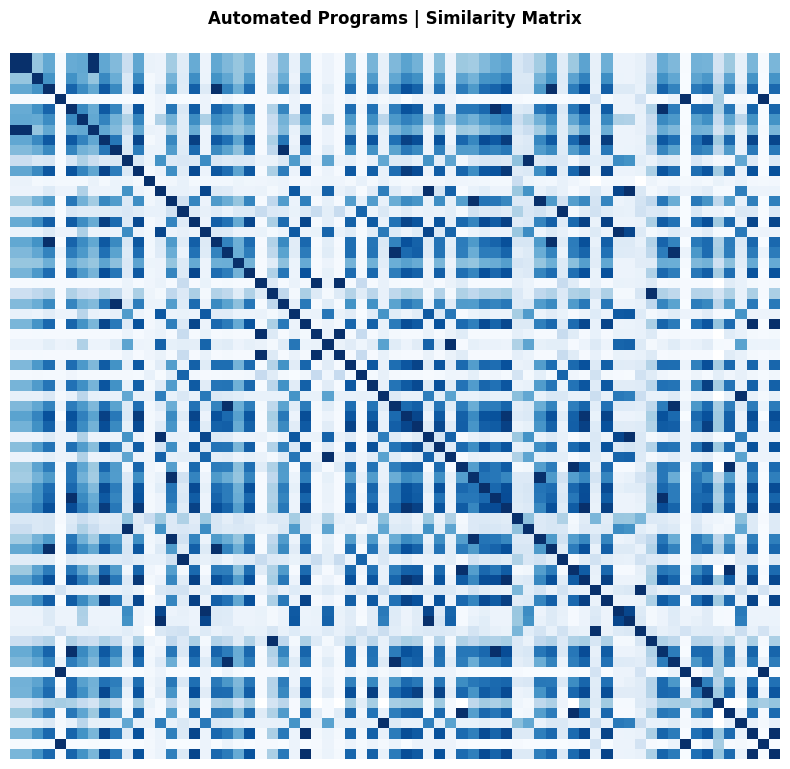

In [299]:
name_to_idx = {fn.__name__: i for i, fn in enumerate(programs)}
new_order = [name_to_idx[name] for group in groups for name in group]
S_grouped = S[np.ix_(new_order, new_order)]
# S_grouped = np.load("data/similarity_matrix_auto.npy")
colors = "Blues_r"
fig, ax = plt.subplots(1, 1, figsize=(8,8))
im2 = ax.imshow(S_grouped, cmap=colors, aspect='auto')
# ax.set_axis_off()
# ax.set_xticks(range(len(programs)))
# ax.set_yticks(range(len(programs)))
# ax.set_xticklabels([p.__name__ for p in programs], rotation=90)
# ax.set_yticklabels([p.__name__ for p in programs])
# axis off
ax.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.title("Automated Programs | Similarity Matrix\n", weight='bold')
plt.show()

In [ ]:
# automated_program_similarity_analysis

import os
import importlib.util
import types
# from AutoTokenizer import AutoTokenizer
import numpy as np

folder = "automation_results_bert"
programs = []
for layer in range(12):
    for head in range(12):
        code_path = os.path.join(folder, "llm_code", f"programs-layer_{layer}", f"{head}_output.py")
        if os.path.exists(code_path):
            spec = importlib.util.spec_from_file_location(f"layer{layer}_head{head}", code_path)
            module = importlib.util.module_from_spec(spec)
            module.__dict__['np'] = np
            try:
                spec.loader.exec_module(module)
                for attr_name in dir(module):
                    attr = getattr(module, attr_name)
                    if isinstance(attr, types.FunctionType):
                        programs.append(attr)
                        break
            except Exception as e:
                print(f"Error loading program for Layer {layer}, Head {head}: {e}")
                continue

# sentence_data = sentences[:10]
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# def program_similarity(att_one, att_two):
#     def js_divergence(p: np.ndarray, q: np.ndarray) -> float:
#         p = np.clip(p, 1e-12, 1.0)
#         q = np.clip(q, 1e-12, 1.0)
#         p /= p.sum()
#         q /= q.sum()
#         m = 0.5 * (p + q)
#         return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m))) 

#     jensonshannon_distances = []
#     for row_att, row_out in zip(att_one, att_two):
#         jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
#     score = np.mean(jensonshannon_distances)
#     return score

# x = len(programs)
# S = np.zeros((x, x))
# for i in range(x):
#     print(f"calculating hypothesis similarities [{i}]: {programs[i].__name__}")
#     for j in range(x):
#         if j % 24 == 0: print(f"  inner loop {j}/{x}")
#         if i != j:
#             similarities = []
#             program_one = programs[i]
#             program_two = programs[j]

#             for sentence in sentence_data:
#                 h1, activations_one = program_one(sentence, tokenizer)
#                 h2, activations_two = program_two(sentence, tokenizer)
#                 similarities.append(program_similarity(activations_one, activations_two))
            
#             S[i, j] = np.mean(similarities)

<div style="text-align: center; font-size: 2em;">
  <hr>
    Hypothesis Replacement Experiments
  <hr>
</div>

In [1]:
from programs import *
from transformers import BertTokenizer, BertForMaskedLM

programs = [next_attention, previous_attention, same_attention, punctuation_attention, dependencies,
            last_token_attention, uniform_attention, cls_attention, eos_attention, pos_alignment,
            special_token_attention, repeated_attention, noun_modifier_attention, pronoun_attention,
            single_token_attention, root_cluster_attention]

use = "gpt-2"

if use == "bert":
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForMaskedLM.from_pretrained("bert-base-uncased")
    model_replace = BertForMaskedLM.from_pretrained("bert-base-uncased")

elif use == "gpt-2":
    from transformers import GPT2Tokenizer, GPT2LMHeadModel
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    model = GPT2LMHeadModel.from_pretrained("gpt2")

    remove = [next_attention, dependencies, last_token_attention, eos_attention, pos_alignment, root_cluster_attention]
    programs = [p for p in programs if p not in remove]
    model_replace = GPT2LMHeadModel.from_pretrained("gpt2")

model.eval()
model_replace.eval()

c:\Users\amkah\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [24]:
# helper functions for replacing heads in llms

def has_hooks(model):
    # sanity check to see if any hooks are registered
    for module in model.modules():
        if module._forward_hooks or module._backward_hooks or module._forward_pre_hooks:
            return True
    return False

def remove_all_hooks(model):
    for module in model.modules():
        module._forward_hooks = {}
        module._backward_hooks = {}
        module._forward_pre_hooks = {}
    worked = has_hooks(model)
    print(f"All hooks removed: {not worked}")
    return model

def get_hypothesis_head(layer, head, sentence, tokenizer):
    hypothesis = best_fit_data.get((layer, head), (None, None))[0]
    program_to_use = programs[[i for i, p in enumerate(executables) if p.__name__ == hypothesis][0]] if hypothesis else None
    # print(f"Replacing Layer {layer}, Head {head} with Hypothesis: {hypothesis} | program: {program_to_use}")
    out = program_to_use(sentence, tokenizer) if program_to_use else None
    return out

In [ ]:
def generate_hypothesis_dictionary(model, tokenizer, sentences):
    if use == "gpt-2": best_fit_data = pd.read_csv('data/best_fit_refinement_gpt2_new.csv') # i, j, pattern, score
    else: best_fit_data = pd.read_csv('data/best_fit_refinement_bert.csv') # i, j, pattern, score
    hypothesis_dict = {} # (layer, head) -> (hypothesis, score)
    for row in best_fit_data.itertuples():
        layer = row.i
        head = row.j
        hypothesis = row.Pattern
        # hypothesis_dict[(layer, head)] = hypothesis
        # attach hypothesis to dict if it's the lowest score for that head
        if (layer, head) not in hypothesis_dict:
            hypothesis_dict[(layer, head)] = (hypothesis, row.Score)
        else:
            if row.Score < hypothesis_dict[(layer, head)][1]:
                hypothesis_dict[(layer, head)] = (hypothesis, row.Score)
    
    # collect hypothesis names set and define program_executables list
    program_executables = []
    hypothesis_names = set()
    for key in hypothesis_dict: hypothesis_names.add(hypothesis_dict[key][0])

    for name in hypothesis_names:
        flag = False
        for program in programs:
            if program.__name__ == name:
                program_executables.append(program)
                flag = True
                break
        if not flag:
            print(f"Program {name} not found among available programs.")

    print(f"\nNumber of Heads with Hypotheses: {len(hypothesis_dict)}")
    print(f"Percentage of Heads with Hypotheses: {len(hypothesis_dict) / 144 * 100:.2f}%")
    print(f"Number of Program Executables: {len(program_executables)}\n")
    return hypothesis_dict, program_executables

best_fits, programs_ex = generate_hypothesis_dictionary(model, tokenizer, sentences)
print([program.__name__ for program in programs_ex])
best_fits

In [ ]:
top_percentage = 1.0
best_fits_sorted = sorted(best_fits.items(), key=lambda x: x[1][1])
best_fits_top = best_fits_sorted[:int(len(best_fits_sorted) * top_percentage)]
names_programs = set([item[1][0] for item in best_fits_top])
print(f"Set of {len(names_programs)} programs: {names_programs}")

best_fits_top

In [73]:
len(best_fits_top)

54

In [457]:
if use == "bert":
    def mask_sentence(sent, tokenizer):
        tokens = tokenizer.tokenize(sent)
        if not tokens:
            return sent
        idx = np.random.randint(len(tokens))
        true_token = tokens[idx]
        tokens[idx] = tokenizer.mask_token
        return tokenizer.convert_tokens_to_string(tokens), true_token

    masked_sentences = []
    true_tokens = []
    for i, sent in enumerate(sentences):
        masked_sent, true_token = mask_sentence(sent, tokenizer)
        if i < 6: print(f"Original: {sent}\nMasked:   {masked_sent}\n")
        masked_sentences.append(masked_sent)
        true_tokens.append(true_token)

Original: One day, a little girl named Lily found a needle in her room.
Masked:   one day , a little girl named lily found a needle in her room [MASK]

Original: She knew it was difficult to play with it because it was sharp.
Masked:   she knew it was difficult to play with it because [MASK] was sharp .

Original: Lily wanted to share the needle with her mom, so she could sew a button on her shirt.
Masked:   lily wanted to share the [MASK] with her mom , so she could sew a button on her shirt .

Original: Lily went to her mom and said, "Mom, I found this needle.
Masked:   lily went to her mom and said , " mom , [MASK] found this needle .

Original: Can you share it with me and sew my shirt?"
Masked:   can you [MASK] it with me and sew my shirt ? "

Original: Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."
Masked:   her mom smiled and said , " yes , [MASK] , we can share the needle and fix your shirt . "



In [11]:
def cut_sentence_randomly(sent):
    len_sent = len(sent.split())
    word_idx = np.random.randint(3, len_sent - 1)
    # get the first part of the sentence up to word_idx
    first_part = " ".join(sent.split()[:word_idx])
    return first_part

example_sentence = "one two three four five six seven eight nine ten"
print(len(example_sentence.split()))
print(np.random.randint(3, len(example_sentence.split()) - 1))
cut_sentence_randomly(example_sentence)

10
4


'one two three four five'

In [14]:
def decoder_model_perplexity(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss
    return torch.exp(loss).item()

for i, sent in enumerate(sentences[:5]):
    ppl = decoder_model_perplexity(sent)
    print(f"Sentence {i} Perplexity: {ppl:.2f}")

Sentence 0 Perplexity: 28.04
Sentence 1 Perplexity: 30.17
Sentence 2 Perplexity: 37.61
Sentence 3 Perplexity: 24.69
Sentence 4 Perplexity: 90.55


In [16]:
import torch
import numpy as np

def prepare_sentence(sent, mode="random"):
    words = sent.split()
    if len(words) <= 3:
        return sent
        
    if mode == "random":
        # Cut at a random spot
        idx = np.random.randint(3, len(words))
        return " ".join(words[:idx])
    elif mode == "last_word":
        # Return the whole sentence except the very last word
        return " ".join(words[:-1])
    else:
        return sent

def analyze_predictions(sentence_to_use):
    inputs = tokenizer(sentence_to_use, return_tensors="pt")
    input_ids = inputs["input_ids"][0]
    
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
 
    logits = outputs.logits[0] 
    predicted_ids = torch.argmax(logits, dim=-1)

    print(f"--- Analysis ---")
    print(f"Input: {sentence_to_use}")
   
    for i in range(len(input_ids) - 1):
        actual_next_token = tokenizer.decode(input_ids[i+1])
        predicted_next_token = tokenizer.decode(predicted_ids[i])
        
        actual = actual_next_token.strip()
        pred = predicted_next_token.strip()
        
        print(f"Token {i}: Actual: '{actual}' | Model Predicted: '{pred}'")

    final_prediction = tokenizer.decode(predicted_ids[-1])
    print(f"Prediction for NEXT word: '{final_prediction.strip()}'")
    # print(f"Perplexity: {decoder_model_perplexity(sentence_to_use):.2f}")
    print(f"Perplexity: {torch.exp(outputs.loss).item():.2f}\n")

for sent in sentences[:5]:
    cut_sent = prepare_sentence(sent, mode="last_word") # or "random"
    analyze_predictions(cut_sent)

--- Analysis ---
Input: One day, a little girl named Lily found a needle in her
Token 0: Actual: 'day' | Model Predicted: 'of'
Token 1: Actual: ',' | Model Predicted: ','
Token 2: Actual: 'a' | Model Predicted: 'I'
Token 3: Actual: 'little' | Model Predicted: 'group'
Token 4: Actual: 'girl' | Model Predicted: 'girl'
Token 5: Actual: 'named' | Model Predicted: 'named'
Token 6: Actual: 'Lily' | Model Predicted: 'K'
Token 7: Actual: 'found' | Model Predicted: 'was'
Token 8: Actual: 'a' | Model Predicted: 'herself'
Token 9: Actual: 'needle' | Model Predicted: 'book'
Token 10: Actual: 'in' | Model Predicted: 'in'
Token 11: Actual: 'her' | Model Predicted: 'her'
Prediction for NEXT word: 'hair'
Perplexity: 25.77

--- Analysis ---
Input: She knew it was difficult to play with it because it was
Token 0: Actual: 'knew' | Model Predicted: ','
Token 1: Actual: 'it' | Model Predicted: 'that'
Token 2: Actual: 'was' | Model Predicted: 'was'
Token 3: Actual: 'difficult' | Model Predicted: 'a'
Token 4

In [28]:
sentences[4]

'Can you share it with me and sew my shirt?"'

In [458]:
def single_perplexity(sentence, true_token):
    inputs = tokenizer(sentence, return_tensors="pt")
    mask_token_index = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)
    if len(mask_token_index[0]) == 0:
        raise ValueError(f"No [MASK] token found in: {sentence}")
    with torch.no_grad():
        logits = model(**inputs).logits  # shape: [1, seq_len, vocab_size]
    mask_pos = mask_token_index[1].item()
    masked_logits = logits[0, mask_pos, :]  # shape: [vocab_size]
    true_id = tokenizer.convert_tokens_to_ids(true_token)
    log_probs = torch.log_softmax(masked_logits, dim=-1)
    log_prob = log_probs[true_id] 
    return torch.exp(-log_prob).item()

def full_perplexity(sentence):
    tokens = tokenizer.tokenize(sentence)
    ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = torch.tensor([ids])
    log_probs = []
    for i in range(1, len(tokens)-1):  # consider all tokens except [CLS], [SEP]
        masked = input_ids.clone()
        masked[0, i] = tokenizer.mask_token_id
        with torch.no_grad():
            logits = model(masked).logits
        prob = torch.log_softmax(logits[0, i], dim=-1)[input_ids[0, i]]
        log_probs.append(prob)
    return torch.exp(-torch.stack(log_probs).mean())

average_ppl_single = []
average_ppl_full = []
for i, (sent, true_tok) in enumerate(zip(masked_sentences[:100], true_tokens[:100])):
    ppl_s = single_perplexity(sent, true_tok)
    ppl_f = full_perplexity(sent)
    average_ppl_single.append(ppl_s)
    average_ppl_full.append(ppl_f)
    if i % 50 == 0: print(f"Sentence {i}:\tPerplexity(s): {ppl_s:.3f}\tPerplexity(f): {ppl_f:.3f}")

Sentence 0:	Perplexity(s): 1.010	Perplexity(f): 19.637
Sentence 50:	Perplexity(s): 1.009	Perplexity(f): 69.698


In [460]:
print(f"\nMeans: Single Token Perplexity: {np.mean(average_ppl_single):.3f}, Full Sentence Perplexity: {np.mean(average_ppl_full):.3f}")
print(f"Medians: Single Token Perplexity: {np.median(average_ppl_single):.3f}, Full Sentence Perplexity: {np.median(average_ppl_full):.3f}")
print(f"Stds: Single Token Perplexity: {np.std(average_ppl_single):.3f}, Full Sentence Perplexity: {np.std(average_ppl_full):.3f}")


Means: Single Token Perplexity: 18322.788, Full Sentence Perplexity: 779.835
Medians: Single Token Perplexity: 1.111, Full Sentence Perplexity: 109.221
Stds: Single Token Perplexity: 138849.665, Full Sentence Perplexity: 3437.880


In [122]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
# BERT HOOKS

def register_hypothesis_hooks(model, best_fits, tokenizer):
    hooks = []
    def replace_activation_with_hypothesis(layer, head, sentence, tokenizer):
        hypothesis = best_fits.get((layer, head), (None, None))[0]
        program_to_use = programs_ex[[i for i, p in enumerate(programs_ex) if p.__name__ == hypothesis][0]] if hypothesis else None
        # print(f"Replacing Layer {layer}, Head {head} with Hypothesis: {hypothesis} | program: {program_to_use}")
        out = program_to_use(sentence, tokenizer) if program_to_use else None
        return out

    for (layer_idx, head_idx) in best_fits:
        target_layer = model.bert.encoder.layer[layer_idx].attention.self

        def make_hook(layer_i, head_i):
            def hook_fn(module, input, output):
                context_layer, attn_probs = output
                print(context_layer.shape)
                # B, S, H, D = context_layer.shape  # (batch, seq_len, num_heads, head_dim)

                # sentence = tokenizer.decode(input[0][0], skip_special_tokens=True)
                token_ids = inputs["input_ids"][0] 
                sentence = tokenizer.decode(token_ids, skip_special_tokens=True)
                out = replace_activation_with_hypothesis(layer_i, head_i, sentence, tokenizer)  # shape (S, S)

                # project (S, S) → (B, S, D)
                D = context_layer.size(-1)
                rand_head = out.unsqueeze(0).repeat(B, 1, 1)[:, :, :D]
                context_layer[:, :, head_i, :] = rand_head
                return (context_layer, attn_probs)
            return hook_fn

        hook = target_layer.register_forward_hook(make_hook(layer_idx, head_idx))
        hooks.append(hook)
    return hooks

hooks = register_hypothesis_hooks(
    model_replace,
    best_fits=best_fits,
    tokenizer=tokenizer
)

function_initialization_attention
identify_function_declarations
function_boundary_detection
function_call_contextualization
function_structure_attention
func_def_start_attention
function_header_pattern
function_declaration_attention
header_token_emphasis
local_context_attention


In [64]:
# check that all heads present in best_fits_data
missing_heads = []
for layer in range(12):
    for head in range(12):
        if (layer, head) not in best_fits:
            missing_heads.append((layer, head))

print(f"Missing Heads: {missing_heads}")

Missing Heads: [(0, 4), (2, 4), (3, 2), (3, 7), (3, 8), (3, 9), (4, 3), (4, 7)]


In [ ]:
best_fits_top

In [112]:
head = 5
layer = 1

# best_fits_top = [((layer, head), (hypothesis, score)), ...]

# relevant_rows = best_fits_top[[best_fits_top[i][0][0] == layer and best_fits_top[i][0][1] == head for i in range(len(best_fits_top))]]
relevant_row = [item for item in best_fits_top if item[0] == (layer, head)]
program_name = relevant_row[0][1][0]
index_program = [i for i, p in enumerate(executables) if p.__name__ == program_name][0]
program_to_use = executables[index_program]
print(relevant_row)
print(f"Program to use for Layer {layer}, Head {head}: {program_to_use}"    )

[((1, 5), ('sentence_position_preference', 0.4012687165249795))]
Program to use for Layer 1, Head 5: <function sentence_position_preference at 0x000001BC9B0E6340>


In [108]:
any([p.__name__ == "sentence_position_preference" for p in executables])

True

In [117]:
(4,11) in [item[0] for item in best_fits_top]

True

In [ ]:
#GPT-2 working

for num_heads_to_replace in range(1, 11):
    # remove hooks from model_replace
    from collections import OrderedDict
    def remove_all_hooks(model):
        for module in model.modules():
            # Use OrderedDict to keep PyTorch happy
            module._forward_hooks = OrderedDict()
            module._backward_hooks = OrderedDict()
            module._forward_pre_hooks = OrderedDict()
        return model
    model_replace = remove_all_hooks(model_replace)

    # best_fit_data = pd.read_csv('data/best_fit_refinement_gpt2_new.csv') # i, j, pattern, score
    gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2")
    def get_hypothesis_head(layer, head, sentence, tokenizer):
        if (layer, head) not in [item[0] for item in best_fits_top]:
            print(f"No hypothesis for Layer {layer}, Head {head}")
            return None, None
        
        # relevant_rows = best_fit_data[(best_fit_data['i'] == layer) & (best_fit_data['j'] == head)]
        # max_row = relevant_rows.loc[relevant_rows['Score'].idxmax()]
        # hypothesis = max_row['Pattern']
        # index_program = [p.__name__ == hypothesis for p in executables].index(True)
        # program_to_use = executables[index_program]

        relevant_row = [item for item in best_fits_top if item[0] == (layer, head)]
        program_name = relevant_row[0][1][0]
        index_program = [i for i, p in enumerate(executables) if p.__name__ == program_name][0]
        program_to_use = executables[index_program]

        name, out = program_to_use(sentence, gpt_tokenizer)  
        return name, out 

    def register_hypothesis_hooks(model, best_fits, tokenizer):
        hooks = []
        
        def replace_activation_with_hypothesis(layer, head, sentence, tokenizer):
            hypothesis = best_fits.get((layer, head), (None, None))[0]
            # Assuming programs_ex is defined in your global scope
            program_to_use = next((p for p in programs_ex if p.__name__ == hypothesis), None)
            return program_to_use(sentence, tokenizer) if program_to_use else None

        for (layer_idx, head_idx) in best_fits:
            # 1. Dynamically find the layer
            if hasattr(model, "transformer"): # GPT-2 style
                target_layer = model.transformer.h[layer_idx].attn
                is_gpt = True
            elif hasattr(model, "bert"): # BERT style
                target_layer = model.bert.encoder.layer[layer_idx].attention.self
                is_gpt = False
            else:
                raise ValueError("Unsupported model architecture")

            def make_hook(layer_i, head_i, is_gpt_model):
                def hook_fn(module, input, output):
                    # GPT-2 output is often (hidden_states, presents, attentions)
                    # BERT output is (hidden_states, attentions)
                    context_layer = output[0] 
                    
                    # Input tokens are usually the first element of the input tuple
                    # Handle potential padding/batching
                    input_ids = input[0][0]
                    sentence = tokenizer.decode(input_ids, skip_special_tokens=True)
                    
                    new_attn_map = replace_activation_with_hypothesis(layer_i, head_i, sentence, tokenizer)

                    if new_attn_map is not None:
                        # Logic to project your hypothesis back into the context_layer
                        # Note: context_layer shape for GPT2 is (Batch, Seq, Hidden) 
                        # but internal heads are often reshaped. 
                        B, S, D = context_layer.shape
                        num_heads = model.config.n_head if is_gpt_model else model.config.num_attention_heads
                        head_dim = D // num_heads
                        
                        # Reshape to manipulate specific head: (B, S, N, H)
                        context_layer = context_layer.view(B, S, num_heads, head_dim)
                        
                        # Your projection logic (simplified example)
                        # Ensure new_attn_map matches dimensions or use it to weight Values
                        # For now, following your pattern:
                        rand_head = new_attn_map.unsqueeze(0).repeat(B, 1, 1)[:, :, :head_dim]
                        context_layer[:, :, head_i, :] = rand_head
                        
                        # Reshape back to original
                        context_layer = context_layer.view(B, S, D)

                    # Return the modified tuple (must match original length)
                    new_output = list(output)
                    new_output[0] = context_layer
                    return tuple(new_output)
                    
                return hook_fn

            hook = target_layer.register_forward_hook(make_hook(layer_idx, head_idx, is_gpt))
            hooks.append(hook)
            
        return hooks

    def replace_attention_head_gpt2(module, input, output):
        # GPT-2 hook 'output' is a tuple: (hidden_states, presents, optional_attentions)
        context_layer = output[0]
        
        # We need to know how many heads to reshape. 
        # Since GPT2Attention doesn't always store n_head as a top-level attr, 
        # we can use the config or infer it.
        batch, seq_len, hidden_dim = context_layer.shape
        
        # Standard GPT-2 Base has 12 heads. Use config if available:
        # num_heads = model_replace.config.n_head 
        num_heads = 12 
        head_dim = hidden_dim // num_heads
        
        # Reshape: (B, S, D) -> (B, S, N, H)
        context_layer = context_layer.view(batch, seq_len, num_heads, head_dim)
        context_layer = context_layer.permute(0, 2, 1, 3)

        # Randomly zero out 2 heads
        # random_heads = np.random.choice(range(num_heads), size=1, replace=False)
        # random_heads = np.arange(num_heads_to_replace)
        # eye_matrix = torch.zeros((seq_len, seq_len))
        modified_context = context_layer.clone()

        current_layer = module.layer_id
        # current_head = None
        # current_sentence = None
        # hypothesis_matrix = get_hypothesis_head(current_layer, current_head, current_sentence, tokenizer)
        current_sentence = tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)
        # print(f"Replacing Heads {random_heads} in Layer {module.layer_id} for Sentence: {current_sentence}")
        for current_head in range(12):
            specific_head = (current_layer, current_head)
            replacing = [item for item in top_fitting_heads_to_replace if item[0] == specific_head]

            if replacing:
                hypothesis_name, hypothesis_matrix = get_hypothesis_head(current_layer, current_head, current_sentence, tokenizer)
                # hypothesis_matrix = torch.tensor(hypothesis_matrix, dtype=torch.float32)

                if hypothesis_matrix is None: continue

                # seq_len from current_sentence
                # seq_len = len(tokenizer.tokenize(current_sentence))
                # hypothesis_matrix = torch.diag(torch.ones(seq_len))
                hypothesis_matrix = torch.zeros((seq_len, seq_len))
                # print("--------------------------------")
                # print(replacing)
                # print(hypothesis_name)
                # print("--------------------------------")

                context_layer[:, current_head, :, :] = torch.matmul(hypothesis_matrix, context_layer[:, current_head, :, :])

        # Create a copy or modify in place (be careful with in-place in hooks)
        modified_context = context_layer.clone()
        # for i in random_heads:
            # modified_context[:, :, i, :] = 0
            # context_layer[:, i, :, :] = torch.matmul(hypothesis_matrix, context_layer[:, i, :, :])
        
        # Reshape back: (B, S, N, H) -> (B, S, D)
        modified_context = context_layer.permute(0, 2, 1, 3).contiguous()
        modified_context = modified_context.view(batch, seq_len, hidden_dim)
        
        # Reconstruct the output tuple
        new_output = list(output)
        new_output[0] = modified_context
        return tuple(new_output)
    
    top_fitting_heads_to_replace = best_fits_top[:(num_heads_to_replace*12)]

    # Registration Loop for GPT-2
    for layer_number, layer in enumerate(model_replace.transformer.h):
        # Access the correct attribute: .attn instead of .attention.self
        target_module = layer.attn 
        # Add metadata if you need it inside the hook
        target_module.layer_id = layer_number
        # Register the hook
        target_module.register_forward_hook(replace_attention_head_gpt2)

    for sent in tqdm(sentences[:100]):
        regular_perplexities = []
        replaced_perplexities = []

        cut_sent = prepare_sentence(sent, mode="last_word") # or "random"
        inputs = tokenizer(cut_sent, return_tensors="pt")
        with torch.no_grad():
            if num_heads_to_replace == 1: outputs_regular = model(**inputs, labels=inputs["input_ids"])
            outputs_replaced = model_replace(**inputs, labels=inputs["input_ids"])
        ppl_regular = torch.exp(outputs_regular.loss).item()
        ppl_replaced = torch.exp(outputs_replaced.loss).item()

        display = False
        if display:
            print(f"Sentence: {cut_sent}")
            print(f"\tRegular Model Perplexity: {ppl_regular:.2f}")
            print(f"\tReplaced Model Perplexity: {ppl_replaced:.2f}\n")
        
        regular_perplexities.append(ppl_regular)
        replaced_perplexities.append(ppl_replaced)

    increase_percentage = [(replaced - normal)/normal * 100 for replaced, normal in zip(replaced_perplexities, regular_perplexities)]
    mean_increase = np.mean(increase_percentage)
    print(f"Mean Perplexity Increase after Head Replacement ({num_heads_to_replace}): {mean_increase:.0f}%")

In [ ]:
num_heads_to_replace = 1
top_fitting_heads_to_replace = best_fits_top[:(num_heads_to_replace*12)]

def js_divergence(p: np.ndarray, q: np.ndarray) -> float:
    # p = np.clip(p, 1e-12, 1.0)
    # q = np.clip(q, 1e-12, 1.0)
    p /= p.sum()
    q /= q.sum()
    m = 0.5 * (p + q)
    return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m)))

# model is gpt-2
model = AutoModel.from_pretrained("openai-community/gpt2", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")

for item in top_fitting_heads_to_replace:
    # calculate difference between hypothesis similarity matrix and real similarity np_saved_matrix
    difference = []

    layer, head = item[0]
    hypothesis_name = item[1][0]

    for sentence in sentences[100]:
        # manually get activation matrix at head
        tokens = tokenizer(sentence, return_tensors="pt")

        # torch_model = model.eval()
        att = model(**tokens, output_attentions=True).attentions[layer][0, head].detach().numpy()
        name, pred_att = get_hypothesis_head(layer, head, sentence, tokenizer)

        jensonshannon_distances = []
        for row_att, row_out in zip(att, pred_att):
            jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
        score = np.mean(jensonshannon_distances)
        difference.append(score)
    
    print(f"Layer {layer}, Head {head}, Hypothesis: {hypothesis_name}, Avg JS Divergence: {np.mean(difference):.4f}")

In [135]:
model(**tokens, output_attentions=True).attentions[layer][0, head].detach().numpy()

array([[1.]], dtype=float32)

In [131]:
outputs.attentions

(None, None, None, None, None, None, None, None, None, None, None, None)

In [ ]:
# 100%|██████████| 100/100 [00:12<00:00,  8.14it/s]
# Mean Perplexity Increase after Head Replacement (1): 2%
# 100%|██████████| 100/100 [00:07<00:00, 12.55it/s]
# Mean Perplexity Increase after Head Replacement (2): 26%
# 100%|██████████| 100/100 [00:06<00:00, 14.37it/s]
# Mean Perplexity Increase after Head Replacement (3): 38%
# 100%|██████████| 100/100 [00:07<00:00, 13.12it/s]
# Mean Perplexity Increase after Head Replacement (4): 63%
# 100%|██████████| 100/100 [00:07<00:00, 13.34it/s]
# Mean Perplexity Increase after Head Replacement (5): 88%
# 100%|██████████| 100/100 [00:08<00:00, 11.88it/s]
# Mean Perplexity Increase after Head Replacement (6): 100%
# 100%|██████████| 100/100 [00:07<00:00, 13.45it/s]
# Mean Perplexity Increase after Head Replacement (7): 123%
# 100%|██████████| 100/100 [00:07<00:00, 12.80it/s]
# Mean Perplexity Increase after Head Replacement (8): 319%
# 100%|██████████| 100/100 [00:08<00:00, 12.44it/s]
# Mean Perplexity Increase after Head Replacement (9): 389%
# 100%|██████████| 100/100 [00:08<00:00, 12.14it/s]
# Mean Perplexity Increase after Head Replacement (10): 811%

# 3%
# Mean Perplexity Increase after Head Replacement (2): 16%
# 100%|██████████| 1400/1400 [01:36<00:00, 14.51it/s]
# Mean Perplexity Increase after Head Replacement (3): 21%
# 100%|██████████| 1400/1400 [01:42<00:00, 13.63it/s]
# Mean Perplexity Increase after Head Replacement (4): 37%
#  30%|██▉       | 418/1400 [00:31<01:14, 13.17it/s]

# 100%|██████████| 100/100 [00:12<00:00,  7.87it/s]
# Mean Perplexity Increase after Head Replacement (1): 6%
# 100%|██████████| 100/100 [00:07<00:00, 13.34it/s]
# Mean Perplexity Increase after Head Replacement (2): 3216%
# 100%|██████████| 100/100 [00:08<00:00, 12.28it/s]
# Mean Perplexity Increase after Head Replacement (3): 3462%
# 100%|██████████| 100/100 [00:08<00:00, 11.31it/s]
# Mean Perplexity Increase after Head Replacement (4): 3703%
# 100%|██████████| 100/100 [00:09<00:00, 11.09it/s]
# Mean Perplexity Increase after Head Replacement (5): 3832%
# 100%|██████████| 100/100 [00:08<00:00, 11.35it/s]
# Mean Perplexity Increase after Head Replacement (6): 3952%
# 100%|██████████| 100/100 [00:09<00:00, 10.14it/s]
# Mean Perplexity Increase after Head Replacement (7): 5380%
# 100%|██████████| 100/100 [00:09<00:00, 10.75it/s]
# Mean Perplexity Increase after Head Replacement (8): 5545%
# 100%|██████████| 100/100 [00:09<00:00, 10.06it/s]
# Mean Perplexity Increase after Head Replacement (9): 5758%
# 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]
# Mean Perplexity Increase after Head Replacement (10): 6046%

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])

In [99]:
best_fits_top[:(num_heads_to_replace*12)][0][1][0]

'cls_attention'

In [82]:
num_heads_to_replace = 1
top_fitting_heads_to_replace = best_fits_top[:(num_heads_to_replace*12)]
# print(top_fitting_heads_to_replace)

# (5, 1) in top_fitting_heads_to_replace
# search for (5, 1) in nested top_fitting_heads_to_replace
# e.g. [((5, 1), ('cls_attention', 0.0307966296468495)), ((4, 11), ('previous_attention', 0.0437074035846249)), ((7, 2), ('cls_attention', 0.0522305542941697)), ((6, 9), ('cls_attention', 0.067090146229909)), ((9, 9), ('sentence_beginning_salience', 0.0714835655208253)), ((7, 10), ('sentence_beginning_salience', 0.0830397222865371)), ((9, 6), ('sentence_beginning_salience', 0.0894682433938373)), ((10, 10), ('sentence_beginning_salience', 0.1012886946707291)), ((10, 8), ('sentence_beginning_salience', 0.1075558946310822)), ((9, 11), ('sentence_beginning_salience', 0.1077038776010236)), ((8, 1), ('sentence_beginning_salience', 0.1125680346921121)), ((10, 6), ('sentence_beginning_salience', 0.1145507290046831))]

# found = False
# for item in top_fitting_heads_to_replace:
#     if item[0] == (5, 1):
#         found = True
#         print(item)
#         break

# list comprehension
specific_head = (5, 1)
found = [item for item in top_fitting_heads_to_replace if item[0] == specific_head]
print(found)




[((5, 1), ('cls_attention', 0.0307966296468495))]


In [ ]:
# 100%|██████████| 10/10 [00:01<00:00,  6.85it/s]
# Mean Perplexity Increase after Head Replacement (1): 6%
# 100%|██████████| 10/10 [00:00<00:00, 14.48it/s]
# Mean Perplexity Increase after Head Replacement (2): 16%
# 100%|██████████| 10/10 [00:00<00:00, 15.13it/s]
# Mean Perplexity Increase after Head Replacement (3): 28%
# 100%|██████████| 10/10 [00:00<00:00, 14.42it/s]
# Mean Perplexity Increase after Head Replacement (4): 35%
# 100%|██████████| 10/10 [00:00<00:00, 14.82it/s]
# Mean Perplexity Increase after Head Replacement (5): 51%
# 100%|██████████| 10/10 [00:00<00:00, 13.64it/s]
# Mean Perplexity Increase after Head Replacement (6): 68%
# 100%|██████████| 10/10 [00:00<00:00, 12.02it/s]
# Mean Perplexity Increase after Head Replacement (7): 142%
# 100%|██████████| 10/10 [00:00<00:00, 13.71it/s]
# Mean Perplexity Increase after Head Replacement (8): 247%
# 100%|██████████| 10/10 [00:00<00:00, 18.09it/s]
# Mean Perplexity Increase after Head Replacement (9): 301%
# 100%|██████████| 10/10 [00:00<00:00, 15.46it/s]
# Mean Perplexity Increase after Head Replacement (10): 341%

# 100%|██████████| 50/50 [00:05<00:00,  8.60it/s]
# Mean Perplexity Increase after Head Replacement (2): 9%
# 100%|██████████| 50/50 [00:05<00:00,  8.78it/s]
# Mean Perplexity Increase after Head Replacement (3): 5%
# 100%|██████████| 50/50 [00:05<00:00,  9.01it/s]
# Mean Perplexity Increase after Head Replacement (4): -4%
# 100%|██████████| 50/50 [00:05<00:00,  9.60it/s]
# Mean Perplexity Increase after Head Replacement (5): -5%
# 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]
# Mean Perplexity Increase after Head Replacement (6): -10%
# 100%|██████████| 50/50 [00:05<00:00,  9.68it/s]
# Mean Perplexity Increase after Head Replacement (7): 62%
# 100%|██████████| 50/50 [00:05<00:00,  9.31it/s]
# Mean Perplexity Increase after Head Replacement (8): 147%
# 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]
# Mean Perplexity Increase after Head Replacement (9): 192%
# 100%|██████████| 50/50 [00:05<00:00,  9.90it/s]
# Mean Perplexity Increase after Head Replacement (10): 310%

# 100%|██████████| 300/300 [00:28<00:00, 10.51it/s]
# Mean Perplexity Increase after Head Replacement (2): 18%
# 100%|██████████| 300/300 [00:29<00:00, 10.29it/s]
# Mean Perplexity Increase after Head Replacement (3): 19%
# 100%|██████████| 300/300 [00:28<00:00, 10.48it/s]
# Mean Perplexity Increase after Head Replacement (4): 34%
# 100%|██████████| 300/300 [00:28<00:00, 10.49it/s]
# Mean Perplexity Increase after Head Replacement (5): 44%
# 100%|██████████| 300/300 [00:28<00:00, 10.35it/s]
# Mean Perplexity Increase after Head Replacement (6): 50%
# 100%|██████████| 300/300 [00:49<00:00,  6.09it/s]
# Mean Perplexity Increase after Head Replacement (7): 113%
# 100%|██████████| 300/300 [00:49<00:00,  6.02it/s]
# Mean Perplexity Increase after Head Replacement (8): 298%
# 100%|██████████| 300/300 [00:37<00:00,  7.93it/s]
# Mean Perplexity Increase after Head Replacement (9): 537%
# 100%|██████████| 300/300 [00:40<00:00,  7.49it/s]Mean Perplexity Increase after Head Replacement (10): 647%

In [499]:
# GPT-2

saved_perplexities = [0]

for num_heads_to_replace in range(2, 13):
    # remove hooks from model_replace
    from collections import OrderedDict
    def remove_all_hooks(model):
        for module in model.modules():
            # Use OrderedDict to keep PyTorch happy
            module._forward_hooks = OrderedDict()
            module._backward_hooks = OrderedDict()
            module._forward_pre_hooks = OrderedDict()
        return model
    model_replace = remove_all_hooks(model_replace)
    reset_hooks(model_replace)

    def register_hypothesis_hooks(model, best_fits, tokenizer):
        hooks = []
        
        def replace_activation_with_hypothesis(layer, head, sentence, tokenizer):
            hypothesis = best_fits.get((layer, head), (None, None))[0]
            # Assuming programs_ex is defined in your global scope
            program_to_use = next((p for p in programs_ex if p.__name__ == hypothesis), None)
            return program_to_use(sentence, tokenizer) if program_to_use else None

        for (layer_idx, head_idx) in best_fits:
            # 1. Dynamically find the layer
            if hasattr(model, "transformer"): # GPT-2 style
                target_layer = model.transformer.h[layer_idx].attn
                is_gpt = True
            elif hasattr(model, "bert"): # BERT style
                target_layer = model.bert.encoder.layer[layer_idx].attention.self
                is_gpt = False
            else:
                raise ValueError("Unsupported model architecture")

            def make_hook(layer_i, head_i, is_gpt_model):
                def hook_fn(module, input, output):
                    # GPT-2 output is often (hidden_states, presents, attentions)
                    # BERT output is (hidden_states, attentions)
                    context_layer = output[0] 
                    
                    # Input tokens are usually the first element of the input tuple
                    # Handle potential padding/batching
                    input_ids = input[0][0]
                    sentence = tokenizer.decode(input_ids, skip_special_tokens=True)
                    
                    new_attn_map = replace_activation_with_hypothesis(layer_i, head_i, sentence, tokenizer)

                    if new_attn_map is not None:
                        # Logic to project your hypothesis back into the context_layer
                        # Note: context_layer shape for GPT2 is (Batch, Seq, Hidden) 
                        # but internal heads are often reshaped. 
                        B, S, D = context_layer.shape
                        num_heads = model.config.n_head if is_gpt_model else model.config.num_attention_heads
                        head_dim = D // num_heads
                        
                        # Reshape to manipulate specific head: (B, S, N, H)
                        context_layer = context_layer.view(B, S, num_heads, head_dim)
                        
                        # Your projection logic (simplified example)
                        # Ensure new_attn_map matches dimensions or use it to weight Values
                        # For now, following your pattern:
                        rand_head = new_attn_map.unsqueeze(0).repeat(B, 1, 1)[:, :, :head_dim]
                        context_layer[:, :, head_i, :] = rand_head
                        
                        # Reshape back to original
                        context_layer = context_layer.view(B, S, D)

                    # Return the modified tuple (must match original length)
                    new_output = list(output)
                    new_output[0] = context_layer
                    return tuple(new_output)
                    
                return hook_fn

            hook = target_layer.register_forward_hook(make_hook(layer_idx, head_idx, is_gpt))
            hooks.append(hook)
            
        return hooks

    def replace_attention_head_gpt2(module, input, output):
        # GPT-2 hook 'output' is a tuple: (hidden_states, presents, optional_attentions)
        context_layer = output[0]
        
        # We need to know how many heads to reshape. 
        # Since GPT2Attention doesn't always store n_head as a top-level attr, 
        # we can use the config or infer it.
        batch, seq_len, hidden_dim = context_layer.shape
        
        # Standard GPT-2 Base has 12 heads. Use config if available:
        # num_heads = model_replace.config.n_head 
        num_heads = 12 
        head_dim = hidden_dim // num_heads
        
        # Reshape: (B, S, D) -> (B, S, N, H)
        context_layer = context_layer.view(batch, seq_len, num_heads, head_dim)

        # Randomly zero out 2 heads
        # random_heads = np.random.choice(range(num_heads), size=num_heads_to_replace, replace=False)
        random_heads = np.arange(num_heads_to_replace)
        
        # Create a copy or modify in place (be careful with in-place in hooks)
        modified_context = context_layer.clone()
        for head in random_heads:
            activation_hypothesis = np.zeros((seq_len, seq_len))
            # activation_hypothesis[0, 1:] = 1.0
            np.fill_diagonal(activation_hypothesis, 1.0)
            broadcasted_hypothesis = torch.matmul(
                torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
                context_layer[:, :, head, :]
            )
            modified_context[:, :, head, :] = broadcasted_hypothesis
        
        # Reshape back: (B, S, N, H) -> (B, S, D)
        modified_context = modified_context.view(batch, seq_len, hidden_dim)
        
        # Reconstruct the output tuple
        new_output = list(output)
        new_output[0] = modified_context
        return tuple(new_output)

    # Registration Loop for GPT-2
    for layer_number, layer in enumerate(model_replace.transformer.h):
        # Access the correct attribute: .attn instead of .attention.self
        target_module = layer.attn 
        # Add metadata if you need it inside the hook
        target_module.layer_id = layer_number
        # Register the hook
        target_module.register_forward_hook(replace_attention_head_gpt2)

    for sent in sentences[:20]:
        regular_perplexities = []
        replaced_perplexities = []

        cut_sent = prepare_sentence(sent, mode="last_word") # or "random"
        inputs = tokenizer(cut_sent, return_tensors="pt")
        with torch.no_grad():
            outputs_regular = model(**inputs, labels=inputs["input_ids"])
            outputs_replaced = model_replace(**inputs, labels=inputs["input_ids"])
        ppl_regular = torch.exp(outputs_regular.loss).item()
        ppl_replaced = torch.exp(outputs_replaced.loss).item()

        # print(f"Sentence: {cut_sent}")
        # print(f"\tRegular Model Perplexity: {ppl_regular:.2f}")
        # print(f"\tReplaced Model Perplexity: {ppl_replaced:.2f}\n")
        regular_perplexities.append(ppl_regular)
        replaced_perplexities.append(ppl_replaced)

    increase_percentage = [(replaced - normal)/normal * 100 for replaced, normal in zip(replaced_perplexities, regular_perplexities)]
    mean_increase = np.mean(increase_percentage)
    print(f"Mean Perplexity Increase after Head Replacement: {mean_increase:.0f}%")

    saved_perplexities.append(mean_increase)

Mean Perplexity Increase after Head Replacement: 0%
Mean Perplexity Increase after Head Replacement: 0%
Mean Perplexity Increase after Head Replacement: 0%
Mean Perplexity Increase after Head Replacement: 0%
Mean Perplexity Increase after Head Replacement: 0%


KeyboardInterrupt: 

In [206]:
saved_perplexities

[0,
 np.float64(13.468331430476793),
 np.float64(12121.705154301768),
 np.float64(956.3888354127499),
 np.float64(6819.311270452256),
 np.float64(5045.876015476382),
 np.float64(1623.6336675569014),
 np.float64(2139.4133751034897),
 np.float64(1219.3935297040264),
 np.float64(1419.6021359480858),
 np.float64(1182.8767641160343),
 np.float64(1789.8429820919291)]

In [208]:
seq_len = 10
activation_hypothesis = np.zeros((seq_len, seq_len))
np.fill_diagonal(activation_hypothesis, 1.0)
print(activation_hypothesis)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [191]:
text = """Mean Perplexity Increase after Head Replacement: 17%
Mean Perplexity Increase after Head Replacement: 23%
Mean Perplexity Increase after Head Replacement: 35%
Mean Perplexity Increase after Head Replacement: 28%
Mean Perplexity Increase after Head Replacement: 24%
Mean Perplexity Increase after Head Replacement: 23%
Mean Perplexity Increase after Head Replacement: 142%
Mean Perplexity Increase after Head Replacement: 105%
Mean Perplexity Increase after Head Replacement: 257%
Mean Perplexity Increase after Head Replacement: 2043%
Mean Perplexity Increase after Head Replacement: 2030%"""

list_ = [float(line.split(": ")[-1].strip("%")) for line in text.strip().split("\n")]
list_

[17.0, 23.0, 35.0, 28.0, 24.0, 23.0, 142.0, 105.0, 257.0, 2043.0, 2030.0]

In [201]:
del list

In [470]:
#BERT
def replace_attention_head(module, input, output):
    """ module: BertSelfAttention | output: tuple (context_layer, attention_probs)"""
    context_layer, attn_probs = output
    batch, seq_len, hidden_dim = context_layer.shape
    num_heads = module.num_attention_heads
    head_dim = hidden_dim // num_heads
    context_layer = context_layer.view(batch, seq_len, num_heads, head_dim)

    # print current sentence
    # print(f"Current Sentence: {inputs['input_ids']}")
    # decoded_sentence = tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)
    # print(f"Decoded Sentence: {decoded_sentence}")
    # decoded_sentence = tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)
    # decoded_sentences = tokenizer.batch_decode(inputs["input_ids"], skip_special_tokens=True)

    # for decoded_sentence in decoded_sentences:
        # print(f"Decoded Sentence: {decoded_sentence}")

    # layer_id = getattr(module, "layer_id", None)
    # heads = []
    # for (layer, head), (fn_name, score) in best_fits_top:
        # if layer == layer_id:
            # print(layer, head, fn_name)
            # heads.append(head)

    # zero_out = 10 # percent of all heads
    # random_heads = np.random.choice(range(num_heads), size=int(num_heads * zero_out / 100), replace=False)
    # random number from 1 to 100 (2 random numbers in a list)
    random_heads = np.random.choice(range(num_heads), size=1, replace=False)
    print(len(random_heads))
    for i in random_heads:
        context_layer[:, :, i, :] = 0

    # for head in heads:
        # activation_hypothesis = np.eye(seq_len)
        # _, activation_hypothesis = get_hypothesis_head(layer_id, head, decoded_sentence, tokenizer)
        # assert activation_hypothesis.shape == (seq_len, seq_len), f"Hypothesis shape {activation_hypothesis.shape} does not match expected {(seq_len, seq_len)} for '{decoded_sentence}'"

        # broadcasted_hypothesis = torch.matmul(
        #     torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
        #     context_layer[:, :, head, :]
        # )
        # context_layer[:, :, head, :] = broadcasted_hypothesis

    # if layer_id == 0:
    #     head = 6
    #     # uniform attention np
    #     activation_hypothesis = np.ones((seq_len, seq_len))
    #     activation_hypothesis = activation_hypothesis / activation_hypothesis.sum(axis=1, keepdims=True)
        
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    #     head = 4
    #     # uniform attention np
    #     activation_hypothesis = np.ones((seq_len, seq_len))
    #     activation_hypothesis = activation_hypothesis / activation_hypothesis.sum(axis=1, keepdims=True)
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    #     head = 0
    #     # uniform attention np
    #     activation_hypothesis = np.ones((seq_len, seq_len)) 
    #     activation_hypothesis = activation_hypothesis / activation_hypothesis.sum(axis=1, keepdims=True)
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    # if layer_id == 1:
    #     head = 6
    #     # cls attention np
    #     activation_hypothesis = np.zeros((seq_len, seq_len))
    #     activation_hypothesis[:, 0] = 1.0

    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    #     head = 9
    #     # relative position attention np
    #     activation_hypothesis = np.zeros((seq_len, seq_len))
    #     for i in range(seq_len):
    #         for j in range(seq_len):
    #             if j > i:
    #                 activation_hypothesis[i, j] = 1.0
    #     activation_hypothesis = activation_hypothesis / activation_hypothesis.sum(axis=1, keepdims=True)
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    # if layer_id == 2:
    #     # next attention np
    #     activation_hypothesis = np.zeros((seq_len, seq_len))
    #     activation_hypothesis[0, 1:] = 1.0
    #     # activation_hypothesis = activation_hypothesis / activation_hypothesis.sum(axis=1, keepdims=True)
        
    #     head = 0
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    #     head = 9
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis
        
    # if layer_id == 7:
    #     head = 6
    #     # eos attention np
    #     activation_hypothesis = np.zeros((seq_len, seq_len))
    #     activation_hypothesis[:, -1] = 1.0

    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    # if layer_id == 8:
    #     head = 2
    #     # eos attention np
    #     activation_hypothesis = np.zeros((seq_len, seq_len))
    #     activation_hypothesis[:, -1] = 1.0

    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    # [((2, 0), ('next_attention', 0.0134178736883759)),
    # ((2, 9), ('next_attention', 0.0195240472425213)),
    # ((0, 0), ('uniform_attention', 0.1473364017258112)),
    # ((1, 6), ('cls_attention', 0.1820107218156672)),
    # ((8, 2), ('eos_attention', 0.198991498540351)),
    # ((0, 4), ('uniform_attention', 0.2081918466789174)),
    # ((1, 9), ('relative_position_attention', 0.2308144694156767)),
    # ((7, 6), ('eos_attention', 0.2383215559745129)),
    # ((0, 6), ('uniform_attention', 0.246593192497212))]

    context_layer = context_layer.reshape(batch, seq_len, hidden_dim)
    return (context_layer, attn_probs)

# target_layer = model_replace.bert.encoder.layer[2].attention.self
# hook = target_layer.register_forward_hook(replace_attention_head)

for layer_number, layer in enumerate(model_replace.bert.encoder.layer):
    layer.attention.self.layer_id = layer_number
    if layer_number in [2]:
        layer.attention.self.register_forward_hook(replace_attention_head)

ppl_zero_50 = []
for i, (sentence, true_token) in tqdm(enumerate(zip(masked_sentences[:50], true_tokens[:50]))):
    inputs = tokenizer(sentence, return_tensors="pt")
    mask_token_index = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)
    if len(mask_token_index[0]) == 0:
        raise ValueError(f"No [MASK] token found in: {sentence}")
    with torch.no_grad():
        logits = model_replace(**inputs).logits  # shape: [1, seq_len, vocab_size]

    # calculate full psuedo-perplexity
    mask_pos = mask_token_index[1].item()
    masked_logits = logits[0, mask_pos, :]  # shape: [vocab_size]
    true_id = tokenizer.convert_tokens_to_ids(true_token)
    log_probs = torch.log_softmax(masked_logits, dim=-1)
    log_prob = log_probs[true_id] 
    # if i % 10 == 0: print(torch.exp(-log_prob).item())
    ppl_zero_50.append(torch.exp(-log_prob).item())

ppl_subset_normal = []
for i, (sentence, true_token) in tqdm(enumerate(zip(masked_sentences[:50], true_tokens[:50]))):
    inputs = tokenizer(sentence, return_tensors="pt")
    mask_token_index = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)

    if len(mask_token_index[0]) == 0:
        raise ValueError(f"No [MASK] token found in: {sentence}")
    with torch.no_grad():
        logits = model(**inputs).logits  # shape: [1, seq_len, vocab_size]
    mask_pos = mask_token_index[1].item()
    masked_logits = logits[0, mask_pos, :]  # shape: [vocab_size]
    true_id = tokenizer.convert_tokens_to_ids(true_token)
    log_probs = torch.log_softmax(masked_logits, dim=-1)
    log_prob = log_probs[true_id] 
    # if i % 10 == 0: print(torch.exp(-log_prob).item())
    ppl_subset_normal.append(torch.exp(-log_prob).item())

print('\n')
print('\nWeird: ', np.median(ppl_subset_replaced), '\t', np.mean(ppl_subset_replaced))
print('Normal: ', np.median(ppl_subset_normal), '\t', np.mean(ppl_subset_normal), '\n')

print(f"Average Perplexity weird: pd-describe{(pd.Series(ppl_subset_replaced).describe())}\n")
print(f"Average Perplexity normal: pd-describe{(pd.Series(ppl_subset_normal).describe())}")

0it [00:00, ?it/s]


torch.Size([1, 17, 768])


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

In [477]:
model_replace = remove_all_hooks(model_replace)

All hooks removed: True


In [488]:
np.random.choice(range(num_heads), size=num_heads_to_replace, replace=False)

array([ 6, 10,  4,  1,  2,  0,  9,  3,  5, 11,  7])

In [489]:
# list numbers from 1 to 10 in np
np.arange(1, 11)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [490]:
# GEMINI GAVE CODE 

saved_mean_increases = []
output = False

for num_heads_to_replace in range(2, 7):
    import torch
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    from collections import OrderedDict

    # 1. Reset the model hooks entirely to fix the "weak reference" error
    def reset_hooks(model):
        for name, module in model.named_modules():
            # Re-initialize the internal hook storage to a clean state
            module._forward_hooks = OrderedDict()
            module._forward_pre_hooks = OrderedDict()

    reset_hooks(model_replace)

    # Global variable for the hook
    current_input_ids = None

    def replace_attention_head(module, input, output):
        """ module: BertSelfAttention | output: tuple (context_layer, attention_probs) """
        context_layer, attn_probs = output
        batch, seq_len, hidden_dim = context_layer.shape
        num_heads = module.num_attention_heads
        head_dim = hidden_dim // num_heads
        
        # Crucial: Clone so we don't modify the original tensor in a way that breaks the graph
        context_layer = context_layer.view(batch, seq_len, num_heads, head_dim).clone()

        global current_input_ids
        if current_input_ids is not None:
            # Intervention: Zero out a random head
            # random_heads = np.random.choice(range(num_heads), size=num_heads_to_replace, replace=False)
            random_heads = np.arange(num_heads_to_replace)  # For testing, replace with first N heads
            for i in random_heads:
                context_layer[:, :, i, :] = 0.0

        context_layer = context_layer.reshape(batch, seq_len, hidden_dim)
        return (context_layer, attn_probs)

    # 2. Register with a fresh handle
    for layer_number, layer in enumerate(model_replace.bert.encoder.layer):
        layer.attention.self.layer_id = layer_number
        if layer_number in range(0, 12):  # All layers
            # We store the handle, though for simple scripts it's optional
            handle = layer.attention.self.register_forward_hook(replace_attention_head)

    # 3. Evaluation Function
    def get_perplexity(model_obj, data_list):
        ppl_list = []
        global current_input_ids
        
        model_obj.eval() # Ensure model is in eval mode
        for sentence, true_token in tqdm(data_list, desc="Evaluating"):
            inputs = tokenizer(sentence, return_tensors="pt").to(model_obj.device)
            current_input_ids = inputs["input_ids"]
            
            mask_token_index = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)
            if len(mask_token_index[0]) == 0: continue
                
            with torch.no_grad():
                outputs = model_obj(**inputs)
                logits = outputs.logits
                
            mask_pos = mask_token_index[1].item()
            masked_logits = logits[0, mask_pos, :]
            true_id = tokenizer.convert_tokens_to_ids(true_token)
            
            log_probs = torch.log_softmax(masked_logits, dim=-1)
            log_prob = log_probs[true_id]
            ppl_list.append(torch.exp(-log_prob).item())
            
        return ppl_list

    # Prepare data
    data_subset = list(zip(masked_sentences[:1400], true_tokens[:1400]))

    if output: print("Evaluating Modified Model (Layer 2 head zeroed)...")
    ppl_subset_replaced = get_perplexity(model_replace, data_subset)

    if output: print("Evaluating Original Model...")
    current_input_ids = None # Disable hook logic for original model
    if num_heads_to_replace == 1:
        ppl_subset_normal = get_perplexity(model, data_subset)

    # --- Reporting ---
    df_res = pd.DataFrame({
        'Modified (Intervention)': pd.Series(ppl_subset_replaced).describe(),
        'Normal (Baseline)': pd.Series(ppl_subset_normal).describe()
    })
    
    if output:
        print('\n' + '='*40)
        print('BERT PERPLEXITY COMPARISON')
        print('='*40)
        print(df_res)

    increase_percentage = [(replaced - normal)/normal * 100 for replaced, normal in zip(ppl_subset_replaced, ppl_subset_normal)]
    mean_increase = np.mean(increase_percentage)
    print(f"Mean Perplexity Increase after Intervention, replacing {num_heads_to_replace}: {mean_increase:.0f}%\n")
    
    saved_mean_increases.append(mean_increase)

print(f"\nSaved Mean Increases over runs: {saved_mean_increases}")

Evaluating: 100%|██████████| 1400/1400 [00:54<00:00, 25.57it/s]


Mean Perplexity Increase after Intervention, replacing 2: 10%



Evaluating: 100%|██████████| 1400/1400 [02:34<00:00,  9.09it/s]


Mean Perplexity Increase after Intervention, replacing 3: 16%



Evaluating: 100%|██████████| 1400/1400 [03:23<00:00,  6.89it/s]


Mean Perplexity Increase after Intervention, replacing 4: 37%



Evaluating: 100%|██████████| 1400/1400 [02:02<00:00, 11.41it/s]


Mean Perplexity Increase after Intervention, replacing 5: 90%



Evaluating: 100%|██████████| 1400/1400 [03:34<00:00,  6.53it/s]

Mean Perplexity Increase after Intervention, replacing 6: 259%


Saved Mean Increases over runs: [np.float64(10.295132158275358), np.float64(16.000128743908615), np.float64(36.63282992295086), np.float64(89.83470414090506), np.float64(259.1387416161393)]


In [487]:
saved_mean_increases

[np.float64(0.0),
 np.float64(4.726916478445083),
 np.float64(13.940370124175839),
 np.float64(26.71263452309001),
 np.float64(417.1998578905501),
 np.float64(86.94786249264108),
 np.float64(141.44707167306677),
 np.float64(14231.671209202701),
 np.float64(3399241.4176415466),
 np.float64(7475839.041683524),
 np.float64(68337588.52521826)]

In [466]:
ppl_subset_replaced = []
for i, (sentence, true_token) in tqdm(enumerate(zip(masked_sentences[:100], true_tokens[:100]))):
    inputs = tokenizer(sentence, return_tensors="pt")
    mask_token_index = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)
    if len(mask_token_index[0]) == 0:
        raise ValueError(f"No [MASK] token found in: {sentence}")
    with torch.no_grad():
        logits = model_replace(**inputs).logits  # shape: [1, seq_len, vocab_size]
    mask_pos = mask_token_index[1].item()
    masked_logits = logits[0, mask_pos, :]  # shape: [vocab_size]
    true_id = tokenizer.convert_tokens_to_ids(true_token)
    log_probs = torch.log_softmax(masked_logits, dim=-1)
    log_prob = log_probs[true_id] 
    # if i % 10 == 0: print(torch.exp(-log_prob).item())
    ppl_subset_replaced.append(torch.exp(-log_prob).item())

ppl_subset_normal = []
for i, (sentence, true_token) in tqdm(enumerate(zip(masked_sentences[:100], true_tokens[:100]))):
    inputs = tokenizer(sentence, return_tensors="pt")
    mask_token_index = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)
    if len(mask_token_index[0]) == 0:
        raise ValueError(f"No [MASK] token found in: {sentence}")
    with torch.no_grad():
        logits = model(**inputs).logits  # shape: [1, seq_len, vocab_size]
    mask_pos = mask_token_index[1].item()
    masked_logits = logits[0, mask_pos, :]  # shape: [vocab_size]
    true_id = tokenizer.convert_tokens_to_ids(true_token)
    log_probs = torch.log_softmax(masked_logits, dim=-1)
    log_prob = log_probs[true_id] 
    # if i % 10 == 0: print(torch.exp(-log_prob).item())
    ppl_subset_normal.append(torch.exp(-log_prob).item())

print(f"Average Perplexity disabled: pd-describe{(pd.Series(ppl_subset_replaced).describe())}\n")
print(f"Average Perplexity normal: pd-describe{(pd.Series(ppl_subset_normal).describe())}")

0it [00:00, ?it/s]


torch.Size([1, 17, 768])


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

In [ ]:
def get_hypothesis_head(layer, head, sentence, tokenizer):
    hypothesis = best_fits.get((layer, head), (None, None))[0]
    program_to_use = programs_ex[[i for i, p in enumerate(programs_ex) if p.__name__ == hypothesis][0]] if hypothesis else None
    # print(f"Replacing Layer {layer}, Head {head} with Hypothesis: {hypothesis} | program: {program_to_use}")
    out = program_to_use(sentence, tokenizer) if program_to_use else None
    return out

print(sentences[3])
# tokenizer.decode(tokenizer(sentences[0])['input_ids'], skip_special_tokens=True)
tokens = tokenizer.tokenize(sentences[0])
input = tokenizer(sentences[0], return_tensors="pt")
print(len(input), input['input_ids'].shape[1])

decoded = tokenizer.decode(input['input_ids'][0], skip_special_tokens=True)
layer_id = 8
_, activation_hypothesis = get_hypothesis_head(layer_id, head, decoded, tokenizer)
print(activation_hypothesis.shape)

In [467]:
def replace_attention_head(module, input, output):
    """ module: BertSelfAttention | output: tuple (context_layer, attention_probs)"""
    context_layer, attn_probs = output
    batch, seq_len, hidden_dim = context_layer.shape
    num_heads = module.num_attention_heads
    head_dim = hidden_dim // num_heads
    context_layer = context_layer.view(batch, seq_len, num_heads, head_dim)

    # print current sentence
    # print(f"Current Sentence: {inputs['input_ids']}")
    # decoded_sentence = tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)
    # print(f"Decoded Sentence: {decoded_sentence}")
    # decoded_sentence = tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)
    # decoded_sentences = tokenizer.batch_decode(inputs["input_ids"], skip_special_tokens=True)

    # for decoded_sentence in decoded_sentences:
        # print(f"Decoded Sentence: {decoded_sentence}")

    # layer_id = getattr(module, "layer_id", None)
    # heads = []
    # for (layer, head), (fn_name, score) in best_fits_top:
        # if layer == layer_id:
            # print(layer, head, fn_name)
            # heads.append(head)

    # zero_out = 10 # percent of all heads
    # random_heads = np.random.choice(range(num_heads), size=int(num_heads * zero_out / 100), replace=False)
    # random number from 1 to 100 (2 random numbers in a list)
    random_heads = np.random.choice(range(num_heads), size=6, replace=False)
    print(len(random_heads))
    for i in random_heads:
        context_layer[:, :, i, :] = 0

    # for head in heads:
        # activation_hypothesis = np.eye(seq_len)
        # _, activation_hypothesis = get_hypothesis_head(layer_id, head, decoded_sentence, tokenizer)
        # assert activation_hypothesis.shape == (seq_len, seq_len), f"Hypothesis shape {activation_hypothesis.shape} does not match expected {(seq_len, seq_len)} for '{decoded_sentence}'"

        # broadcasted_hypothesis = torch.matmul(
        #     torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
        #     context_layer[:, :, head, :]
        # )
        # context_layer[:, :, head, :] = broadcasted_hypothesis

    # if layer_id == 0:
    #     head = 6
    #     # uniform attention np
    #     activation_hypothesis = np.ones((seq_len, seq_len))
    #     activation_hypothesis = activation_hypothesis / activation_hypothesis.sum(axis=1, keepdims=True)
        
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    #     head = 4
    #     # uniform attention np
    #     activation_hypothesis = np.ones((seq_len, seq_len))
    #     activation_hypothesis = activation_hypothesis / activation_hypothesis.sum(axis=1, keepdims=True)
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    #     head = 0
    #     # uniform attention np
    #     activation_hypothesis = np.ones((seq_len, seq_len)) 
    #     activation_hypothesis = activation_hypothesis / activation_hypothesis.sum(axis=1, keepdims=True)
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    # if layer_id == 1:
    #     head = 6
    #     # cls attention np
    #     activation_hypothesis = np.zeros((seq_len, seq_len))
    #     activation_hypothesis[:, 0] = 1.0

    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    #     head = 9
    #     # relative position attention np
    #     activation_hypothesis = np.zeros((seq_len, seq_len))
    #     for i in range(seq_len):
    #         for j in range(seq_len):
    #             if j > i:
    #                 activation_hypothesis[i, j] = 1.0
    #     activation_hypothesis = activation_hypothesis / activation_hypothesis.sum(axis=1, keepdims=True)
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    # if layer_id == 2:
    #     # next attention np
    #     activation_hypothesis = np.zeros((seq_len, seq_len))
    #     activation_hypothesis[0, 1:] = 1.0
    #     # activation_hypothesis = activation_hypothesis / activation_hypothesis.sum(axis=1, keepdims=True)
        
    #     head = 0
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    #     head = 9
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis
        
    # if layer_id == 7:
    #     head = 6
    #     # eos attention np
    #     activation_hypothesis = np.zeros((seq_len, seq_len))
    #     activation_hypothesis[:, -1] = 1.0

    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    # if layer_id == 8:
    #     head = 2
    #     # eos attention np
    #     activation_hypothesis = np.zeros((seq_len, seq_len))
    #     activation_hypothesis[:, -1] = 1.0

    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    # [((2, 0), ('next_attention', 0.0134178736883759)),
    # ((2, 9), ('next_attention', 0.0195240472425213)),
    # ((0, 0), ('uniform_attention', 0.1473364017258112)),
    # ((1, 6), ('cls_attention', 0.1820107218156672)),
    # ((8, 2), ('eos_attention', 0.198991498540351)),
    # ((0, 4), ('uniform_attention', 0.2081918466789174)),
    # ((1, 9), ('relative_position_attention', 0.2308144694156767)),
    # ((7, 6), ('eos_attention', 0.2383215559745129)),
    # ((0, 6), ('uniform_attention', 0.246593192497212))]

    context_layer = context_layer.reshape(batch, seq_len, hidden_dim)
    return (context_layer, attn_probs)

# target_layer = model_replace.bert.encoder.layer[2].attention.self
# hook = target_layer.register_forward_hook(replace_attention_head)

for layer_number, layer in enumerate(model_replace.bert.encoder.layer):
    layer.attention.self.layer_id = layer_number
    if layer_number in [2]:
        layer.attention.self.register_forward_hook(replace_attention_head)

ppl_zero_50 = []
for i, (sentence, true_token) in tqdm(enumerate(zip(masked_sentences[:400], true_tokens[:400]))):
    inputs = tokenizer(sentence, return_tensors="pt")
    mask_token_index = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)
    if len(mask_token_index[0]) == 0:
        raise ValueError(f"No [MASK] token found in: {sentence}")
    with torch.no_grad():
        logits = model_replace(**inputs).logits  # shape: [1, seq_len, vocab_size]

    # calculate full psuedo-perplexity
    mask_pos = mask_token_index[1].item()
    masked_logits = logits[0, mask_pos, :]  # shape: [vocab_size]
    true_id = tokenizer.convert_tokens_to_ids(true_token)
    log_probs = torch.log_softmax(masked_logits, dim=-1)
    log_prob = log_probs[true_id] 
    # if i % 10 == 0: print(torch.exp(-log_prob).item())
    ppl_zero_50.append(torch.exp(-log_prob).item())

ppl_subset_normal = []
for i, (sentence, true_token) in tqdm(enumerate(zip(masked_sentences[:400], true_tokens[:400]))):
    inputs = tokenizer(sentence, return_tensors="pt")
    mask_token_index = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)

    if len(mask_token_index[0]) == 0:
        raise ValueError(f"No [MASK] token found in: {sentence}")
    with torch.no_grad():
        logits = model(**inputs).logits  # shape: [1, seq_len, vocab_size]
    mask_pos = mask_token_index[1].item()
    masked_logits = logits[0, mask_pos, :]  # shape: [vocab_size]
    true_id = tokenizer.convert_tokens_to_ids(true_token)
    log_probs = torch.log_softmax(masked_logits, dim=-1)
    log_prob = log_probs[true_id] 
    # if i % 10 == 0: print(torch.exp(-log_prob).item())
    ppl_subset_normal.append(torch.exp(-log_prob).item())

# print('\n')
print('\nWeird: ', np.median(ppl_subset_replaced), '\t', np.mean(ppl_subset_replaced))
print('Normal: ', np.median(ppl_subset_normal), '\t', np.mean(ppl_subset_normal), '\n')

print(f"Average Perplexity weird: pd-describe{(pd.Series(ppl_subset_replaced).describe())}\n")
print(f"Average Perplexity normal: pd-describe{(pd.Series(ppl_subset_normal).describe())}")

0it [00:00, ?it/s]


torch.Size([1, 17, 768])


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

In [ ]:
# boxplots:
import matplotlib.pyplot as plt
data = []
for dataset in [ppl_subset_normal, ppl_zero_10, ppl_zero_20, ppl_zero_30]:
    threshold = np.percentile(dataset, 92)
    filtered_data = [x for x in dataset if x <= threshold]
    data.append(filtered_data)
normal_perplexity = f'Normal Perplexity\nMedian={np.median(data[0]):.2f}\nMean={np.mean(data[0]):.2f}\nStd={np.std(data[0]):.2f}'
strange_perplexity_10 = f'Zero Perplexity 10%\nMedian={np.median(data[1]):.2f}\nMean={np.mean(data[1]):.2f}\nStd={np.std(data[1]):.2f}'
strange_perplexity_20 = f'Zero Perplexity 20%\nMedian={np.median(data[2]):.2f}\nMean={np.mean(data[2]):.2f}\nStd={np.std(data[2]):.2f}'
strange_perplexity_30 = f'Zero Perplexity 30%\nMedian={np.median(data[3]):.2f}\nMean={np.mean(data[3]):.2f}\nStd={np.std(data[3]):.2f}'

labels = [normal_perplexity, strange_perplexity_10, strange_perplexity_20, strange_perplexity_30]
plt.figure(figsize=(8, 6))
plt.title("Perplexity Comparison | Zeroed Out Heads vs Normal Heads\n", weight='bold')
plt.boxplot(data, labels=labels)

In [ ]:
# boxplots:
import matplotlib.pyplot as plt
data = []
for dataset in [ppl_subset_normal, ppl_weird]:
    threshold = np.percentile(dataset, 95)
    filtered_data = [x for x in dataset if x <= threshold]
    data.append(filtered_data)
normal_perplexity = f'Normal Perplexity\nMedian={np.median(data[0]):.2f}\nMean={np.mean(data[0]):.2f}\nStd={np.std(data[0]):.2f}'
strange_perplexity = f'Replacement Perplexity\nMedian={np.median(data[1]):.2f}\nMean={np.mean(data[1]):.2f}\nStd={np.std(data[1]):.2f}'
labels = [normal_perplexity, strange_perplexity]
plt.figure(figsize=(8, 6))
plt.title("Perplexity Comparison | Hypothesis-Replaced Heads vs Normal Heads\n", weight='bold')
plt.boxplot(data, labels=labels)

In [ ]:
np.median(ppl_weird)

In [ ]:
arr = [1,2,3,4,5,6,7,8,9]
# use pd describe to show statistics
import pandas as pd
print(pd.Series(arr).describe())

In [ ]:
model_replace = BertForMaskedLM.from_pretrained("bert-base-uncased")
model_replace.load_state_dict(model.state_dict(), strict=True)
model_replace.eval()

In [ ]:
model_replace = remove_all_hooks(model_replace)

In [ ]:
print("Model has hooks: model_replace", has_hooks(model_replace))
print("Model has hooks: model", has_hooks(model))

In [ ]:
def handle_outliers(data):
    iqr = False
    if iqr:
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return [x for x in data if lower_bound <= x <= upper_bound]
    else:
        return data[:-20]

average_ppl_single_out = handle_outliers(average_ppl_single)
average_ppl_full_out = handle_outliers(average_ppl_full)

single = f'Single Token Perplexity\nMedian={np.median(average_ppl_single):.2f}\nMean={np.mean(average_ppl_single):.2f}\nStd={np.std(average_ppl_single):.2f}'
all_tokens = f'All Token Perplexity\nMedian={np.median(average_ppl_full):.2f}\nMean={np.mean(average_ppl_full):.2f}\nStd={np.std(average_ppl_full):.2f}'

plt.figure(figsize=(8, 6))
plt.boxplot([average_ppl_single_out, average_ppl_full_out, average_ppl_full_out, average_ppl_full_out], labels=[single, all_tokens, all_tokens, all_tokens])
plt.title(f'Perplexity Comparison: BERT-base\nDataset: Tiny Sentences | len={len(average_ppl_full)}', weight='bold')
plt.grid(axis='y')
plt.show()

In [ ]:
sentence_subset = sentences[:1_000]

def replace_activation_with_hypothesis(layer, head, sentence, model, tokenizer):
    hypothesis = best_fits.get((layer, head), (None, None))[0]
    program_to_use = programs_ex[[i for i, p in enumerate(programs_ex) if p.__name__ == hypothesis][0]] if hypothesis else None

    print(f"Replacing Layer {layer}, Head {head} with Hypothesis: {hypothesis} | program: {program_to_use}")
    out = program_to_use(sentence, tokenizer) if program_to_use else None
    return out

def make_replacement_hook(layer_idx, head_idx):
    """
    Returns a hook function that replaces a specific head's activations.
    """
    def hook(module, input, output):
        # output shape: (batch_size, num_heads, seq_length, head_dim)
        batch_size, num_heads, seq_length, head_dim = output.shape
        for b in range(batch_size):
            sentence = tokenizer.decode(input[0][b])
            replacement = replace_activation_with_hypothesis(layer_idx, head_idx, sentence, model, tokenizer)
            if replacement is not None:
                output[b, head_idx] = torch.tensor(replacement, dtype=output.dtype)
        return output
    return hook
# 
def mask_sentence(sent, tokenizer):
    tokens = tokenizer.tokenize(sent)
    if not tokens:
        return sent
    idx = np.random.randint(len(tokens))
    tokens[idx] = tokenizer.mask_token
    return tokenizer.convert_tokens_to_string(tokens)

hooks = []
for (layer, head), (hypothesis, score) in best_fits_top:
    hook = make_replacement_hook(layer, head)
    hooks.append(hook)

# evaluate bertbase model on masking with no hooks and calculate perplexity
from transformers import BertTokenizer, BertForMaskedLM
from torch.nn import CrossEntropyLoss
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased")

model.eval()
loss_fct = CrossEntropyLoss()
perplexities = []
for i, sent in enumerate(sentence_subset):
    masked = mask_sentence(sent, tokenizer)
    inputs = tokenizer(masked, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    logits = logits.view(-1, model.config.vocab_size)
    perplexity = torch.exp(loss_fct(logits, inputs["input_ids"].view(-1)))
    perplexities.append(perplexity.item())
    if i % 20 == 0: print(f"{i}/{len(sentence_subset)}: Perplexity without Hooks: {perplexity.item():.2f}")
print(f"Average Perplexity without Hooks: {np.mean(perplexities):.2f}")

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
from torch.nn import CrossEntropyLoss
loss_fct = CrossEntropyLoss(ignore_index=-100)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased")
model.eval()

def compute_bert_cross_entropy(sentence, model, tokenizer, replacement=False):
    tokens = tokenizer.tokenize(sentence)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    n_tokens = len(tokens)
    losses = []

    for i in range(n_tokens):
        masked_input_ids = input_ids.copy()
        masked_input_ids[i] = tokenizer.mask_token_id

        inputs = torch.tensor([masked_input_ids])
        labels = torch.tensor([input_ids])
        labels[0, :i] = -100
        labels[0, i+1:] = -100

        with torch.no_grad():
            if replacement:
                
            else:
                outputs = model(inputs, labels=labels)
                loss = outputs.loss
                losses.append(loss.item())

    return np.mean(losses)

sentence_subset = sentences[:50]
cross_entropies = []

for i, sent in enumerate(sentence_subset):
    ce_loss = compute_bert_cross_entropy(sent, model, tokenizer)
    cross_entropies.append(ce_loss)
    if i % 2 == 0:
        print(f"{i}/{len(sentence_subset)}: Cross-Entropy = {ce_loss:.4f}")

print(f"Average Cross-Entropy: {np.mean(cross_entropies):.4f}")

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
# from nnsight import InstrumentedModel
from nnsight import LanguageModel
import math
import random
from tqdm import tqdm

# ------------------------------------------------------------
# 1. Setup
# ------------------------------------------------------------
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# We'll use the MLM head so logits are token-prediction probabilities
hf_model = AutoModelForMaskedLM.from_pretrained(model_name)
model = LanguageModel(hf_model)   # wrap for nnsight tracing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
hf_model.to(device)

# Heads you plan to replace
replace_heads = [(0, 0), (4, 4), (11, 11)]

# ------------------------------------------------------------
# 2. Prepare evaluation sentences
# ------------------------------------------------------------
sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "Artificial intelligence is transforming many industries.",
    "The capital of France is Paris.",
    "BERT models are powerful for natural language understanding.",
    "Machine learning can detect patterns in data."
]

# Simple masking utility: mask one random non-special token per sentence
def mask_sentence(sent, tokenizer):
    tokens = tokenizer.tokenize(sent)
    if not tokens:
        return sent
    idx = random.randrange(len(tokens))
    tokens[idx] = tokenizer.mask_token
    return tokenizer.convert_tokens_to_string(tokens)

masked_sentences = [mask_sentence(s, tokenizer) for s in sentences]

# ------------------------------------------------------------
# 3. Utility: compute MLM loss/perplexity for a batch
# ------------------------------------------------------------
def compute_mlm_loss(model, tokenizer, sentences, device):
    """Return total cross-entropy loss and perplexity for a list of masked sentences."""
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    for sent in sentences:
        inputs = tokenizer(sent, return_tensors="pt").to(device)
        # find masked index
        mask_index = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)
        if len(mask_index[0]) == 0:
            continue
        labels = inputs["input_ids"].clone()

        with torch.no_grad():
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
        total_loss += loss.item()
        total_tokens += 1

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    return avg_loss, perplexity

# ------------------------------------------------------------
# 4. Evaluate baseline (no head replacement)
# ------------------------------------------------------------
print("Evaluating baseline BERT ...")
baseline_loss, baseline_ppl = compute_mlm_loss(hf_model, tokenizer, masked_sentences, device)
print(f"Baseline cross-entropy: {baseline_loss:.4f}, Perplexity: {baseline_ppl:.4f}")

# ------------------------------------------------------------
# 5. Evaluate with head replacements
# ------------------------------------------------------------
print("\nEvaluating with replaced heads ...")

total_loss_replaced = 0.0
total_tokens = 0

for sent in tqdm(masked_sentences):
    inputs = tokenizer(sent, return_tensors="pt").to(device)
    labels = inputs["input_ids"].clone()

    # Run a traced forward pass where we inject our hypotheses
    with model.trace(inputs) as trace:
        # Get seq_len and batch size
        seq_len = trace["input_ids"].shape[1]
        batch_size = trace["input_ids"].shape[0]

        for (layer_i, head_j) in replace_heads:
            attn_path = f"bert.encoder.layer.{layer_i}.attention.self.softmax"
            attn_probs = trace[attn_path]  # shape [batch, num_heads, seq_len, seq_len]

            # Obtain your hypothesis n×n matrix
            hypothesis = hypothesize_attention(layer_i, head_j).to(device)

            # Ensure shapes match (pad/trim if necessary)
            if hypothesis.shape != (seq_len, seq_len):
                raise ValueError(f"Hypothesis shape {hypothesis.shape} != ({seq_len}, {seq_len})")
            attn_probs[:, head_j, :, :] = hypothesis

        outputs = trace.output  # forward pass continues with replaced attention

    # Compute MLM loss for this sentence
    logits = outputs.logits
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(logits.view(-1, tokenizer.vocab_size), labels.view(-1))
    total_loss_replaced += loss.item()
    total_tokens += 1

avg_loss_replaced = total_loss_replaced / total_tokens
ppl_replaced = math.exp(avg_loss_replaced)

# ------------------------------------------------------------
# 6. Compare results
# ------------------------------------------------------------
print("\n=== RESULTS ===")
print(f"Baseline Cross-Entropy: {baseline_loss:.4f}")
print(f"Replaced  Cross-Entropy: {avg_loss_replaced:.4f}")
print(f"Δ Cross-Entropy: {avg_loss_replaced - baseline_loss:+.4f}")
print(f"Baseline Perplexity: {baseline_ppl:.4f}")
print(f"Replaced  Perplexity: {ppl_replaced:.4f}")
print(f"Δ Perplexity: {ppl_replaced - baseline_ppl:+.4f}")


In [ ]:
import matplotlib.pyplot as plt

# Data for the bar chart
scores = [5.6, 0.0]
labels = ['baseline-BERT', 'replaced-BERT']

# Create the bar chart
plt.figure(figsize=(7, 5))
plt.bar(labels, scores, color=['blue', 'salmon'])
plt.ylabel('Score')
plt.title('BERT Score Comparison (Bar Chart)')
plt.ylim(0, 6) # Ensure the y-axis starts at 0
plt.savefig('bert_score_comparison_bar_chart.png')

In [ ]:
def get_hypothesis_head(layer, head, sentence, tokenizer):
        hypothesis = best_fits.get((layer, head), (None, None))[0]
        program_to_use = programs_ex[[i for i, p in enumerate(programs_ex) if p.__name__ == hypothesis][0]] if hypothesis else None
        # print(f"Replacing Layer {layer}, Head {head} with Hypothesis: {hypothesis} | program: {program_to_use}")
        out = program_to_use(sentence, tokenizer) if program_to_use else None
        return out

def replace_attention_head(module, input, output):
    """ module: BertSelfAttention | output: tuple (context_layer, attention_probs)"""
    context_layer, attn_probs = output
    batch, seq_len, hidden_dim = context_layer.shape
    num_heads = module.num_attention_heads
    head_dim = hidden_dim // num_heads
    context_layer = context_layer.view(batch, seq_len, num_heads, head_dim)

    # print current sentence
    # print(f"Current Sentence: {inputs['input_ids']}")
    # decoded_sentence = tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)
    # print(f"Decoded Sentence: {decoded_sentence}")
    # decoded_sentence = tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)
    # decoded_sentences = tokenizer.batch_decode(inputs["input_ids"], skip_special_tokens=True)

    # for decoded_sentence in decoded_sentences:
        # print(f"Decoded Sentence: {decoded_sentence}")

    layer_id = getattr(module, "layer_id", None)
    # heads = []
    # for (layer, head), (fn_name, score) in best_fits_top:
        # if layer == layer_id:
            # print(layer, head, fn_name)
            # heads.append(head)

    # ((5, 1), ('eos_attention', 0.2554249071807607)),
    # ((1, 8), ('relative_position_attention', 0.2565078611780894)),
    # ((4, 3), ('pronoun_reference', 0.2626135723148083)),
    # ((7, 7), ('eos_attention', 0.2630709228109905)),
    # ((8, 6), ('eos_attention', 0.2714455279356093)),
    # ((3, 1), ('relative_position_attention', 0.2823563840604032)),
    # ((3, 7), ('relative_position_attention', 0.2825369197971396)),
    # ((7, 3), ('eos_attention', 0.2884066405333515)),
    # ((2, 3), ('relative_position_attention', 0.2897239912937058)),
    # ((2, 5), ('relative_position_attention', 0.2932481224141057))]

    # for layer in range(12):
    #     if layer in best_fits_top[0] and layer_id == layer:
    
    # if layer_id == 0:
    #     head = 6
    #     # uniform attention np
    #     activation_hypothesis = np.ones((seq_len, seq_len))
    #     activation_hypothesis = activation_hypothesis / activation_hypothesis.sum(axis=1, keepdims=True)
        
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    #     head = 4
    #     # uniform attention np
    #     activation_hypothesis = np.ones((seq_len, seq_len))
    #     activation_hypothesis = activation_hypothesis / activation_hypothesis.sum(axis=1, keepdims=True)
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    #     head = 0
    #     # uniform attention np
    #     activation_hypothesis = np.ones((seq_len, seq_len)) 
    #     activation_hypothesis = activation_hypothesis / activation_hypothesis.sum(axis=1, keepdims=True)
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    # if layer_id == 1:
    #     head = 6
    #     # cls attention np
    #     activation_hypothesis = np.zeros((seq_len, seq_len))
    #     activation_hypothesis[:, 0] = 1.0

    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    #     # head = 9
    #     # # relative position attention np
    #     # activation_hypothesis = np.zeros((seq_len, seq_len))
    #     # for i in range(seq_len):
    #     #     for j in range(seq_len):
    #     #         if j > i:
    #     #             activation_hypothesis[i, j] = 1.0
    #     # activation_hypothesis = activation_hypothesis / activation_hypothesis.sum(axis=1, keepdims=True)
    #     # broadcasted_hypothesis = torch.matmul(
    #     #     torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #     #     context_layer[:, :, head, :]
    #     # )
    #     # context_layer[:, :, head, :] = broadcasted_hypothesis

    # if layer_id == 2:
    #     # next attention np
    #     activation_hypothesis = np.zeros((seq_len, seq_len))
    #     activation_hypothesis[0, 1:] = 1.0
    #     # activation_hypothesis = activation_hypothesis / activation_hypothesis.sum(axis=1, keepdims=True)
        
    #     head = 0
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    #     head = 9
    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis
        
    # if layer_id == 7:
    #     head = 6
    #     # eos attention np
    #     activation_hypothesis = np.zeros((seq_len, seq_len))
    #     activation_hypothesis[:, -1] = 1.0

    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    # if layer_id == 8:
    #     head = 2
    #     # eos attention np
    #     activation_hypothesis = np.zeros((seq_len, seq_len))
    #     activation_hypothesis[:, -1] = 1.0

    #     broadcasted_hypothesis = torch.matmul(
    #         torch.from_numpy(activation_hypothesis).to(context_layer.device, context_layer.dtype),
    #         context_layer[:, :, head, :]
    #     )
    #     context_layer[:, :, head, :] = broadcasted_hypothesis

    # zero_out = 10 # percent of all heads
    # random_heads = np.random.choice(range(num_heads), size=int(num_heads * zero_out / 100), replace=False)
    # random number from 1 to 100 (2 random numbers in a list)
    random_heads = np.random.choice(range(num_heads), size=4, replace=False)
    # print(len(random_heads))
    for i in random_heads:
        context_layer[:, :, i, :] = 0

    context_layer = context_layer.reshape(batch, seq_len, hidden_dim)
    return (context_layer, attn_probs)

# target_layer = model_replace.bert.encoder.layer[2].attention.self
# hook = target_layer.register_forward_hook(replace_attention_head)

for layer_number, layer in enumerate(model_replace.bert.encoder.layer):
    layer.attention.self.layer_id = layer_number
    # if layer_number in [2]:
    layer.attention.self.register_forward_hook(replace_attention_head)

ppl_weird = []
save_tokens = []
for i, (sentence, true_token) in tqdm(enumerate(zip(sentences[:100], true_tokens[:100]))):
    # calculate full psuedo-perplexity
    # inputs = tokenizer(sentence, return_tensors="pt")
    # mask_token_index = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)
    # if len(mask_token_index[0]) == 0:
    #     raise ValueError(f"No [MASK] token found in: {sentence}")
    # with torch.no_grad():
    #     logits = model_replace(**inputs).logits  # shape: [1, seq_len, vocab_size]
    # tokens = tokenizer.tokenize(sentence)
    # ids = tokenizer.convert_tokens_to_ids(tokens)   
    # input_ids = torch.tensor([ids])
    # log_probs = []
    # for i in range(1, len(tokens)-1):  # consider all tokens except [CLS], [SEP]
    #     masked = input_ids.clone()
    #     masked[0, i] = tokenizer.mask_token_id
    #     with torch.no_grad():
    #         logits = model_replace(masked).logits
    #     prob = torch.log_softmax(logits[0, i], dim=-1)[input_ids[0, i]]
    #     log_probs.append(prob)
    # ppl_weird.append(torch.exp(-torch.stack(log_probs).mean()).item())

    # calculate single token perplexity
    enc = tokenizer(sentence, return_tensors="pt", add_special_tokens=True)
    input_ids = enc["input_ids"][0]
    attention_mask = enc["attention_mask"]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    # for token in tokens:
    #     save_tokens.append(token)
    per_token_ppl = []

    # Loop over tokens EXCLUDING CLS (0) and SEP (last)
    for i in range(1, len(input_ids) - 1):
        original_id = input_ids[i].item()
        original_token = tokens[i]
        masked_ids = input_ids.clone()
        masked_ids[i] = tokenizer.mask_token_id
        with torch.no_grad():
            logits = model_replace(
                masked_ids.unsqueeze(0),
                attention_mask=attention_mask).logits
        log_probs = torch.log_softmax(logits[0, i], dim=-1)
        log_prob_original = log_probs[original_id]
        ppl = torch.exp(-log_prob_original).item()
        
        # if original_token != "[MASK]": 
        ppl_weird.append(ppl)
        save_tokens.append(original_token)

# ppl_subset_normal = []
# for i, (sentence, true_token) in tqdm(enumerate(zip(masked_sentences[:100], true_tokens[:100]))):
#     inputs = tokenizer(sentence, return_tensors="pt")
#     mask_token_index = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)

#     if len(mask_token_index[0]) == 0:
#         raise ValueError(f"No [MASK] token found in: {sentence}")
#     with torch.no_grad():
#         logits = model(**inputs).logits  # shape: [1, seq_len, vocab_size]
    
#     # calculate full psuedo-perplexity
#     tokens = tokenizer.tokenize(sentence)
#     ids = tokenizer.convert_tokens_to_ids(tokens)
#     input_ids = torch.tensor([ids])
#     log_probs = []
#     for i in range(1, len(tokens)-1):  # consider all tokens except [CLS], [SEP]
#         masked = input_ids.clone()
#         masked[0, i] = tokenizer.mask_token_id
#         with torch.no_grad():
#             logits = model(masked).logits
#         prob = torch.log_softmax(logits[0, i], dim=-1)[input_ids[0, i]]
#         log_probs.append(prob)
#     ppl_subset_normal.append(torch.exp(-torch.stack(log_probs).mean()).item())

# print('\n')
# get rid of top 5% outliers
# ppl_weird = np.percentile(sorted(ppl_weird), 95)

print('\nWeird: ', np.median(ppl_weird), '\t', np.mean(ppl_weird), '\t', np.std(ppl_weird))
print('Normal: ', np.median(ppl_subset_normal), '\t', np.mean(ppl_subset_normal), '\n')

print(f"Average Perplexity weird: pd-describe{(pd.Series(ppl_weird).describe())}\n")
print(f"Average Perplexity normal: pd-describe{(pd.Series(ppl_subset_normal).describe())}")

In [ ]:
model_replace = BertForMaskedLM.from_pretrained("bert-base-uncased")
model_replace.load_state_dict(model.state_dict(), strict=True)
model_replace.eval()

In [ ]:
# Normal:  1.806810438632965 	 7845.270243987441 	 74461.00454762368
# Weird

In [ ]:
input_ids = enc["input_ids"][0]
attention_mask = enc["attention_mask"]
tokens = tokenizer.convert_ids_to_tokens(input_ids)
per_token_ppl = []

# Loop over tokens EXCLUDING CLS (0) and SEP (last)
for i in range(1, len(input_ids) - 1):
    original_id = input_ids[i].item()
    original_token = tokens[i]
    masked_ids = input_ids.clone()
    masked_ids[i] = tokenizer.mask_token_id
    with torch.no_grad():
        logits = model(
            masked_ids.unsqueeze(0),
            attention_mask=attention_mask).logits
    log_probs = torch.log_softmax(logits[0, i], dim=-1)
    log_prob_original = log_probs[original_id]
    ppl = torch.exp(-log_prob_original).item()
    
    ppl_weird.append(ppl)
    save_tokens.append(original_token)


In [ ]:
zipped_results = list(zip(save_tokens, ppl_weird))
np.savetxt('data/twelve_heads_replacement_perplexity_results_500.txt', zipped_results, fmt='%s', delimiter='\t')

In [ ]:
for token, ppl in zip(save_tokens, ppl_weird):
    print(f"Token: {token}\t\tPerplexity: {ppl}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup the sample data (recreating the DataFrame)
# The data provided by the user:

sentence = full_story

# Encode with special tokens
enc = tokenizer(sentence, return_tensors="pt", add_special_tokens=True)
input_ids = enc["input_ids"][0]
attention_mask = enc["attention_mask"]

# Convert ids → tokens (these include [CLS] and [SEP])
tokens = tokenizer.convert_ids_to_tokens(input_ids)

per_token_ppl = []

# Loop over tokens EXCLUDING CLS (0) and SEP (last)
for i in range(1, len(input_ids) - 1):

    original_id = input_ids[i].item()
    original_token = tokens[i]

    masked_ids = input_ids.clone()
    masked_ids[i] = tokenizer.mask_token_id

    with torch.no_grad():
        logits = model(
            masked_ids.unsqueeze(0),
            attention_mask=attention_mask
        ).logits

    log_probs = torch.log_softmax(logits[0, i], dim=-1)
    log_prob_original = log_probs[original_id]

    ppl = torch.exp(-log_prob_original).item()

    per_token_ppl.append((original_token, ppl))

tokens, perplexities = zip(*per_token_ppl)
    
raw_data = np.array([
    [token, f"{prob:.2f}"] for token, prob in zip(tokens, perplexities)
])

# Create a DataFrame for context (assuming columns were 'Token' and 'Perplexity')
df = pd.DataFrame(raw_data, columns=['Token', 'Perplexity'])

# Convert Perplexity column to numeric for calculations
perplexity_values = df['Perplexity'].astype(float)

# 2. Setup the plot and transpose the table data
fig, ax = plt.subplots(figsize=(16, 1.25)) # Slightly increased height for statistics text
ax.axis('off') # Hide the axis lines

# --- Core modification: Transposing the data ---
cell_text = df.values.T

# Define the new row labels based on the original columns
row_labels = ['Token', 'Perplexity']

# 3. Create the table with transposed data and updated labels
# --- Modification 1: Setting colLabels=None to remove the empty header row ---
table = ax.table(
    cellText=cell_text,
    rowLabels=row_labels,  # 'Token' and 'Perplexity' are now row headers
    colLabels=None,        # Removed column labels to eliminate the top empty row
    cellLoc='center',
    loc='center')

# Optional: Adjust table properties
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2) # Scale height slightly for better spacing

# 4. Calculate and display statistics below the table
median_val = np.median(perplexity_values)
mean_val = np.mean(perplexity_values)
std_val = np.std(perplexity_values)

stats_text = (
    f"Perplexity Statistics | MODEL UNTOUCHED:\n"
    f"Median: {median_val:.2f} | Mean: {mean_val:.2f} | Std Dev: {std_val:.0f}"
)

# --- Modification 2: Removed plt.title() ---
plt.title(stats_text)
plt.show()

In [ ]:
raw_data

In [ ]:
perplexity_values

In [ ]:
df.values

In [ ]:
print('\nWeird: ', np.median(ppl_zero_30), '\t', np.mean(ppl_zero_30))
print('Normal: ', np.median(ppl_subset_normal), '\t', np.mean(ppl_subset_normal), '\n')

print(f"Average Perplexity weird: pd-describe{(pd.Series(ppl_subset_replaced).describe())}\n")
print(f"Average Perplexity normal: pd-describe{(pd.Series(ppl_subset_normal).describe())}")